# Initialization

In [1]:
import pickle

In [2]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
import scipy 
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math
import time
import os
import sys
current_path = os.getcwd()
path_to_files = current_path + '/../sz_auxiliary_files/'



TCMB = 2.726 #Kelvin
TCMB_uK = 2.726e6 #micro-Kelvin


hplanck=6.626068e-34 #MKS
kboltz=1.3806503e-23 #MKS
clight=299792458.0 #MKS
m_elec = 510.999 #keV

# tsz function
def fsz(nu_ghz):
    nu = 1.e9*np.asarray(nu_ghz).astype(float)
    X = hplanck*nu/(kboltz*TCMB)
    resp = (X / np.tanh(X/2.0) - 4.0) * TCMB_uK #put explicitly into uK_CMB units,
    return resp
# sys.path.append('/Users/boris/Work/CLASS-SZ/SO-SZ/rancat/rancat')
# import cosmology as co

# import healpy as hp
path_to_class = '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/'

common_settings = {
                   'mass function' : 'T08', 
                   'delta for cib' : '200m',
                   'hm_consistency': 0,
                   'concentration parameter': 'D08',  # Duffy et al 2008 
}

# copied from : https://github.com/simonsobs/websky_model/blob/a93bbf758432a936c0ec2b59775683b695d3d191/websky_model/websky.py#L55
websky_Omega_M = 0.31
websky_Omega_B = 0.049
websky_Omega_L = 0.69
websky_h = 0.68
websky_sigma_8 = 0.81
websky_n_s = 0.965


websky_cosmo = {
    'omega_b': websky_Omega_B*websky_h**2.,
    'omega_cdm': (websky_Omega_M-websky_Omega_B)*websky_h**2.,
    'h': websky_h,
    'tau_reio': 0.0543,
    'sigma8': websky_sigma_8,
    'n_s': websky_n_s, 
    'use_websky_m200m_to_m200c_conversion': 1
}


# parameters used by Fiona and Mat
cib_params = {
       'hm_consistency': 0,
       'Redshift evolution of dust temperature' :  0.36,
       'Dust temperature today in Kelvins' : 24.4,
       'Emissivity index of sed' : 1.75,
       'Power law index of SED at high frequency' : 1.7,
       'Redshift evolution of L − M normalisation' : 3.6,
       'Most efficient halo mass in Msun' : 10.**12.6,
       'Normalisation of L − M relation in [Jy MPc2/Msun]' : 6.4e-8,
       'Size of of halo masses sourcing CIB emission' : 0.5,

        # M_min_HOD is the threshold above which nc = 1:
        'M_min_HOD' : 10.**10,

        'M_min' : 1e10*websky_cosmo['h'],
        'M_max' : 1e16*websky_cosmo['h'],
        'z_min' : 0.07,
        'z_max' : 6,
        'ell_min': 10.,
        'ell_max':5e4,
        'dlogell':0.2,
    
       # 'cib_frequency_list_num' : 1,
       # 'cib_frequency_list_in_GHz' : '353',   
    
}
tsz_params ={

       'pressure profile': 'B12',  # check source/input.c for default parameter values of Battaglia et al profile (B12)
       'units for tSZ spectrum': 'dimensionless',
       'n_ell_pressure_profile' : 100,
       'n_m_pressure_profile' : 100,
       'n_z_pressure_profile' : 100,
       'x_outSZ': 4.,
       'truncate_wrt_rvir':0,
       'pressure_profile_epsrel':1e-3,
       'pressure_profile_epsabs':1e-40,

}

# ~ model 2 of https://arxiv.org/pdf/1208.5049.pdf (Table 5)
# more exactly:
# shang_zplat  = 2.0
# shang_Td     = 20.7
# shang_beta   = 1.6
# shang_eta    = 1.28
# shang_alpha  = 0.2
# shang_Mpeak  = 10.**12.3
# shang_sigmaM = 0.3

# centrals is Ncen = 1 for all halos with mass bigger than websky's m_min
# subhalo mass function is eq. 3.9 of the websky paper 
# it is F. Jiang and F. C. van den Bosch, Generating merger trees for dark matter haloes: a comparison of
# methods, MNRAS 440 (2014) 193 [1311.5225].
websky_cib_params = {
       
       'Redshift evolution of dust temperature' :  0.2,
       'Dust temperature today in Kelvins' : 20.7,
       'Emissivity index of sed' : 1.6,
       'Power law index of SED at high frequency' : 1.7, # not given in WebSky paper, actually not relevant since we dont use high freqs in websky.
       'Redshift evolution of L − M normalisation' : 1.28, # try 2.4 see slack. 
       'Most efficient halo mass in Msun' : 10.**12.3,
       'Normalisation of L − M relation in [Jy MPc2/Msun]' : 1e-7,  # not given in WebSky paper
       'Size of of halo masses sourcing CIB emission' : 0.3,
       'z_plateau_cib' : 2.,

        # M_min_HOD is the threshold above which nc = 1:
        # 'M_min_HOD' : 10.**10.1, # not used here
        'use_nc_1_for_all_halos_cib_HOD': 1,
    
        'sub_halo_mass_function' : 'JvdB14',
        'M_min_subhalo_in_Msun' : 1e11, # this is the minimal value of the subhalo mass function integral.
        'use_redshift_dependent_M_min': 1,
        #'full_path_to_redshift_dependent_M_min':'/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/websky_halo_mass_completion_z_Mmin_in_Msun_over_h.txt',
        #'M_min' : 1e10*websky_cosmo['h'], # not used
        'M_max' : 1e16*websky_cosmo['h'],
        'z_min' : 5e-3,
        'z_max' : 4.6,
        'ell_min': 10.,
        'ell_max':5e4,
        'dlogell':0.2,
    
       # 'cib_frequency_list_num' : 1,
       # 'cib_frequency_list_in_GHz' : '353',  
    
        #for the monopole computation:
        'freq_min': 2e1,
        'freq_max': 4e3,
        'dlogfreq' : 0.05,

# table 1 of https://arxiv.org/pdf/1309.0382.pdf
#1: freq GHz 2: Flux cut mJy
# 100 - 400
# 143 - 350
# 217 - 225
# 353 - 315
# 545 - 350
# 857 - 710
# 3000  - 1000
#cib_Snu_1 = 315.
#cib_Snu_2 = 315.
        #'cib_Snu_cutoff_list [mJy]':'315',
        'has_cib_flux_cut': 0
}



font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)




# Plot websky CIB

Frequency list of websky's CIB map:

cib_freq_list = ['093','100','143','145','217','225','278','353','545','857']

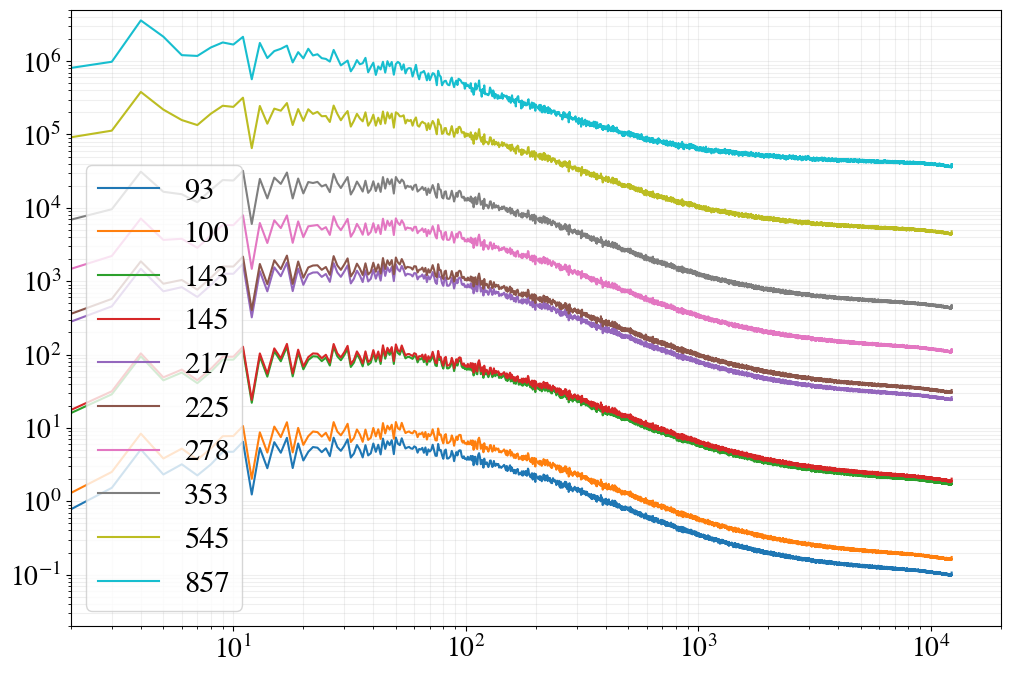

In [2]:
plt.figure(figsize=(12,8))

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_093_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,label='93')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_100_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,label='100')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_143_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,label='143')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_145_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,label='145')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_217_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,label='217')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_225_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,label='225')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_278_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,label='278')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_353_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,label='353')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_545_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,label='545')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_857_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,label='857')



plt.xscale('log')
plt.yscale('log')
plt.ylim(2e-2,5e6)
plt.xlim(2.,2.e4)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=22)

# Compute L0 normalization

In [25]:
M = Class()
M.set({'output':'cib_monopole,cib_cib_1h,cib_cib_2h'})
M.set(common_settings)
M.set(websky_cosmo)
M.set(websky_cib_params)
M.compute()
cl_cib_cib = M.cl_cib_cib()

CIB Monopole

to run following cell you need to download the fits file, I put here the result of this cell:<br>
I0_ws = [594856.1556067903,
 64879.56542025182,
 2737.335720859002,
 121945.91243144483,
 318038.8509457939,
 31888.804251634076,
 35482.62238960164,
 9195.66163207237,
 8796.859744645688,
 2149.0154765762395]

In [27]:
import healpy as hp
cib_freq_list = ['857','278','100','353','545','217','225','145','143','093']
nu_ws = []
I0_ws = []
for cib_freq in cib_freq_list:
    nu_ws.append(float(cib_freq))
    cib_map  =hp.read_map('/Users/boris/Work/CLASS-SZ/SO-SZ/websky_cib/cib_nu0'+cib_freq+'.fits')
    r = np.mean(cib_map)*1e6
    I0_ws.append(r)
    
    

## plot websky CIB monopole not normalized

In [28]:
cib_freq_list = ['857','278','100','353','545','217','225','145','143','093']
nu_ws = []
for cib_freq in cib_freq_list:
    nu_ws.append(float(cib_freq))
I0_ws = [594856.1556067903,
 64879.56542025182,
 2737.335720859002,
 121945.91243144483,
 318038.8509457939,
 31888.804251634076,
 35482.62238960164,
 9195.66163207237,
 8796.859744645688,
 2149.0154765762395]

[]

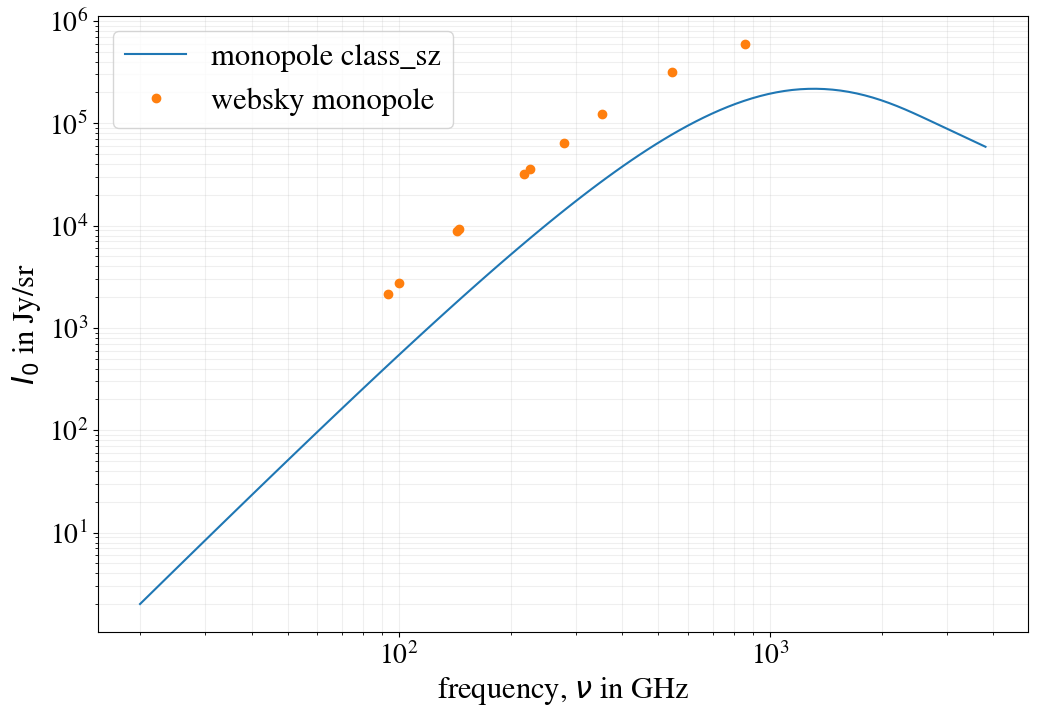

In [29]:
plt.figure(figsize=(12,8))
plt.plot(M.cib_monopole()['nu'],M.cib_monopole()['I0'],label=r'monopole class_sz')
plt.plot(nu_ws,I0_ws,marker='o',label='websky monopole',ls='None')
plt.xlabel(r'frequency, $\nu$ in GHz',fontsize=22)
plt.ylabel(r'$I_0$ in Jy/sr',fontsize=22)
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=22)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.loglog()

Find L0 such that the monopole is normalized:

In [30]:
print(nu_ws[3])
websky_monopole_353_in_Jy = I0_ws[3]


353.0


In [31]:

I0_ini_interp = scipy.interpolate.interp1d(M.cib_monopole()['nu'],M.cib_monopole()['I0'])
L0_websky = websky_monopole_353_in_Jy/I0_ini_interp(353)*1e-7
L0_websky

4.460985082562379e-07

## Recompute and plot cib with websky normalization

In [32]:
L0_websky = 4.461102571695613e-07

In [33]:

M = Class()
M.set({'output':'cib_monopole,cib_cib_1h,cib_cib_2h'})
M.set(common_settings)
M.set(websky_cosmo)
M.set(websky_cib_params)

M.set({'Normalisation of L − M relation in [Jy MPc2/Msun]' :L0_websky,
       'cib_frequency_list_num' : 3,
       'cib_frequency_list_in_GHz' : '353,143,217',  
      })
M.compute()
cl_cib_cib = M.cl_cib_cib()
cib_monopole = M.cib_monopole()

with flux cut:

In [34]:

M = Class()
M.set({'output':'cib_monopole,cib_cib_1h,cib_cib_2h'})
M.set(common_settings)
M.set(websky_cosmo)
M.set(websky_cib_params)

M.set({'Normalisation of L − M relation in [Jy MPc2/Msun]' :L0_websky,
       'cib_frequency_list_num' : 3,
       'cib_frequency_list_in_GHz' : '353,143,217',  
# table 1 of https://arxiv.org/pdf/1309.0382.pdf
#1: freq GHz 2: Flux cut mJy
# 100 - 400
# 143 - 350
# 217 - 225
# 353 - 315
# 545 - 350
# 857 - 710
# 3000  - 1000
#cib_Snu_1 = 315.
#cib_Snu_2 = 315.
        'cib_Snu_cutoff_list [mJy]':'315,350,225',
        'has_cib_flux_cut': 1
      })
M.compute()
cl_cib_cib_flux_cut = M.cl_cib_cib()
cib_monopole_flux_cut = M.cib_monopole()

[]

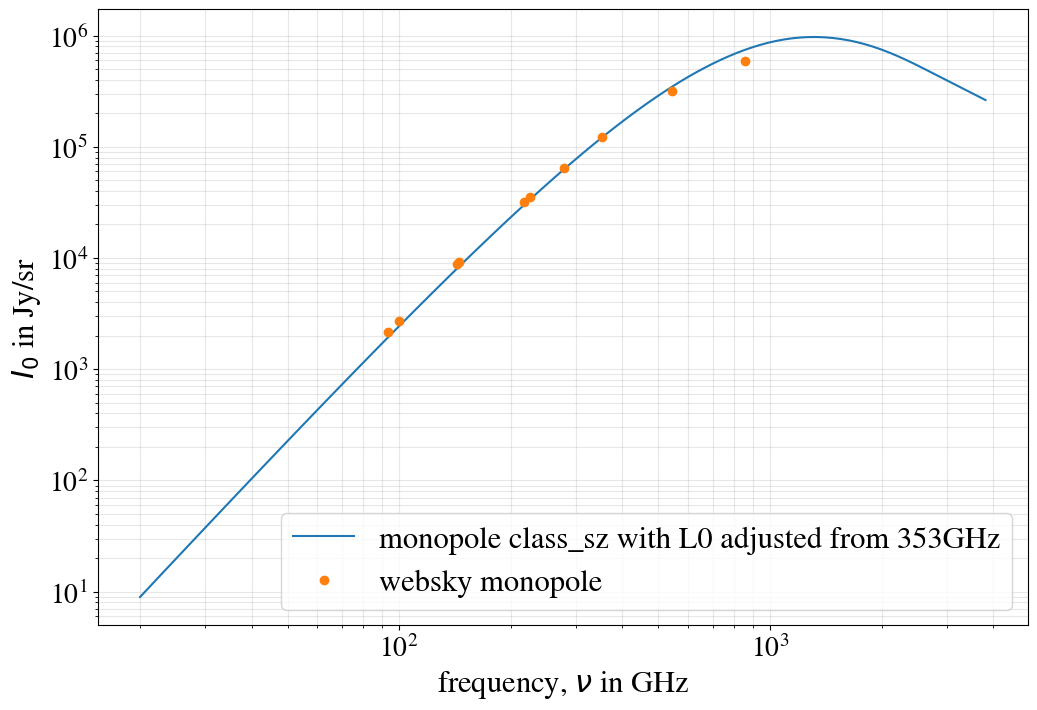

In [35]:
plt.figure(figsize=(12,8))
plt.plot(cib_monopole['nu'],cib_monopole['I0'],label=r'monopole class_sz with L0 adjusted from 353GHz')
plt.plot(nu_ws,I0_ws,marker='o',label='websky monopole',ls='None')
plt.xlabel(r'frequency, $\nu$ in GHz',fontsize=22)
plt.ylabel(r'$I_0$ in Jy/sr',fontsize=22)
plt.grid(which='both',alpha=0.3)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(fontsize=22)
plt.loglog()

CIB Power spectra

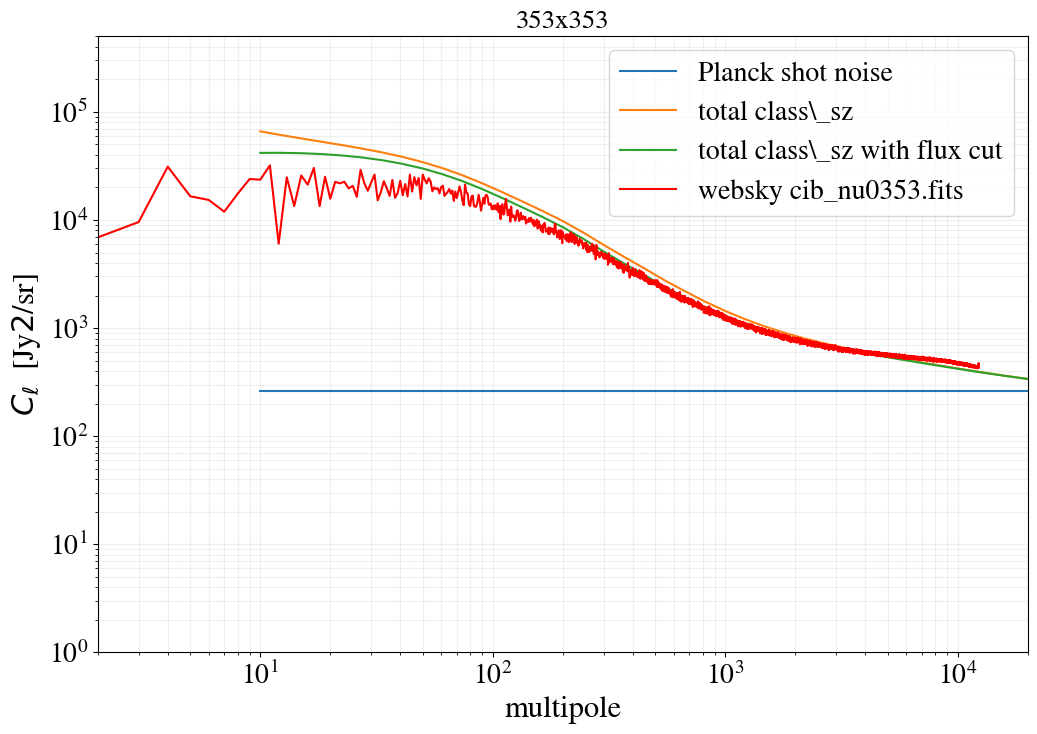

In [37]:
plt.figure(figsize=(12,8))


l_csz = np.asarray(cl_cib_cib['353x353']['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi

cls_csz_1h = np.asarray(cl_cib_cib['353x353']['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib['353x353']['2h'])/cls_to_dls

cls_csz_1h_flux_cut = np.asarray(cl_cib_cib_flux_cut['353x353']['1h'])/cls_to_dls
cls_csz_2h_flux_cut = np.asarray(cl_cib_cib_flux_cut['353x353']['2h'])/cls_to_dls


planck_shot_noise = 262*l_csz/l_csz
plt.plot(l_csz,planck_shot_noise,label='Planck shot noise')


plt.plot(l_csz,(cls_csz_1h+cls_csz_2h)+planck_shot_noise,label='total class\_sz')
plt.plot(l_csz,(cls_csz_1h_flux_cut+cls_csz_2h_flux_cut)+planck_shot_noise,label='total class\_sz with flux cut')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_353_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,c='r',label='websky cib_nu0353.fits')




plt.loglog()
plt.xlim(2,2e4)
plt.ylim(1,5e5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [Jy$2$/sr]',fontsize=22)
plt.title('353x353')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)


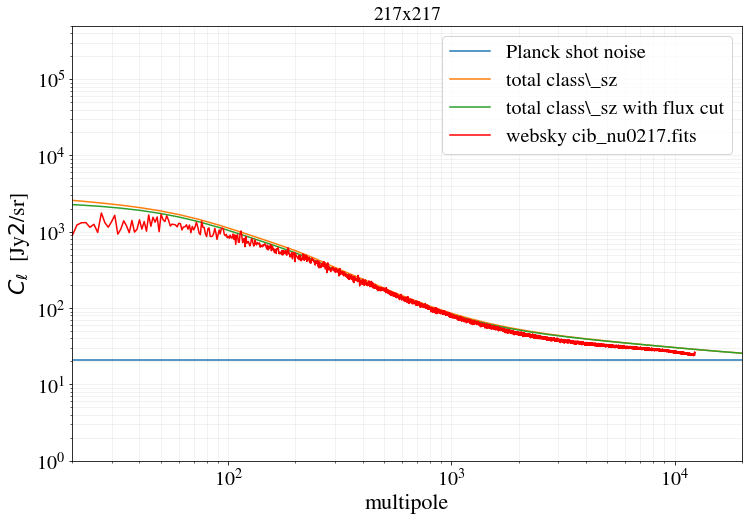

In [99]:
plt.figure(figsize=(12,8))

l_csz = np.asarray(cl_cib_cib['217x217']['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_cib_cib['217x217']['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib['217x217']['2h'])/cls_to_dls

cls_csz_1h_flux_cut = np.asarray(cl_cib_cib_flux_cut['217x217']['1h'])/cls_to_dls
cls_csz_2h_flux_cut = np.asarray(cl_cib_cib_flux_cut['217x217']['2h'])/cls_to_dls

# plt.plot(l_csz,cls_csz_1h,c='k',label='class_sz 1h',ls='-.')
# plt.plot(l_csz,cls_csz_2h,c='k',label='class_sz 2h')

planck_shot_noise = 21.*l_csz/l_csz
plt.plot(l_csz,planck_shot_noise,label='Planck shot noise')


plt.plot(l_csz,(cls_csz_1h+cls_csz_2h)+planck_shot_noise,label='total class\_sz')
plt.plot(l_csz,(cls_csz_1h_flux_cut+cls_csz_2h_flux_cut)+planck_shot_noise,label='total class\_sz with flux cut')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_217_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,c='r',label='websky cib_nu0217.fits')


# l_fm,cls_fm_1h = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_files/cib_1h_353x353.txt',unpack=True)
# l_fm,cls_fm_2h = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_files/cib_2h_353x353.txt',unpack=True)

# cls_fm_1h *= 1./(l_fm*(l_fm+1.)/2./np.pi) 
# cls_fm_2h *= 1./(l_fm*(l_fm+1.)/2./np.pi) 
# plt.plot(l_fm,cls_fm_1h,lw=0.5,c='grey',ls='-.',label='Fiona+Mat 1h')
# plt.plot(l_fm,cls_fm_2h,lw=0.5,c='grey',label='Fiona+Mat 2h')



plt.loglog()
plt.xlim(20,2e4)
plt.ylim(1,5e5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [Jy$2$/sr]',fontsize=22)
plt.title('217x217')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)


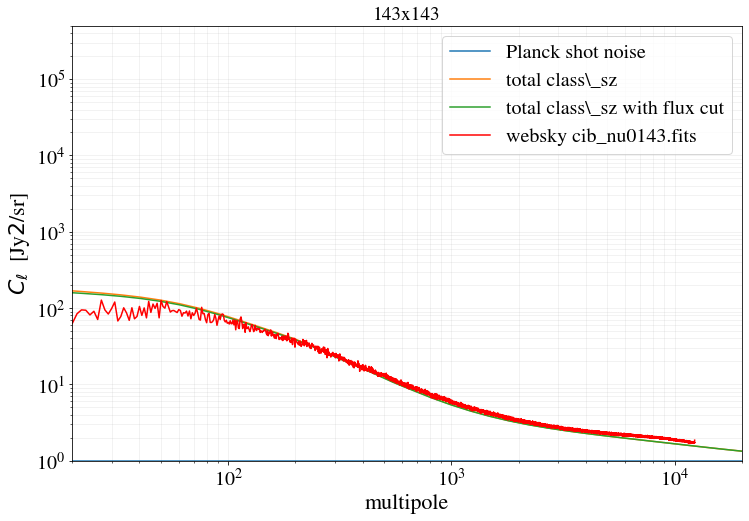

In [101]:
plt.figure(figsize=(12,8))

l_csz = np.asarray(cl_cib_cib['143x143']['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_cib_cib['143x143']['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib['143x143']['2h'])/cls_to_dls

cls_csz_1h_flux_cut = np.asarray(cl_cib_cib_flux_cut['143x143']['1h'])/cls_to_dls
cls_csz_2h_flux_cut = np.asarray(cl_cib_cib_flux_cut['143x143']['2h'])/cls_to_dls

# plt.plot(l_csz,cls_csz_1h,c='k',label='class_sz 1h',ls='-.')
# plt.plot(l_csz,cls_csz_2h,c='k',label='class_sz 2h')

planck_shot_noise = 1.*l_csz/l_csz
plt.plot(l_csz,planck_shot_noise,label='Planck shot noise')


plt.plot(l_csz,(cls_csz_1h+cls_csz_2h)+planck_shot_noise,label='total class\_sz')
plt.plot(l_csz,(cls_csz_1h_flux_cut+cls_csz_2h_flux_cut)+planck_shot_noise,label='total class\_sz with flux cut')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_143_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,c='r',label='websky cib_nu0143.fits')


# l_fm,cls_fm_1h = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_files/cib_1h_353x353.txt',unpack=True)
# l_fm,cls_fm_2h = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_files/cib_2h_353x353.txt',unpack=True)

# cls_fm_1h *= 1./(l_fm*(l_fm+1.)/2./np.pi) 
# cls_fm_2h *= 1./(l_fm*(l_fm+1.)/2./np.pi) 
# plt.plot(l_fm,cls_fm_1h,lw=0.5,c='grey',ls='-.',label='Fiona+Mat 1h')
# plt.plot(l_fm,cls_fm_2h,lw=0.5,c='grey',label='Fiona+Mat 2h')



plt.loglog()
plt.xlim(20,2e4)
plt.ylim(1,5e5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [Jy$2$/sr]',fontsize=22)
plt.title('143x143')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)


# Plot CIB from class_sz using websky model

## compute 

In [3]:
L0_websky = 4.461102571695613e-07

In [4]:

M = Class()
M.set({'output':'cib_monopole,cib_cib_1h,cib_cib_2h,tSZ_cib_1h,tSZ_cib_2h,tSZ_1h,tSZ_2h'})
# M.set({'output':'cib_cib_1h,cib_cib_2h,tSZ_cib_1h,tSZ_cib_2h,tSZ_1h,tSZ_2h'})


M.set(common_settings)
M.set(websky_cosmo)
M.set(websky_cib_params)
M.set(tsz_params)

M.set({'Normalisation of L − M relation in [Jy MPc2/Msun]' :L0_websky,
       
       'cib_frequency_list_num' : 3,
       'cib_frequency_list_in_GHz' : '353,143,217',  
'freq_min' : 1e2, # important for tabulation of Lsat
'freq_max' : 1e3, # important for tabulation of Lsat
'n_nu_L_sat':100    })
M.compute()
cl_cib_cib = M.cl_cib_cib()
cib_monopole = M.cib_monopole()
cl_tsz_cib = M.cl_tSZ_cib()
cl_sz = M.cl_sz()

Alternatively without the normalization


M = Class()
M.set({'output':'cib_monopole,cib_cib_1h,cib_cib_2h,tSZ_cib_1h,tSZ_cib_2h,tSZ_1h,tSZ_2h'})
M.set(common_settings)
M.set(websky_cosmo)
M.set(cib_params)
M.set(tsz_params)

M.set({
       
       'cib_frequency_list_num' : 3,
       'cib_frequency_list_in_GHz' : '353,143,217',  
        #for the monopole computation:
'freq_min' : 1e2, # important for tabulation of Lsat
'freq_max' : 1e3, # important for tabulation of Lsat
'n_nu_L_sat':100
      })
M.compute()
cl_cib_cib = M.cl_cib_cib()
cib_monopole = M.cib_monopole()
cl_tsz_cib = M.cl_tSZ_cib()
cl_sz = M.cl_sz()

with flux cut:

In [4]:

M = Class()
M.set({'output':'cib_monopole,cib_cib_1h,cib_cib_2h,tSZ_cib_1h,tSZ_cib_2h'})
M.set(common_settings)
M.set(websky_cosmo)
M.set(websky_cib_params)
M.set(tsz_params)

M.set({'Normalisation of L − M relation in [Jy MPc2/Msun]' :L0_websky,
       
       'cib_frequency_list_num' : 3,
       'cib_frequency_list_in_GHz' : '353,143,217',  
# table 1 of https://arxiv.org/pdf/1309.0382.pdf
#1: freq GHz 2: Flux cut mJy
# 100 - 400
# 143 - 350
# 217 - 225
# 353 - 315
# 545 - 350
# 857 - 710
# 3000  - 1000
        'cib_Snu_cutoff_list [mJy]':'315,350,225',
        'has_cib_flux_cut': 1,
'freq_min' : 1e2, # important for tabulation of Lsat
'freq_max' : 1e3, # important for tabulation of Lsat
'n_nu_L_sat':100 
      })
M.compute()
cl_cib_cib_flux_cut = M.cl_cib_cib()
cib_monopole_flux_cut = M.cib_monopole()
cl_tsz_cib_flux_cut = M.cl_tSZ_cib()

with A10 pressure profile

In [5]:

M_sz_a10 = Class()
M_sz_a10.set({'output':'tSZ_1h,tSZ_2h'})
M_sz_a10.set(common_settings)
M_sz_a10.set(websky_cosmo)
M_sz_a10.set(tsz_params)
M_sz_a10.set({
'pressure profile': 'Custom. GNFW',
'P0GNFW' : 6.41,
'c500' : 1.81,
'gammaGNFW' : 0.31,
'alphaGNFW' : 1.33,
'betaGNFW' : 4.13,
# 'pressure_profile_epsabs' : 1.e-9
# 'pressure_profile_epsrel' : 1.e-3
'x_outSZ' : 10.,

# 'mass function' : 'M500',
'B' : 1./0.8,
    
'use_redshift_dependent_M_min': 1,
'M_max' : 1e16*websky_cosmo['h'],
'z_min' : 5e-3,
'z_max' : 4.6,
'ell_min': 10.,
'ell_max':5e4,
'dlogell':0.2
})

M_sz_a10.compute()
cl_sz_a10 = M_sz_a10.cl_sz()

## plot monopole

[]

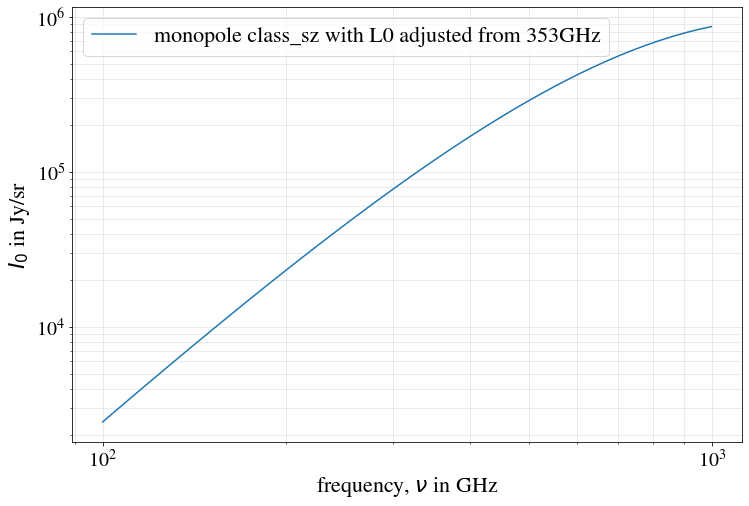

In [6]:
plt.figure(figsize=(12,8))
plt.plot(cib_monopole['nu'],cib_monopole['I0'],label=r'monopole class_sz with L0 adjusted from 353GHz')

plt.xlabel(r'frequency, $\nu$ in GHz',fontsize=22)
plt.ylabel(r'$I_0$ in Jy/sr',fontsize=22)
plt.grid(which='both',alpha=0.3)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(fontsize=22)
plt.loglog()

With Fiona's params:

[]

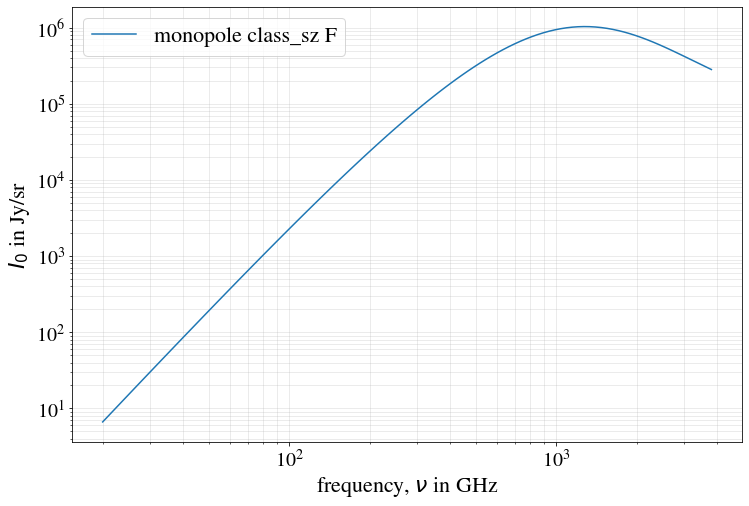

In [143]:
plt.figure(figsize=(12,8))
plt.plot(cib_monopole['nu'],cib_monopole['I0'],label=r'monopole class_sz F')

plt.xlabel(r'frequency, $\nu$ in GHz',fontsize=22)
plt.ylabel(r'$I_0$ in Jy/sr',fontsize=22)
plt.grid(which='both',alpha=0.3)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(fontsize=22)
plt.loglog()

## plot tsz auto power spectrum

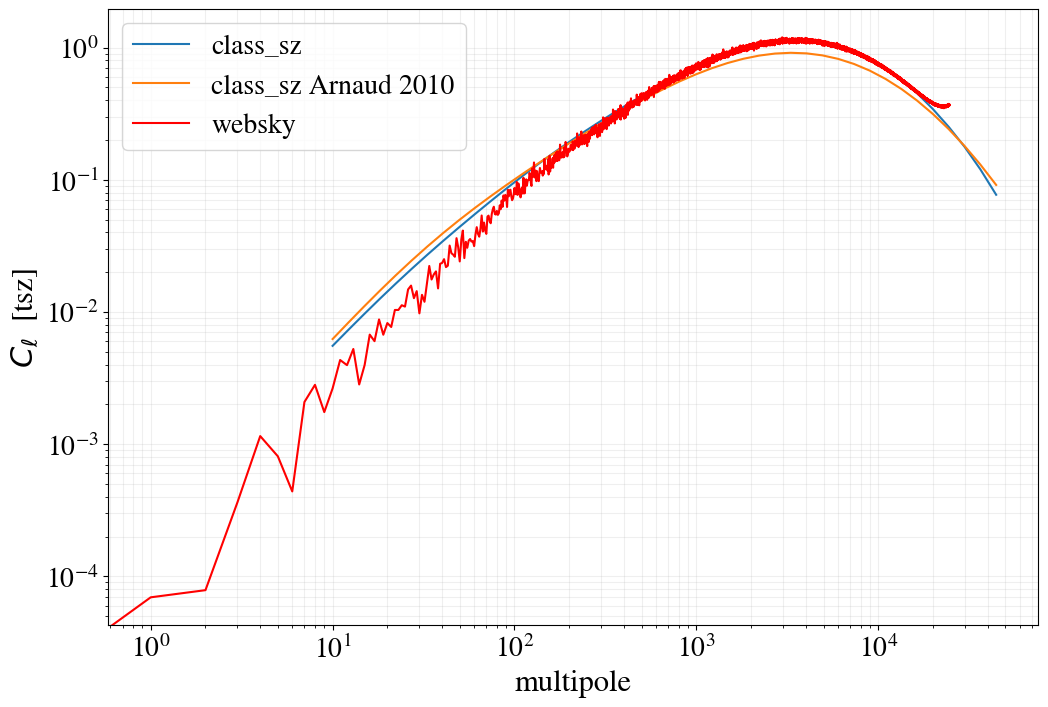

In [6]:
plt.figure(figsize=(12,8))

ls_ws,dls_ws = np.loadtxt(path_to_files+'websky_april_8192.txt',unpack=True)

plt.loglog(cl_sz['ell'],np.asarray(cl_sz['1h'])+np.asarray(cl_sz['2h']),label='class_sz')
plt.loglog(cl_sz_a10['ell'],np.asarray(cl_sz_a10['1h'])+np.asarray(cl_sz_a10['2h']),label='class_sz Arnaud 2010')
plt.loglog(ls_ws,dls_ws*1e12,c='r',label='websky')
# plt.grid(which='both',alpha=0.2)
plt.loglog()
# plt.xlim(20,2e4)
# plt.ylim(1,5e5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [tsz]',fontsize=22)
# plt.title('353x353')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)

## plot cib auto-power spectra

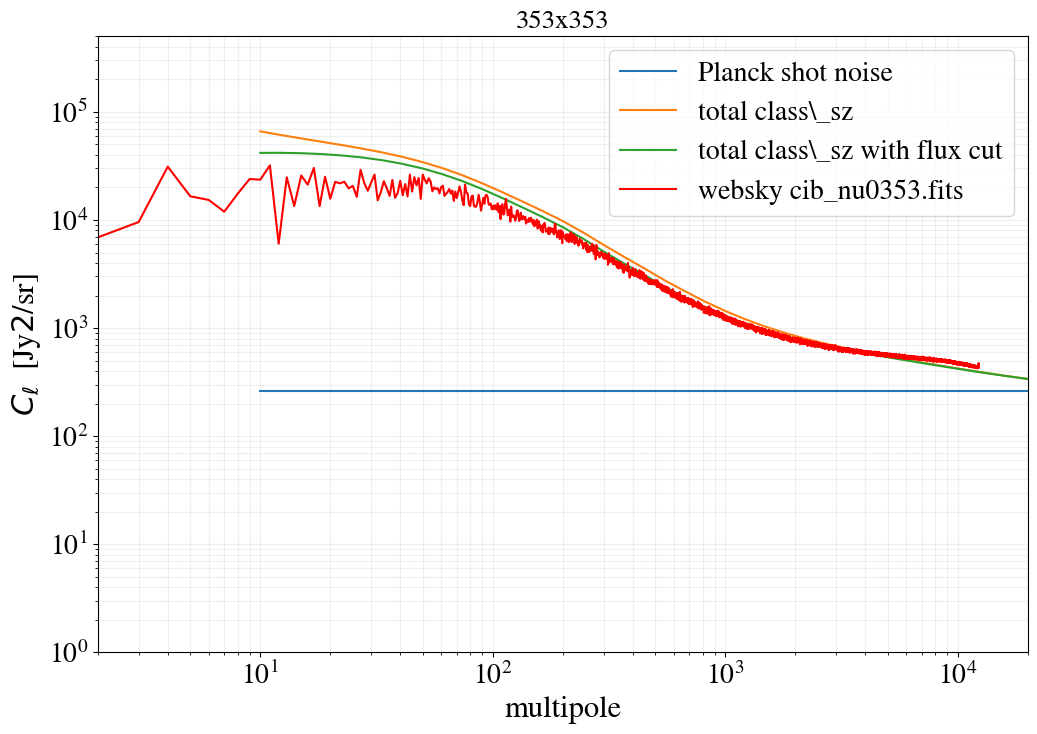

In [66]:
plt.figure(figsize=(12,8))


l_csz = np.asarray(cl_cib_cib['353x353']['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi

cls_csz_1h = np.asarray(cl_cib_cib['353x353']['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib['353x353']['2h'])/cls_to_dls

cls_csz_1h_flux_cut = np.asarray(cl_cib_cib_flux_cut['353x353']['1h'])/cls_to_dls
cls_csz_2h_flux_cut = np.asarray(cl_cib_cib_flux_cut['353x353']['2h'])/cls_to_dls


planck_shot_noise = 262*l_csz/l_csz # see table at the end of notebook
plt.plot(l_csz,planck_shot_noise,label='Planck shot noise')


plt.plot(l_csz,(cls_csz_1h+cls_csz_2h)+planck_shot_noise,label='total class\_sz')
plt.plot(l_csz,(cls_csz_1h_flux_cut+cls_csz_2h_flux_cut)+planck_shot_noise,label='total class\_sz with flux cut')


ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_353_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,c='r',label='websky cib_nu0353.fits')

plt.loglog()
plt.xlim(2,2e4)
plt.ylim(1,5e5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [Jy$2$/sr]',fontsize=22)
plt.title('353x353')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)


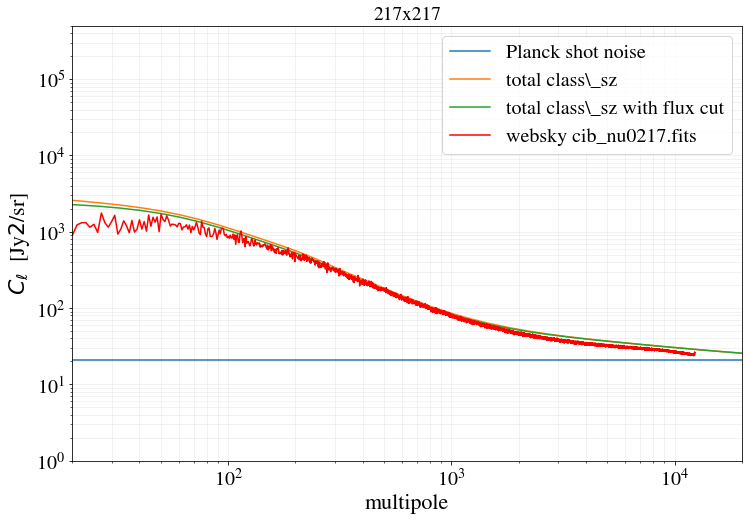

In [9]:
plt.figure(figsize=(12,8))

l_csz = np.asarray(cl_cib_cib['217x217']['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_cib_cib['217x217']['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib['217x217']['2h'])/cls_to_dls

cls_csz_1h_flux_cut = np.asarray(cl_cib_cib_flux_cut['217x217']['1h'])/cls_to_dls
cls_csz_2h_flux_cut = np.asarray(cl_cib_cib_flux_cut['217x217']['2h'])/cls_to_dls


planck_shot_noise = 21.*l_csz/l_csz # see table at the end of notebook
plt.plot(l_csz,planck_shot_noise,label='Planck shot noise')


plt.plot(l_csz,(cls_csz_1h+cls_csz_2h)+planck_shot_noise,label='total class\_sz')
plt.plot(l_csz,(cls_csz_1h_flux_cut+cls_csz_2h_flux_cut)+planck_shot_noise,label='total class\_sz with flux cut')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_217_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,c='r',label='websky cib_nu0217.fits')


plt.loglog()
plt.xlim(20,2e4)
plt.ylim(1,5e5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [Jy$2$/sr]',fontsize=22)
plt.title('217x217')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)


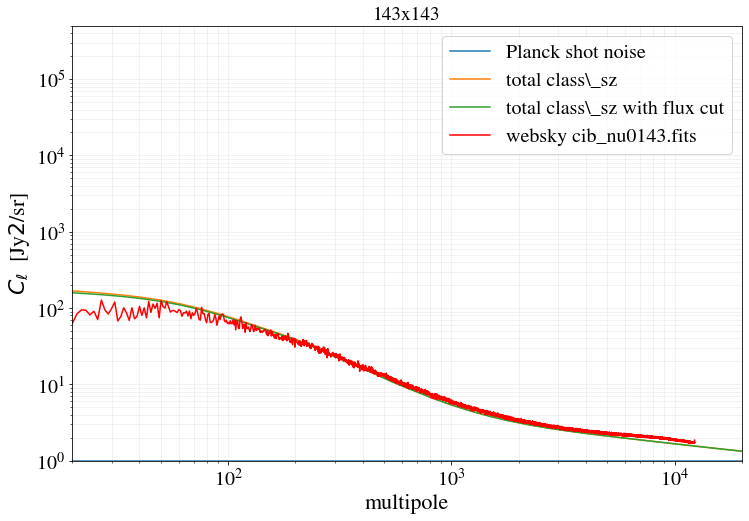

In [12]:
plt.figure(figsize=(12,8))

l_csz = np.asarray(cl_cib_cib['143x143']['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_cib_cib['143x143']['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib['143x143']['2h'])/cls_to_dls

cls_csz_1h_flux_cut = np.asarray(cl_cib_cib_flux_cut['143x143']['1h'])/cls_to_dls
cls_csz_2h_flux_cut = np.asarray(cl_cib_cib_flux_cut['143x143']['2h'])/cls_to_dls


planck_shot_noise = 1.*l_csz/l_csz # see table at the end of notebook
plt.plot(l_csz,planck_shot_noise,label='Planck shot noise')


plt.plot(l_csz,(cls_csz_1h+cls_csz_2h)+planck_shot_noise,label='total class\_sz')
plt.plot(l_csz,(cls_csz_1h_flux_cut+cls_csz_2h_flux_cut)+planck_shot_noise,label='total class\_sz with flux cut')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_143_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,c='r',label='websky cib_nu0143.fits')


plt.loglog()
plt.xlim(20,2e4)
plt.ylim(1,5e5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [Jy$2$/sr]',fontsize=22)
plt.title('143x143')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)


## plot cib - tsz cross power spectra

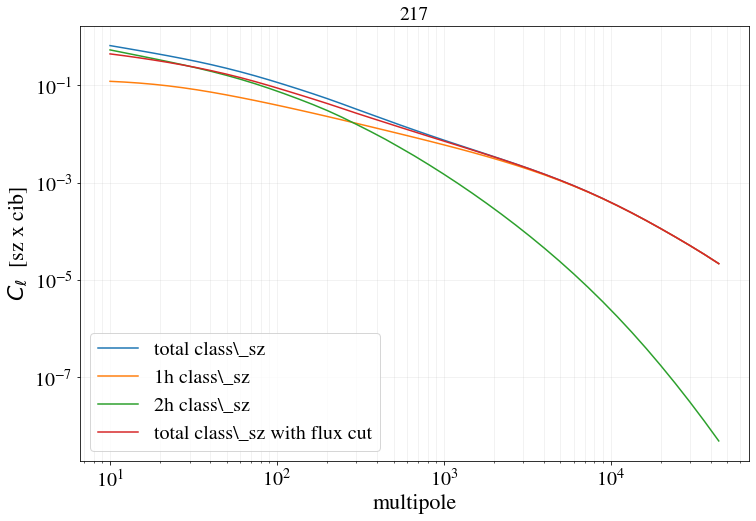

In [13]:
plt.figure(figsize=(12,8))

l_csz = np.asarray(cl_tsz_cib['217']['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_tsz_cib['217']['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_tsz_cib['217']['2h'])/cls_to_dls

cls_csz_1h_flux_cut = np.asarray(cl_tsz_cib_flux_cut['217']['1h'])/cls_to_dls
cls_csz_2h_flux_cut = np.asarray(cl_tsz_cib_flux_cut['217']['2h'])/cls_to_dls



plt.plot(l_csz,(cls_csz_1h+cls_csz_2h),label='total class\_sz')
plt.plot(l_csz,(cls_csz_1h),label='1h class\_sz')
plt.plot(l_csz,(cls_csz_2h),label='2h class\_sz')
plt.plot(l_csz,(cls_csz_1h_flux_cut+cls_csz_2h_flux_cut),label='total class\_sz with flux cut')




plt.loglog()
# plt.xlim(20,2e4)
# plt.ylim(1,5e5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [sz x cib]',fontsize=22)
plt.title('217')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)


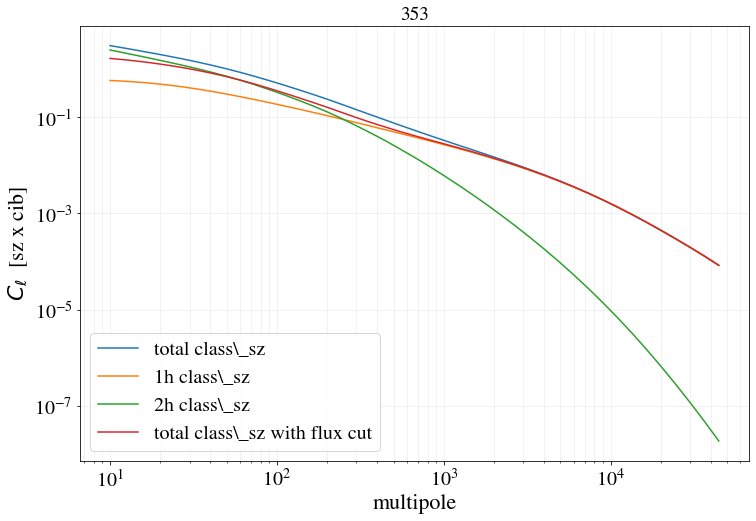

In [16]:
plt.figure(figsize=(12,8))

l_csz = np.asarray(cl_tsz_cib['353']['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_tsz_cib['353']['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_tsz_cib['353']['2h'])/cls_to_dls

cls_csz_1h_flux_cut = np.asarray(cl_tsz_cib_flux_cut['353']['1h'])/cls_to_dls
cls_csz_2h_flux_cut = np.asarray(cl_tsz_cib_flux_cut['353']['2h'])/cls_to_dls



plt.plot(l_csz,(cls_csz_1h+cls_csz_2h),label='total class\_sz')
plt.plot(l_csz,(cls_csz_1h),label='1h class\_sz')
plt.plot(l_csz,(cls_csz_2h),label='2h class\_sz')
plt.plot(l_csz,(cls_csz_1h_flux_cut+cls_csz_2h_flux_cut),label='total class\_sz with flux cut')




plt.loglog()
# plt.xlim(20,2e4)
# plt.ylim(1,5e5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [sz x cib]',fontsize=22)
plt.title('353')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)


## cross-correlation from websky

In [127]:
import healpy as hp

In [14]:
cib_map  =hp.read_map('/Users/boris/Work/CLASS-SZ/SO-SZ/websky_cib/cib_nu0353.fits')

In [128]:
cib_map_143  =hp.read_map('/Users/boris/Work/CLASS-SZ/SO-SZ/websky_cib/cib_nu0143.fits')

In [129]:
tsz_map  =hp.read_map('/Users/boris/Work/CLASS-SZ/SO-SZ/websky_ymap/tsz_8192_april22.fits')

In [17]:
cl = hp.anafast(cib_map,tsz_map, lmax=8000)


In [132]:
cl_143 = hp.anafast(cib_map_143,tsz_map, lmax=8000)


In [34]:
np.savetxt('/Users/boris/Work/CLASS-SZ/SO-SZ/websky_ymap/websky_tszap22_cib353_cls_lmax8000.txt',np.c_[cl])

In [133]:
np.savetxt('/Users/boris/Work/CLASS-SZ/SO-SZ/websky_ymap/websky_tszap22_cib143_cls_lmax8000.txt',np.c_[cl_143])

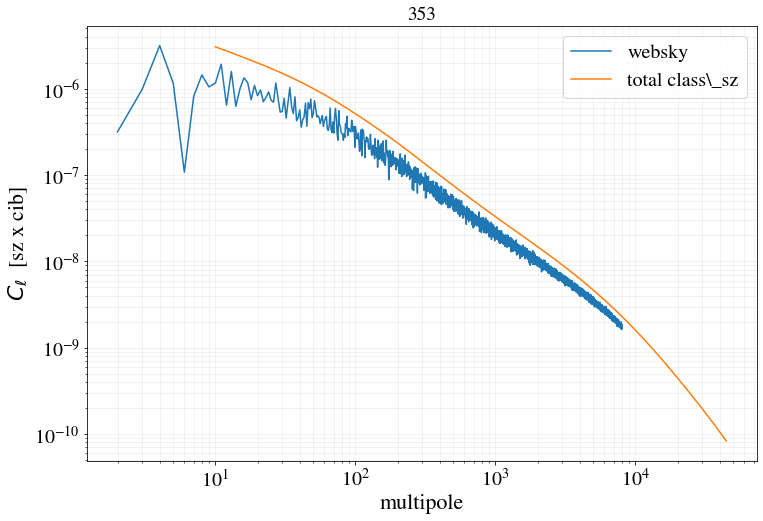

In [17]:
plt.figure(figsize=(12,8))


cl = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/websky_ymap/websky_tszap22_cib353_cls_lmax8000.txt',unpack=True)


l = np.arange(2,8000)
plt.loglog(l,cl[2:8000]*1e6,label='websky')


l_csz = np.asarray(cl_tsz_cib['353']['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_tsz_cib['353']['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_tsz_cib['353']['2h'])/cls_to_dls





plt.plot(l_csz,(cls_csz_1h+cls_csz_2h)*1e-6,label='total class\_sz')


plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [sz x cib]',fontsize=22)
plt.title('353')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)

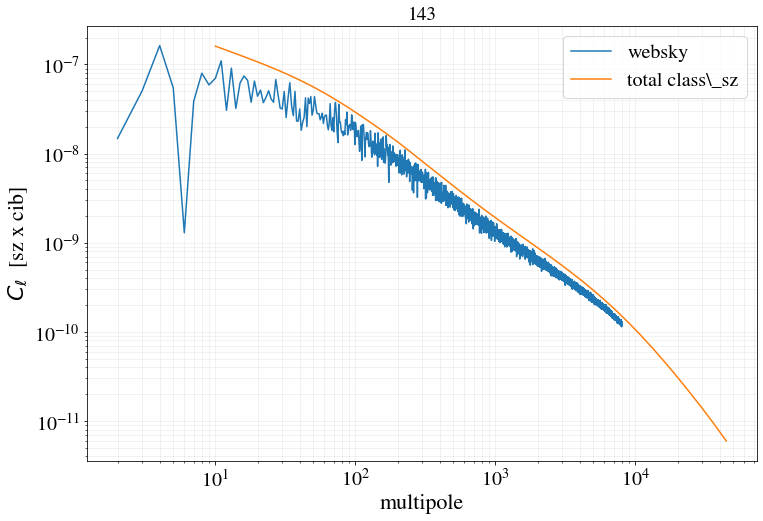

In [18]:
plt.figure(figsize=(12,8))


cl_143 = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/websky_ymap/websky_tszap22_cib143_cls_lmax8000.txt',unpack=True)

l = np.arange(2,8000)
plt.loglog(l,cl_143[2:8000]*1e6,label='websky')


l_csz = np.asarray(cl_tsz_cib['143']['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_tsz_cib['143']['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_tsz_cib['143']['2h'])/cls_to_dls





plt.plot(l_csz,(cls_csz_1h+cls_csz_2h)*1e-6,label='total class\_sz')


plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [sz x cib]',fontsize=22)
plt.title('143')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)

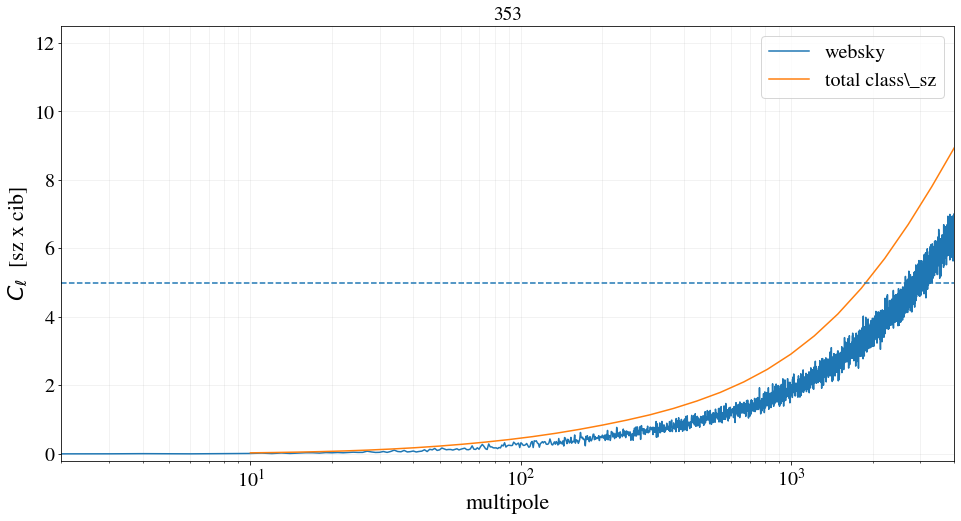

In [14]:
plt.figure(figsize=(16,8))


cl = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/websky_ymap/websky_tszap22_cib353_cls_lmax8000.txt',unpack=True)


l = np.arange(2,8000)
plt.plot(l,l*(l+1.)/2./np.pi*cl[2:8000]/287.450*0.16*1e12,label='websky')
# *0.16/6.205

l_csz = np.asarray(cl_tsz_cib['353']['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_tsz_cib['353']['1h'])#/cls_to_dls
cls_csz_2h = np.asarray(cl_tsz_cib['353']['2h'])#/cls_to_dls





plt.plot(l_csz,(cls_csz_1h+cls_csz_2h)/287.450*0.16,label='total class\_sz')


plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [sz x cib]',fontsize=22)
plt.title('353')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)
plt.xscale('log')
plt.xlim(2,4000)
plt.ylim(-0.2,12.5)
plt.axhline(5,ls='--')

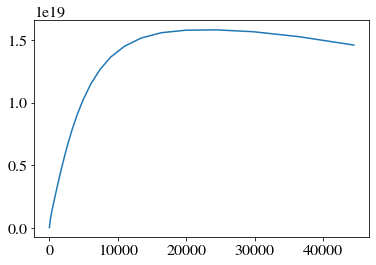

In [12]:
plt.plot(l_csz,(cls_csz_1h+cls_csz_2h)/287.450*0.16*1e12*1e6,label='total class\_sz')



In [76]:
T_cmb = 2.7255
_h_P_=6.62606896e-34
_k_B_=1.3806504e-23
frequency_in_Hz = 353e9
Tcmb_gNU = T_cmb*((_h_P_*frequency_in_Hz/(_k_B_*T_cmb))*(1./np.tanh((_h_P_*frequency_in_Hz/(_k_B_*T_cmb))/2.))-4.)
Tcmb_gNU

6.107124202586464

# Comparison with CCL

In [2]:
import pyccl as ccl

In [3]:
websky_cosmo

{'omega_b': 0.022657600000000007,
 'omega_cdm': 0.12068640000000003,
 'h': 0.68,
 'tau_reio': 0.0543,
 'sigma8': 0.81,
 'n_s': 0.965,
 'use_websky_m200m_to_m200c_conversion': 1}

In [4]:
tsz_params

{'pressure profile': 'B12',
 'units for tSZ spectrum': 'dimensionless',
 'n_ell_pressure_profile': 100,
 'n_m_pressure_profile': 100,
 'n_z_pressure_profile': 100,
 'x_outSZ': 4.0,
 'truncate_wrt_rvir': 0,
 'pressure_profile_epsrel': 0.001,
 'pressure_profile_epsabs': 1e-40}

In [5]:
common_settings


{'mass function': 'T08',
 'delta for cib': '200m',
 'hm_consistency': 0,
 'concentration parameter': 'D08'}

In [6]:
cosmo = ccl.Cosmology(
    Omega_b=websky_cosmo['omega_b']/websky_cosmo['h']**2,
    Omega_c=websky_cosmo['omega_cdm']/websky_cosmo['h']**2,
    h=websky_cosmo['h'],
    n_s=websky_cosmo['n_s'],
    #A_s=float(p_dict['A_s']),
    sigma8 = websky_cosmo['sigma8'],
    w0=-1,
    wa=0,
    m_nu=0.,
    m_nu_type='normal',
    Neff=3.046,
    Omega_k=0,
    transfer_function = 'boltzmann_class')

In [7]:
tracers = {}
# tSZ
tracers['y'] = ccl.tSZTracer(cosmo, z_max=6.)
# CIB
tracers['c'] = ccl.CIBTracer(cosmo, z_min=1e-5,z_max=6.)

# CMB lensing
tracers['k'] = ccl.CMBLensingTracer(cosmo, z_source=1100)



lk_arr = np.log(np.geomspace(1E-4, 500, 256))
a_arr = 1./(1.+np.linspace(1.e-5, 6., 100)[::-1])

# mass_def = ccl.halos.MassDef(200, 'matter')
# mass_def = ccl.halos.MassDef(500, 'critical')
mass_def = ccl.halos.MassDef(200, 'critical')
hmf = ccl.halos.MassFuncTinker08(cosmo, mass_def=mass_def)
hbf = ccl.halos.HaloBiasTinker10(cosmo, mass_def=mass_def)

hmc = ccl.halos.HMCalculator(cosmo, 
                             hmf, 
                             hbf, 
                             mass_def,
                            log10M_min=10.0,
                            log10M_max=16.0,
                            )


profs = {}
# This just defines which of these tracers should be normalized (e.g. overdensities)
norm = {}

# tSZ
profs['y'] = ccl.halos.HaloProfilePressureGNFW(x_out=4,
                                               mass_bias=0.8*0.45,
                                               P0_hexp = -1.5)
norm['y'] = False

# # CIB
cm = ccl.halos.ConcentrationDuffy08(mass_def)
pr = ccl.halos.HaloProfileCIBShang12(cm, 545)

pr.update_parameters(nu_GHz=545,
                  alpha=0.36,
                  T0=24.4,
                  beta=1.75,
                  gamma=1.7,
                  s_z=3.6,
                  log10meff=12.6,
                  sigLM=np.sqrt(0.5),
                  Mmin=1E10,
                  L0=6.4E-8)
profs['c'] = pr
norm['c'] = False

# CMB lensing
profs['k'] = ccl.halos.HaloProfileNFW(cm)
norm['k'] = True

tracer_list = list(profs.keys())
profs2pt = {f'{t1}-{t2}': ccl.halos.Profile2pt() for t1 in tracer_list for t2 in tracer_list}
profs2pt['c-c'] = ccl.halos.Profile2ptCIB()

pks = {f'{t1}-{t2}': ccl.halos.halomod_Pk2D(cosmo, hmc,
                                            profs[t1],
                                            prof_2pt=profs2pt[f'{t1}-{t2}'],
                                            prof2=profs[t2],
                                            normprof1=norm[t1],
                                            normprof2=norm[t2],
                                            a_arr=a_arr,
                                            lk_arr=lk_arr)
       for t1 in tracer_list for t2 in tracer_list}

ells = np.unique(np.geomspace(2, 30000, 128).astype(int)).astype(float)
c_ells = {f'{t1}-{t2}': ccl.angular_cl(cosmo, tracers[t1], tracers[t2], ells, p_of_k_a=pks[f'{t1}-{t2}'])
          for t1 in tracer_list for t2 in tracer_list}

In [8]:
cib_params

{'hm_consistency': 0,
 'Redshift evolution of dust temperature': 0.36,
 'Dust temperature today in Kelvins': 24.4,
 'Emissivity index of sed': 1.75,
 'Power law index of SED at high frequency': 1.7,
 'Redshift evolution of L − M normalisation': 3.6,
 'Most efficient halo mass in Msun': 3981071705534.969,
 'Normalisation of L − M relation in [Jy MPc2/Msun]': 6.4e-08,
 'Size of of halo masses sourcing CIB emission': 0.5,
 'M_min_HOD': 10000000000.0,
 'M_min': 6800000000.000001,
 'M_max': 6800000000000000.0,
 'z_min': 0.07,
 'z_max': 6,
 'ell_min': 10.0,
 'ell_max': 50000.0,
 'dlogell': 0.2,
 'cib_frequency_list_num': 1,
 'cib_frequency_list_in_GHz': '353'}

In [9]:
'%.3e'%10000000000.0

'1.000e+10'

In [10]:
M_sz_ccl = Class()
M_sz_ccl.set({'output':'tSZ_1h,tSZ_2h,cib_cib_1h,cib_cib_2h,tSZ_cib_1h,tSZ_cib_2h,lens_lens_1h,lens_lens_2h,lens_cib_1h,lens_cib_2h'})
# M_sz_ccl.set({'output':'tSZ_cib_1h,tSZ_cib_2h'})


# M_sz_ccl.set(common_settings)
M_sz_ccl.set(websky_cosmo)
# M_sz_ccl.set(tsz_params)
# M_sz_ccl.set(cib_params)
M_sz_ccl.set({'delta for cib':'200m'})
M_sz_ccl.set({
'M_min' : 1e10*websky_cosmo['h'], # was 1e10
'M_max' : 1e16*websky_cosmo['h'],
'z_min' : 1e-5, # was 1e-5
'z_max' : 6.,
'z_max_pk' : 6.,
'ell_min': 10.,
'ell_max':5e4,
'dlogell':0.2,  
    
'pressure profile': 'Custom. GNFW',
'P0GNFW' : 6.41,
'c500' : 1.81,
'gammaGNFW' : 0.31,
'alphaGNFW' : 1.33,
'betaGNFW' : 4.13,
# 'pressure_profile_epsabs' : 1.e-9
# 'pressure_profile_epsrel' : 1.e-3
'x_outSZ' : 4.,

'mass function' : 'T08M200c',
'concentration parameter': 'D08',
'B' : 1.2,
'cib_frequency_list_in_GHz': '545',
'hm_consistency':1,
    
    
'redshift_epsabs' : 1e-40,#1.e-40
'redshift_epsrel' : 1e-4,#1.e-10 # fiducial value 1e-8

'mass_epsabs' : 1e-40, #1.e-40
'mass_epsrel' : 1e-4,#1e-10
    
'M_min_HOD' : pow(10.,10),

'dlogell' : 0.4,
'ell_max' : 15000.,
'ell_min' : 2.,




    # CIB parametes see McCarthy & Madhavacheril 2020
'Redshift evolution of dust temperature' :  0.36,
'Dust temperature today in Kelvins' : 24.4,
'Emissivity index of sed' : 1.75,
'Power law index of SED at high frequency' : 1.7,
'Redshift evolution of L − M normalisation' : 3.6,
'Most efficient halo mass in Msun' : pow(10.,12.6),
'Normalisation of L − M relation in [Jy MPc2/Msun]' : 6.4e-8,
'Size of of halo masses sourcing CIB emission' : 0.5,
'has_cib_flux_cut' : 0,
    
    
'L_sat_epsabs' : 1e-40, #1.e-40
'L_sat_epsrel' : 1e-3,#1e-10
    
# 'Omega_cdm' : 0.3175-0.022068/0.6711/0.6711,
# 'omega_b' : 0.022068,
# 'h' : 0.6711,
# 'A_s' : 2.2e-9,
# 'n_s' : .9624,
# 'k_pivot' : 0.05,


# 'N_ncdm' : 1,
# 'N_ur' : 0.00641,
# 'deg_ncdm' : 3,
# 'm_ncdm' : 0.02,
# 'T_ncdm' : 0.71611,

'n_nu_L_sat': 300,
'freq_min' : 1e2, # important for tabulation of Lsat
'freq_max' : 1e3, # important for tabulation of Lsat
})

M_sz_ccl.compute()
cl_sz_ccl = M_sz_ccl.cl_sz()
cl_cib_ccl = M_sz_ccl.cl_cib_cib()
cl_tsz_cib_ccl = M_sz_ccl.cl_tSZ_cib()
cl_k_ccl = M_sz_ccl.cl_kk()
cl_k_cib_ccl =M_sz_ccl.cl_lens_cib()

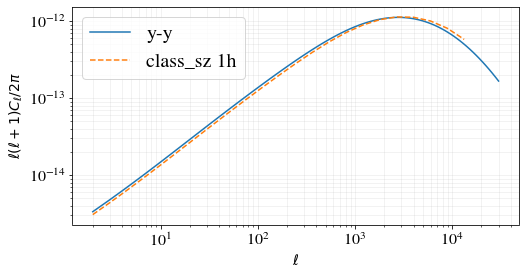

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(ells, ells*(ells+1)*c_ells[f'y-y']/(2*np.pi), label=f'y-y')
plt.loglog(cl_sz_ccl['ell'],(np.asarray(cl_sz_ccl['1h'])+np.asarray(cl_sz_ccl['2h']))*1e-12,
           ls='--',
           label='class_sz 1h')
plt.loglog()
plt.legend(ncol=2)
plt.xlabel(r'$\ell$', fontsize=14)
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$', fontsize=14)
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)

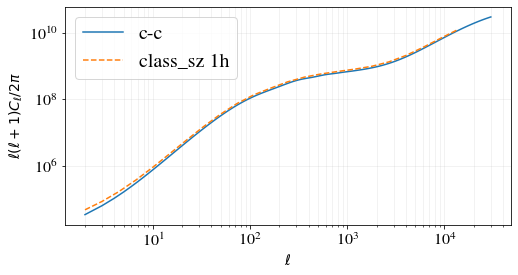

In [12]:
plt.figure(figsize=(8, 4))
plt.plot(ells, ells*(ells+1)*c_ells[f'c-c']/(2*np.pi), label=f'c-c')
plt.loglog(cl_cib_ccl['545x545']['ell'],(np.asarray(cl_cib_ccl['545x545']['1h'])+np.asarray(cl_cib_ccl['545x545']['2h'])),
           ls='--',
           label='class_sz 1h')
plt.loglog()
plt.legend(ncol=2)
plt.xlabel(r'$\ell$', fontsize=14)
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$', fontsize=14)
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)

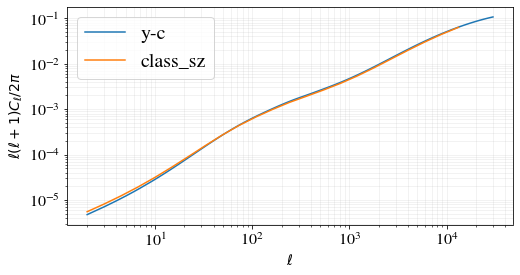

In [14]:
plt.figure(figsize=(8, 4))
plt.plot(ells, ells*(ells+1)*c_ells[f'y-c']/(2*np.pi), label=f'y-c')
plt.plot(cl_tsz_cib_ccl['545']['ell'],(np.asarray(cl_tsz_cib_ccl['545']['1h'])+np.asarray(cl_tsz_cib_ccl['545']['2h']))*1e-6, label=f'class_sz')
plt.loglog()
plt.legend(ncol=2)
plt.xlabel(r'$\ell$', fontsize=14)
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$', fontsize=14)
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)

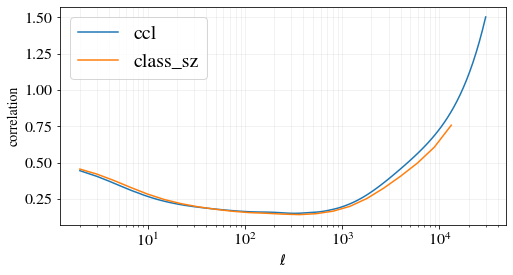

In [15]:
plt.figure(figsize=(8, 4))
plt.plot(ells, c_ells[f'y-c']/np.sqrt(c_ells[f'y-y']*c_ells[f'c-c']), label=f'ccl')
num = (np.asarray(cl_tsz_cib_ccl['545']['1h'])+np.asarray(cl_tsz_cib_ccl['545']['2h']))*1e-6
den1 = (np.asarray(cl_cib_ccl['545x545']['1h'])+np.asarray(cl_cib_ccl['545x545']['2h']))
den2 = (np.asarray(cl_sz_ccl['1h'])+np.asarray(cl_sz_ccl['2h']))*1e-12
plt.plot(cl_tsz_cib_ccl['545']['ell'],num/np.sqrt(den1*den2), label=f'class_sz')
plt.xscale('log')
# plt.yscale('log')
plt.legend(ncol=2)
plt.xlabel(r'$\ell$', fontsize=14)
plt.ylabel(r'correlation', fontsize=14)
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)

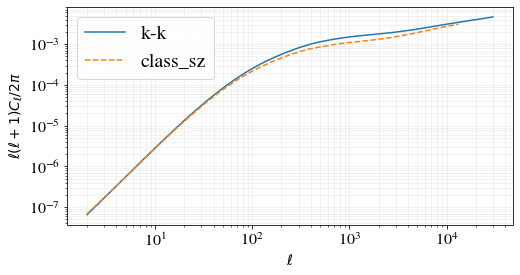

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(ells, ells*(ells+1)*c_ells[f'k-k']/(2*np.pi), label=f'k-k')
plt.loglog(cl_k_ccl['ell'],(np.asarray(cl_k_ccl['1h'])+np.asarray(cl_k_ccl['2h'])),
           ls='--',
           label='class_sz')
plt.loglog()
plt.legend(ncol=2)
plt.xlabel(r'$\ell$', fontsize=14)
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$', fontsize=14)
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)

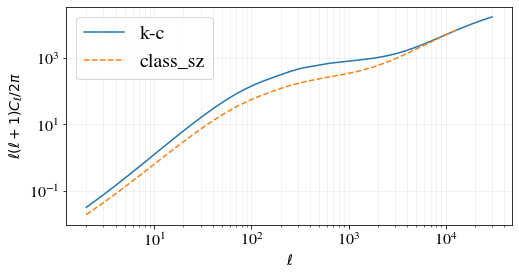

In [17]:
plt.figure(figsize=(8, 4))
plt.plot(ells, ells*(ells+1)*c_ells[f'k-c']/(2*np.pi), label=f'k-c')
plt.loglog(cl_k_cib_ccl['545']['ell'],(np.asarray(cl_k_cib_ccl['545']['1h'])+np.asarray(cl_k_cib_ccl['545']['2h'])),
           ls='--',
           label='class_sz')
plt.loglog()
plt.legend(ncol=2)
plt.xlabel(r'$\ell$', fontsize=14)
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$', fontsize=14)
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)

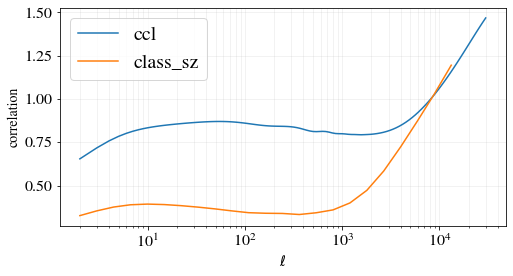

In [19]:
plt.figure(figsize=(8, 4))
plt.plot(ells, c_ells[f'k-c']/np.sqrt(c_ells[f'k-k']*c_ells[f'c-c']), label=f'ccl')
num = (np.asarray(cl_k_cib_ccl['545']['1h'])+np.asarray(cl_k_cib_ccl['545']['2h']))
den1 = (np.asarray(cl_cib_ccl['545x545']['1h'])+np.asarray(cl_cib_ccl['545x545']['2h']))
den2 = (np.asarray(cl_k_ccl['1h'])+np.asarray(cl_k_ccl['2h']))
plt.plot(cl_k_cib_ccl['545']['ell'],num/np.sqrt(den1*den2), label=f'class_sz')
plt.xscale('log')
plt.yscale('linear')
plt.legend(ncol=2)
plt.xlabel(r'$\ell$', fontsize=14)
plt.ylabel(r'correlation', fontsize=14)
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)

# CIB correlation

In [12]:
L0_websky = 4.461102571695613e-07
M = Class()
M.set({'output':'cib_cib_1h,cib_cib_2h'})
M.set(common_settings)
M.set(websky_cosmo)
M.set(websky_cib_params)
M.set(tsz_params)

M.set({'Normalisation of L − M relation in [Jy MPc2/Msun]' :L0_websky,
       
       'cib_frequency_list_num' : 2,
       'cib_frequency_list_in_GHz' : '220,857',  
      })
M.compute()
cl_cib_cib = M.cl_cib_cib()


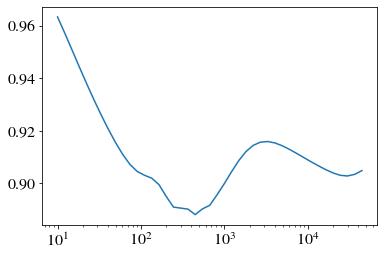

In [21]:
ell =  np.asarray(cl_cib_cib['857x857']['ell'])
cl_353_353 = np.asarray(cl_cib_cib['857x857']['1h'])+np.asarray(cl_cib_cib['857x857']['2h'])
cl_143_143 = np.asarray(cl_cib_cib['220x220']['1h'])+np.asarray(cl_cib_cib['220x220']['2h'])
cl_143_353 = np.asarray(cl_cib_cib['857x220']['1h'])+np.asarray(cl_cib_cib['857x220']['2h'])
plt.plot(ell,cl_143_353/np.sqrt((cl_353_353*cl_143_143)))
plt.xscale('log')

In [19]:
ell

array([1.00000000e+01, 1.22140276e+01, 1.49182470e+01, 1.82211880e+01,
       2.22554093e+01, 2.71828183e+01, 3.32011692e+01, 4.05519997e+01,
       4.95303242e+01, 6.04964746e+01, 7.38905610e+01, 9.02501350e+01,
       1.10231764e+02, 1.34637380e+02, 1.64446468e+02, 2.00855369e+02,
       2.45325302e+02, 2.99641000e+02, 3.65982344e+02, 4.47011845e+02,
       5.45981500e+02, 6.66863310e+02, 8.14508687e+02, 9.94843156e+02,
       1.21510418e+03, 1.48413159e+03, 1.81272242e+03, 2.21406416e+03,
       2.70426407e+03, 3.30299560e+03, 4.03428793e+03, 4.92749041e+03,
       6.01845038e+03, 7.35095189e+03, 8.97847292e+03, 1.09663316e+04,
       1.33943076e+04, 1.63598443e+04, 1.99819590e+04, 2.44060198e+04,
       2.98095799e+04, 3.64095031e+04, 4.44706675e+04])

# Some useful imported plots/tables and references

(Note that here the class_sz settings are not setup to reproduce Fiona+Mat's results, see at the end of the notebook for the benchmark comparison)

Here below is Fiona+Mat's plot from https://arxiv.org/pdf/2010.16405.pdf

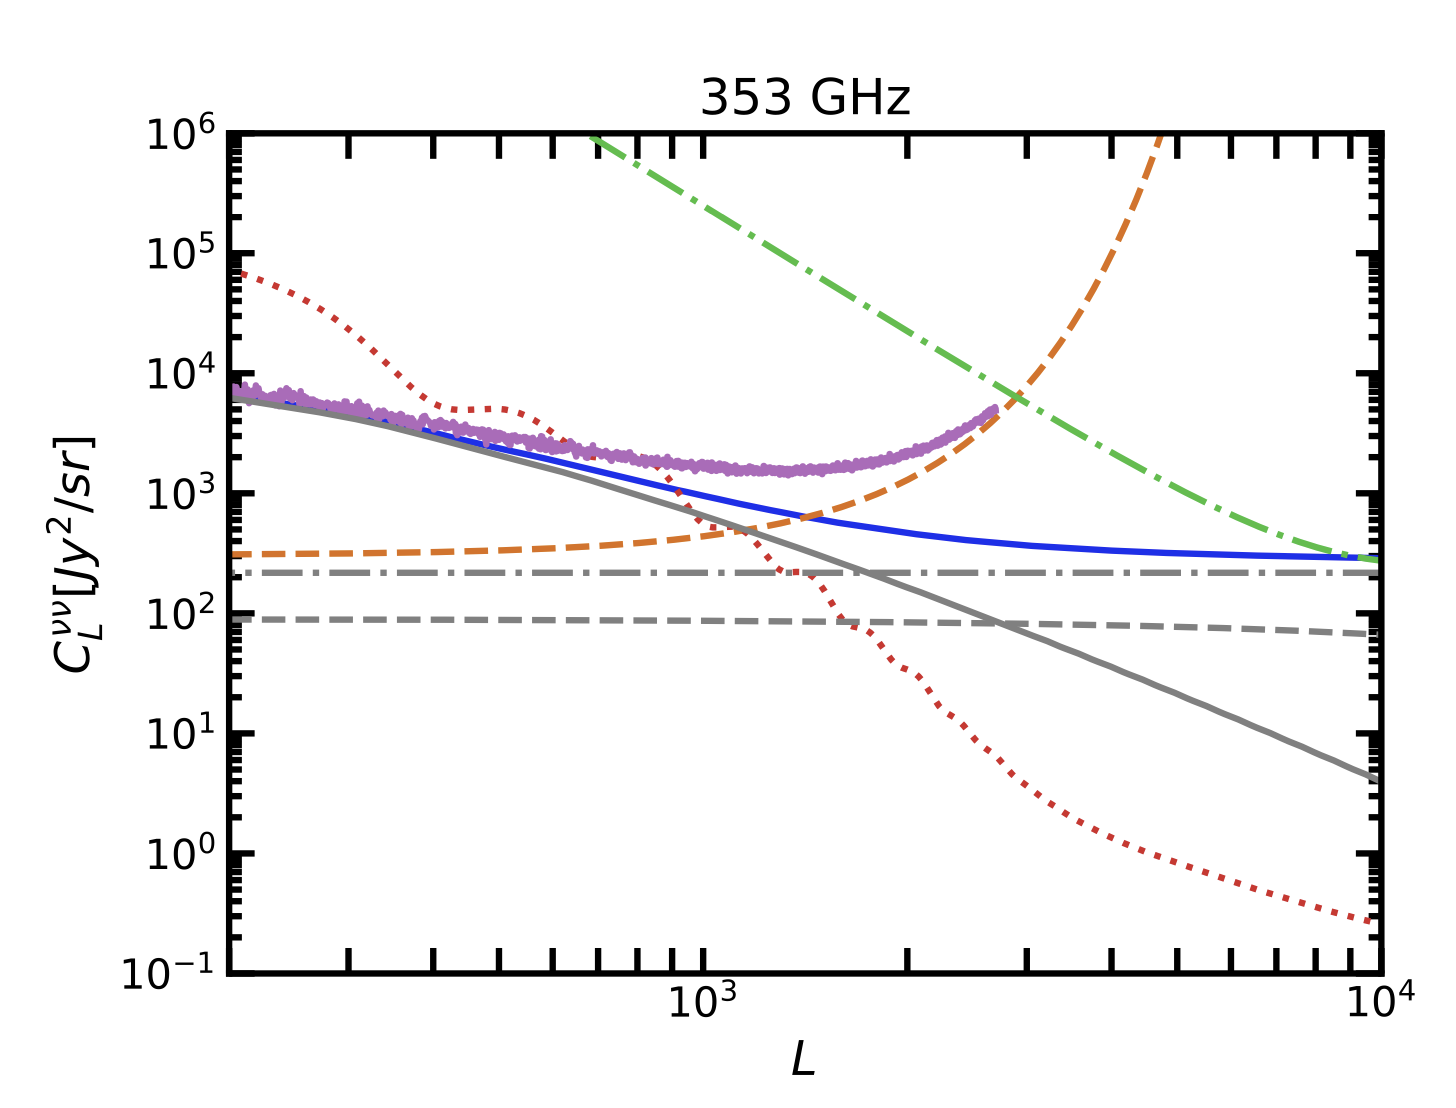

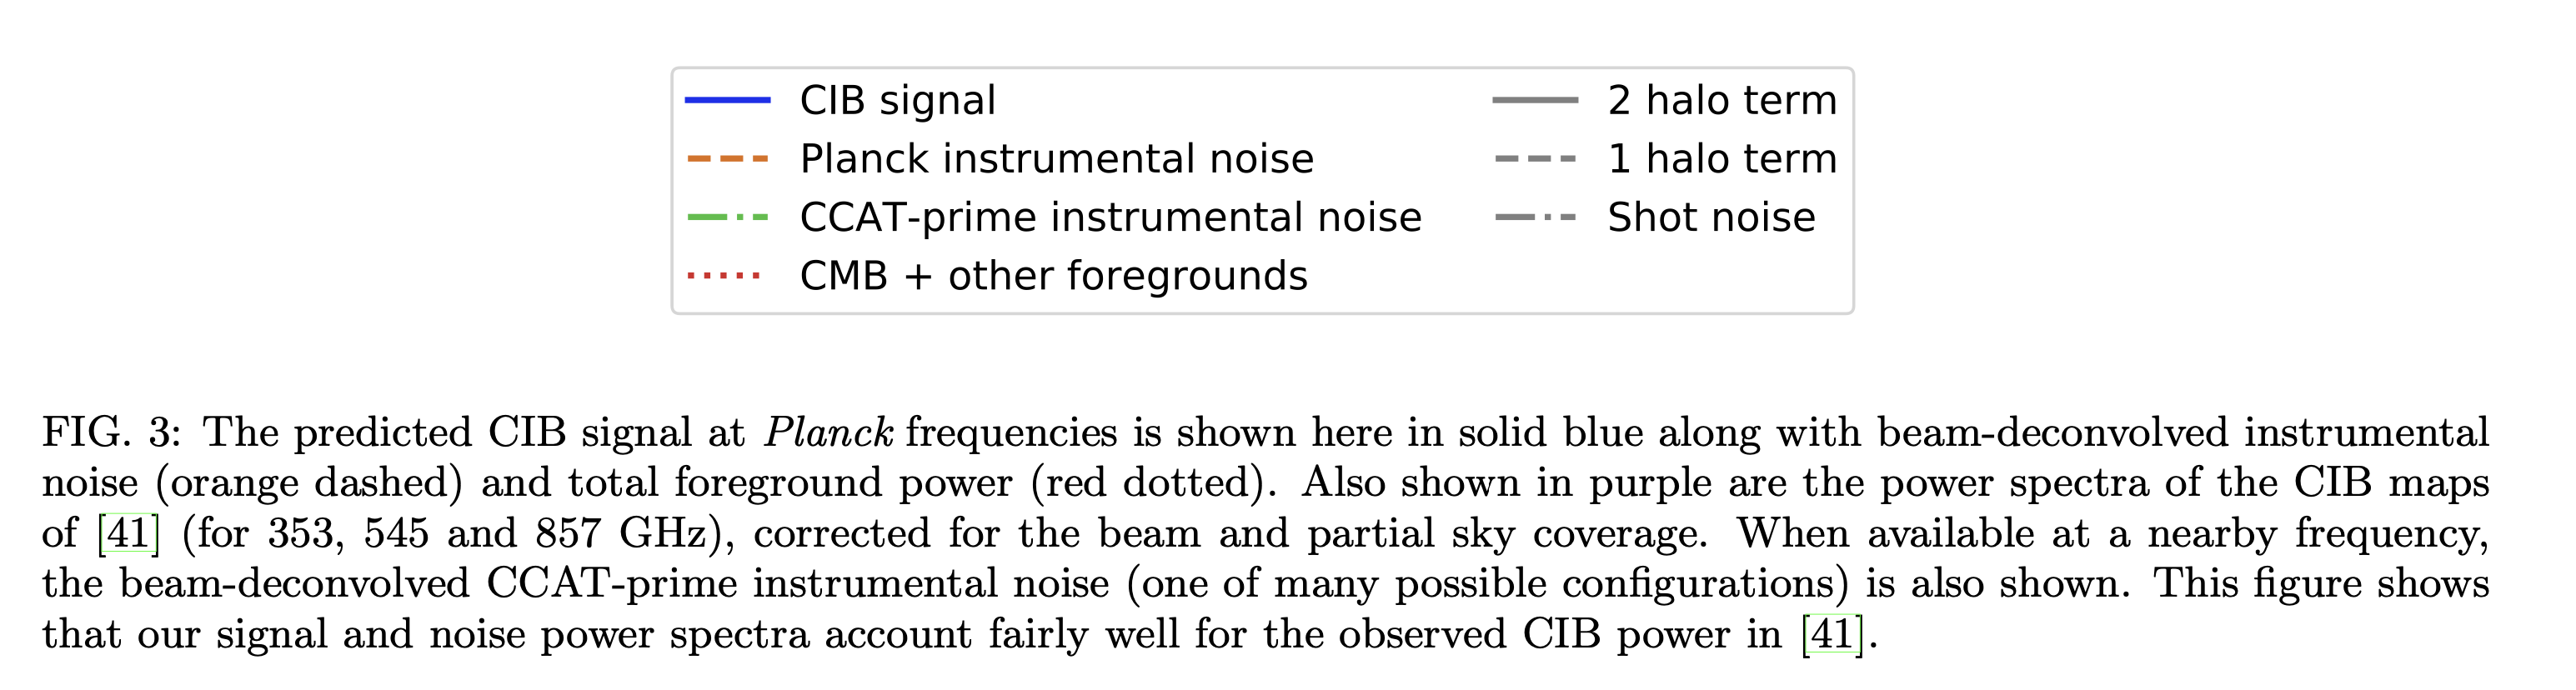

Ref 41 is D. Lenz, O. Dor ́e, and G. Lagache, ApJ 883, 75 (2019), 1905.00426.
https://arxiv.org/pdf/1905.00426.pdf

The CIB power spectrum plot from the websky paper https://arxiv.org/pdf/2001.08787.pdf

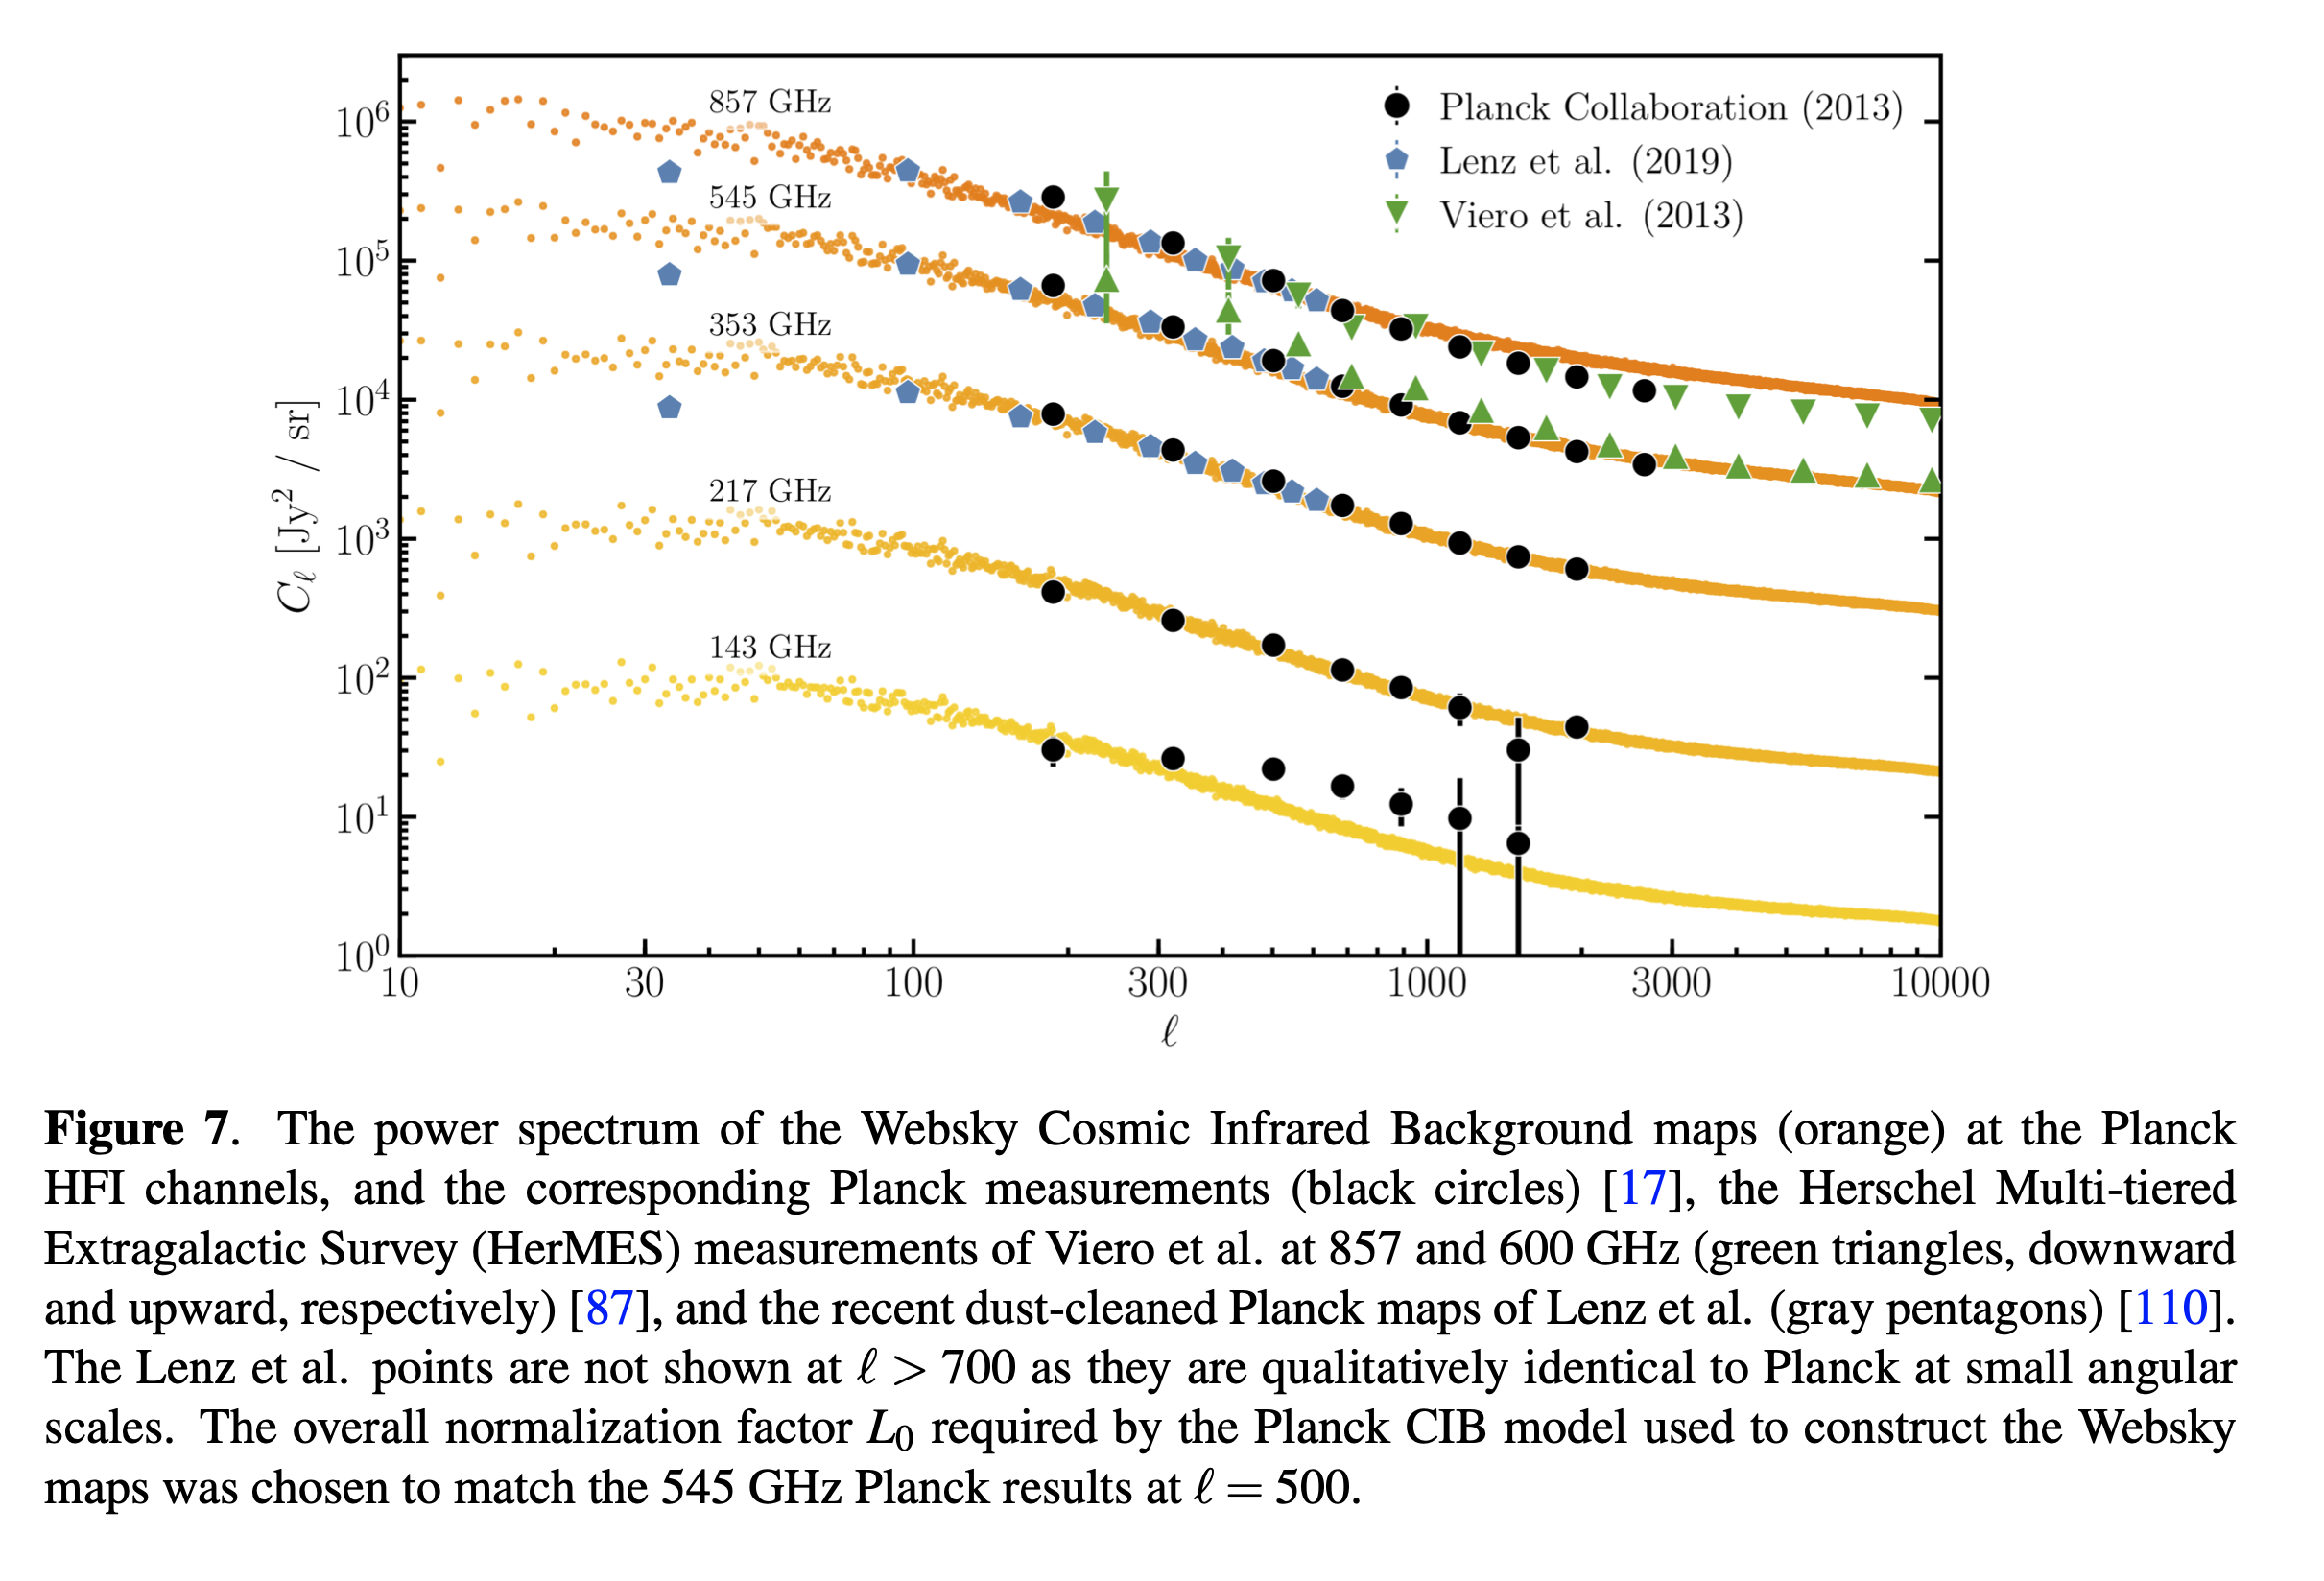

The Planck measurments here are different they are from Planck Collaboration, P. A. R. Ade, N. Aghanim, C. Armitage-Caplan, M. Arnaud, M. Ashdown et al.,
Planck 2013 results. XXX. Cosmic infrared background measurements and implications for star formation, A&A 571 (2014) A30 [1309.0382].
https://arxiv.org/pdf/1309.0382.pdf


CCL-class_sz-Fiona/Mat benchmark computation by running: <br>
$ python compute_and_plot_cib_simple.py -param_name 'h' -p_val '[0.6711]' -output 'cib_cib_1h,cib_cib_2h' -plot_cib_cib yes -save_figure yes -mode run

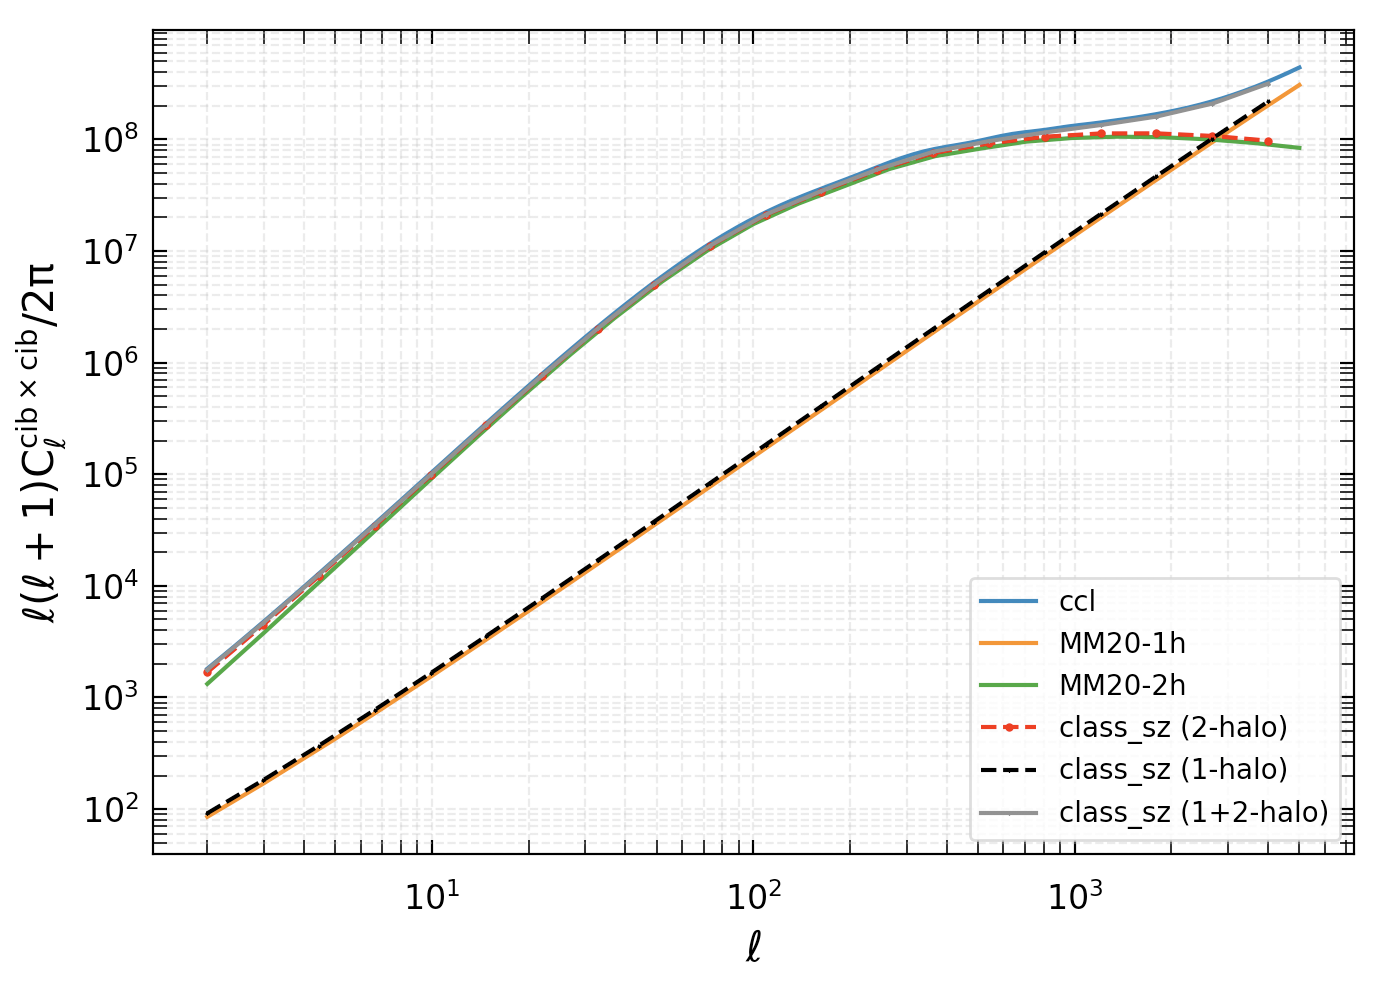

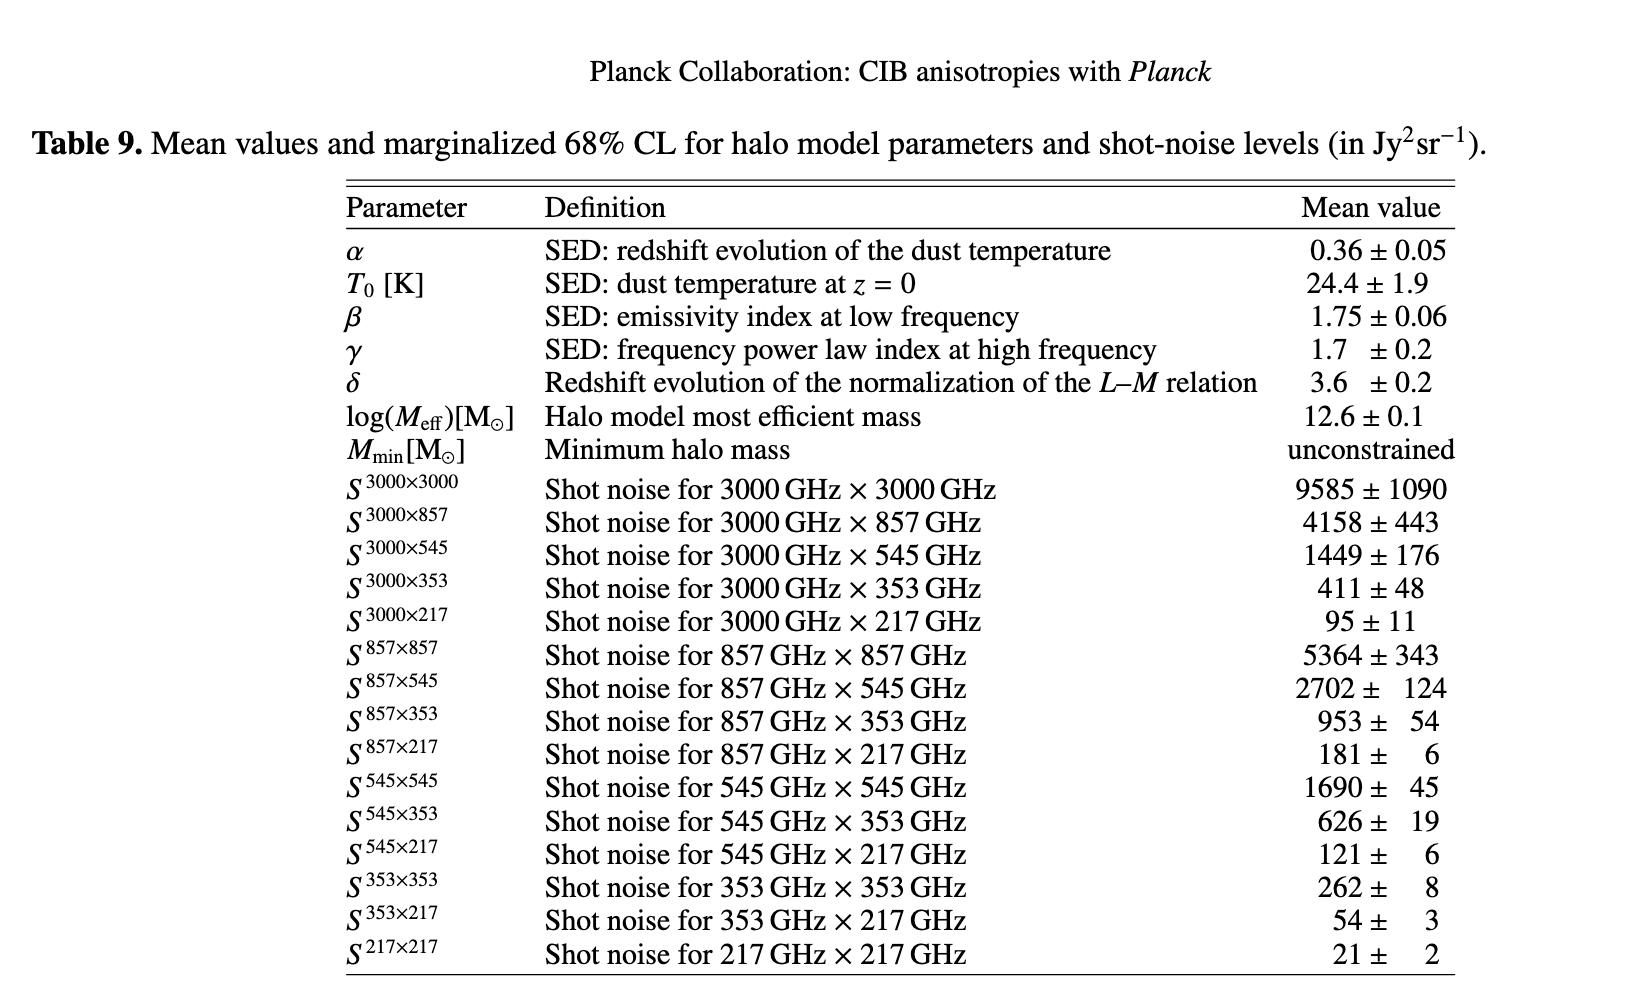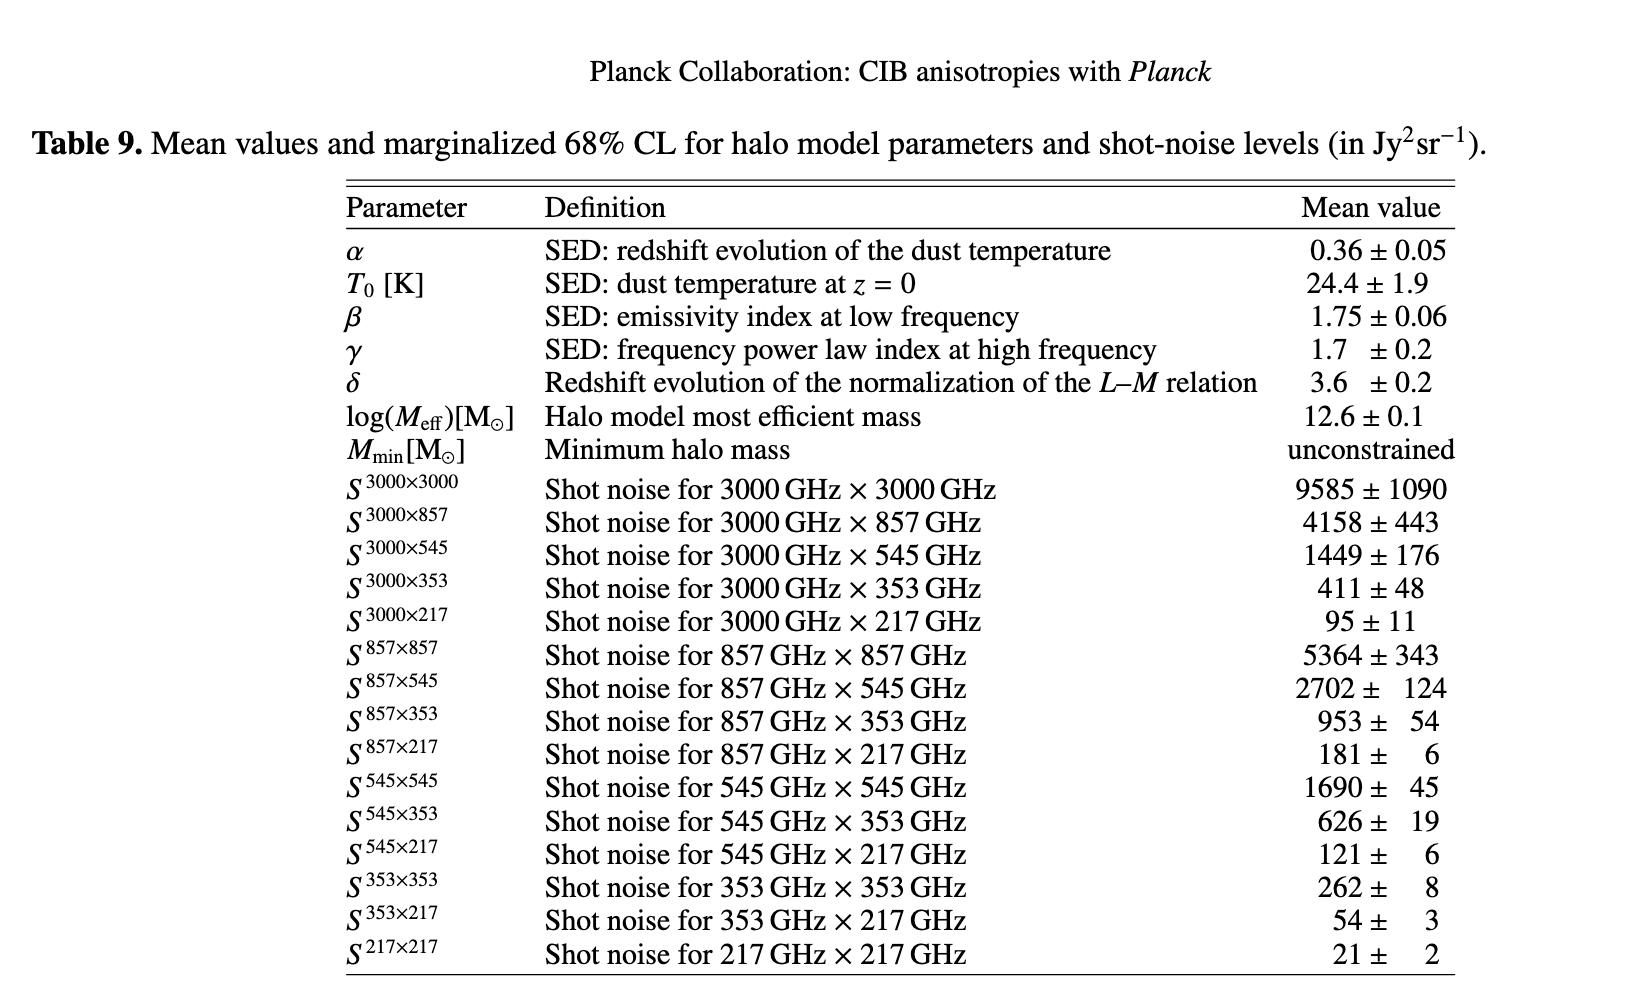

![colcorr_plc.png](colcorr_plc.png)

# Compute sz and cib in the fiducial planck model

## fiona params:

In [11]:
M_sz_ccl = Class()
# M_sz_ccl.set({'output':'tSZ_1h,tSZ_2h,cib_cib_1h,cib_cib_2h,tSZ_cib_1h,tSZ_cib_2h,lens_lens_1h,lens_lens_2h,lens_cib_1h,lens_cib_2h'})
M_sz_ccl.set({'output':'cib_cib_1h,cib_cib_2h'})
M_sz_ccl.set({
# parameters for Cosmology
'Omega_cdm' : 0.3175-0.022068/0.6711/0.6711,
'omega_b' : 0.022068,
'h' : 0.6711,
'A_s' : 2.2e-9,
'n_s' : .9624,
'k_pivot' : 0.05,


'N_ncdm' : 1,
'N_ur' : 0.00641,
'deg_ncdm' : 3,
'm_ncdm' : 0.02,
'T_ncdm' : 0.71611

})

# M_sz_ccl.set(common_settings)
# M_sz_ccl.set(websky_cosmo)
# M_sz_ccl.set(tsz_params)
# M_sz_ccl.set(cib_params)
M_sz_ccl.set({'delta for cib':'200m'})
M_sz_ccl.set({
'M_min' : 1e8*websky_cosmo['h'], # was 1e10
'M_max' : 1e16*websky_cosmo['h'],
# 'z_min' : 1e-5, # was 1e-5
'z_min' : 0.07,
'z_max' : 6.,
'z_max_pk' : 6.,
'ell_min': 10.,
'ell_max':5e4,
'dlogell':0.2,  
'damping_1h_term' : 0,
    
# 'pressure profile': 'Custom. GNFW',
# 'P0GNFW' : 6.41,
# 'c500' : 1.81,
# 'gammaGNFW' : 0.31,
# 'alphaGNFW' : 1.33,
# 'betaGNFW' : 4.13,
# 'x_outSZ' : 4.,

# 'mass function' : 'T08M200c',
'mass function' : 'T10',
'concentration parameter': 'D08',
'B' : 1.2,

    
'cib_frequency_list_num' : 5,
'cib_frequency_list_in_GHz' : '353,143,217,545,857',  
# table 1 of https://arxiv.org/pdf/1309.0382.pdf
#1: freq GHz 2: Flux cut mJy
# 100 - 400
# 143 - 350
# 217 - 225
# 353 - 315
# 545 - 350
# 857 - 710
# 3000  - 1000
'cib_Snu_cutoff_list [mJy]':'315,350,225,350,857',    
    

'hm_consistency':1,
'redshift_epsabs' : 1e-40,#1.e-40
'redshift_epsrel' : 1e-4,#1.e-10 # fiducial value 1e-8
'mass_epsabs' : 1e-40, #1.e-40
'mass_epsrel' : 1e-4,#1e-10
'M_min_HOD' : pow(10.,10),
'dlogell' : 0.4,
'ell_max' : 15000.,
'ell_min' : 2.,




# CIB parametes see McCarthy & Madhavacheril 2020
'Redshift evolution of dust temperature' :  0.36,
'Dust temperature today in Kelvins' : 24.4,
'Emissivity index of sed' : 1.75,
'Power law index of SED at high frequency' : 1.7,
'Redshift evolution of L − M normalisation' : 3.6,
'Most efficient halo mass in Msun' : pow(10.,12.6),
'Normalisation of L − M relation in [Jy MPc2/Msun]' : 6.4e-8,
'Size of of halo masses sourcing CIB emission' : 0.5,
'has_cib_flux_cut' : 1,
    
    
'L_sat_epsabs' : 1e-40, #1.e-40
'L_sat_epsrel' : 1e-3,#1e-10
'n_nu_L_sat': 300,
'freq_min' : 1e2, # important for tabulation of Lsat
'freq_max' : 1e3, # important for tabulation of Lsat
})
# M_sz_ccl.set(websky_cib_params)
M_sz_ccl.compute()

In [12]:
cl_cib_ccl = M_sz_ccl.cl_cib_cib()

In [13]:
cl_sz_ccl = M_sz_ccl.cl_sz()

cl_tsz_cib_ccl = M_sz_ccl.cl_tSZ_cib()
cl_k_ccl = M_sz_ccl.cl_kk()
cl_k_cib_ccl =M_sz_ccl.cl_lens_cib()

In [14]:
freq = '217x217'
cl_cib_ccl[freq]['2h'][:5]

[83.56230136739039,
 222.71369954032775,
 616.892644966977,
 1750.1086725347666,
 5016.964315158874]

## websky params:

In [3]:
L0_websky = 4.461102571695613e-07

In [16]:
M_websky = Class()
M_websky.set({'output':'cib_cib_1h,cib_cib_2h'})
M_websky.set(common_settings)
M_websky.set(websky_cosmo)
M_websky.set(websky_cib_params)

M_websky.set({'Normalisation of L − M relation in [Jy MPc2/Msun]' :L0_websky,
'cib_frequency_list_num' : 5,
'cib_frequency_list_in_GHz' : '353,143,217,545,857',  
# table 1 of https://arxiv.org/pdf/1309.0382.pdf
#1: freq GHz 2: Flux cut mJy
# 100 - 400
# 143 - 350
# 217 - 225
# 353 - 315
# 545 - 350
# 857 - 710
# 3000  - 1000
'cib_Snu_cutoff_list [mJy]':'315,350,225,350,857',   
        'has_cib_flux_cut': 1
      })
M_websky.compute()
cl_cib_cib_flux_cut = M_websky.cl_cib_cib()

In [17]:
cl_cib_websky = M_websky.cl_cib_cib()

quick favor/question: can you compute the 217 GHz CIB power spectrum using the model in CLASS_SZ?  that model is the same one as used in the Planck CIB analysis, right? https://arxiv.org/abs/1309.0382

In [18]:
planck_2013 ={
'217x217':{
'cl' : np.asarray([
1.78e3, # < this is an upper bound
8.47e2, # < this is an upper bound
4.17e2, 
2.62e2, 
1.75e2, 
1.17e2, 
8.82e1, 
6.42e1, 
3.34e1, 
4.74e1
]),
'ecl' : np.asarray([
0.,
0., 
0.47e2, 
0.20e2, 
0.13e2, 
0.10e2, 
0.89e1, 
1.61e1, 
2.15e1, 
0.65e1
]),
'ell': np.asarray([
53,
114,
187,
320, 
502, 
684, 
890,
1158, 
1505,
1956
])
}
}

In [19]:
freq_cib_1 = '217'
freq_cib_2 = '217'
L_ref = np.loadtxt(path_to_class + 'sz_auxiliary_files/cib_files/cib_1h_'+str(int(freq_cib_1))+'x'+str(int(freq_cib_2))+'.txt')
ell_MM20 = L_ref[:,0]
cl_cib_cib_1h_MM20 = L_ref[:,1]
L_ref = np.loadtxt(path_to_class + 'sz_auxiliary_files/cib_files/cib_2h_'+str(int(freq_cib_1))+'x'+str(int(freq_cib_2))+'.txt')
cl_cib_cib_2h_MM20 = L_ref[:,1]

## dr4 cib

In [20]:
dr4_params_dict = {
# Amplitude of clustered CIB
'a_c':    0.3648102e1,
# Amplitude of Poisson CIB
'a_d':    0.6872966e1,
'Tdust_CIB' : 9.7, # same as f90
'nu0_CIB_ghz' : 150., # same as f90
# Tdust_CIB: 24.0       #CIB effective dust temperature [K] (Table 9 of http://www.aanda.org/articles/aa/pdf/2014/11/aa22093-13.pdf)
# beta_CIB: 1.2         #CIB modified blackbody spectral index (Table 9 of http://www.aanda.org/articles/aa/pdf/2014/11/aa22093-13.pdf ; Table 10 of that paper contains CIB monopoles)
'beta_CIB': 0.2447908e1,
# nu0_CIB_ghz: 353.0    #CIB pivot frequency [GHz]
# The power law index in multipole space for clustered CIB
# cib ~  l(l+1) l^n
'cibc_n' : -1.2,

'cib_temp_file' : '/Users/boris/Work/CLASS-SZ/SO-SZ/bplike/data/actpolfull_dr4.01/data/Fg/cib_extra.dat',
'high_ell0' : 3000
}

from scipy.interpolate import interp1d
def get_template(ells,template_file,ell_pivot=None):
    ls,pow = np.loadtxt(template_file,unpack=True)
    powfunc = interp1d(ls,pow)
    if ell_pivot is not None:
        pow_pivot = powfunc(ell_pivot)
    else:
        pow_pivot = 1.
    return powfunc(ells)/pow_pivot

In [21]:
ells = np.arange(2,5000)
cib_temp = get_template(ells,dr4_params_dict['cib_temp_file'],ell_pivot=3000)
# cibp_temp = (ells*(ells+1.)/(dr4_params_dict['high_ell0']*(dr4_params_dict['high_ell0']+1.)))

In [22]:
import bplike as bp

here are just the relevant bplike functions

In [ ]:
def get_power(self,spec,comps,params,
                  eff_freq_ghz1=None,array1=None,
                  eff_freq_ghz2=None,array2=None,lmax=None,ptsz=None):
    ocomps = [comp.lower() for comp in comps]
    spec = spec.lower()
    tpow = 0

    if ('cibc' in ocomps) or ('cibp' in ocomps):
        e1dusty = eff_freq_ghz1['dust'] if eff_freq_ghz1 is not None else None
        e2dusty = eff_freq_ghz2['dust'] if eff_freq_ghz2 is not None else None
        f1_cib = self.get_response("CIB",array=array1,norm_freq_ghz=params['nu0'],
                                   eff_freq_ghz=e1dusty,params=params,lmax=lmax)
        f2_cib = self.get_response("CIB",array=array2,norm_freq_ghz=params['nu0'],
                                   eff_freq_ghz=e2dusty,params=params,lmax=lmax)
        if (f2_cib.size<lmax and f2_cib.size>1):
            new_f2 = np.zeros(lmax)
            new_f2[:f2_cib.size] = f2_cib
            f2_cib = new_f2
            new_f2[f2_cib.size:] = np.repeat(f2_cib[f2_cib.size-1], lmax-f2_cib.size)
        if (f1_cib.size<lmax and f1_cib.size>1):
            new_f1 = np.zeros(lmax)
            new_f1[:f1_cib.size] = f1_cib
            new_f1[f1_cib.size:] = np.repeat(f1_cib[f1_cib.size-1], lmax-f1_cib.size)
            f1_cib = new_f1
    if ('cibc' in ocomps):
        tpow = tpow + f1_cib*f2_cib*params['a_c']*self.get_component_scale_dependence('cibc',params)
    if ('cibp' in ocomps):
        tpow = tpow + f1_cib*f2_cib*params['a_d']*self.get_component_scale_dependence('poisson',params)
    return tpow

def get_component_scale_dependence(self,comp,param_dict):
    p = param_dict
    comp = comp.lower()
    if comp == 'tsz':
        return self.tsz_tempi
    
    elif comp == 'ksz':
        return self.ksz_temp
    elif comp=='tsz_x_cib':
        return self.tsz_x_cib_temp
    # elif comp=='cibc':
    #     return self.cib_temp
    elif comp=='cibc':
        return self.ells * (self.ells+1) / p['high_ell0'] / (p['high_ell0']+1.) * (self.ells / p['high_ell0'])**p['cibc_n']
    elif comp=='poisson':
        return self.ells * (self.ells+1) / p['high_ell0'] / (p['high_ell0']+1.)




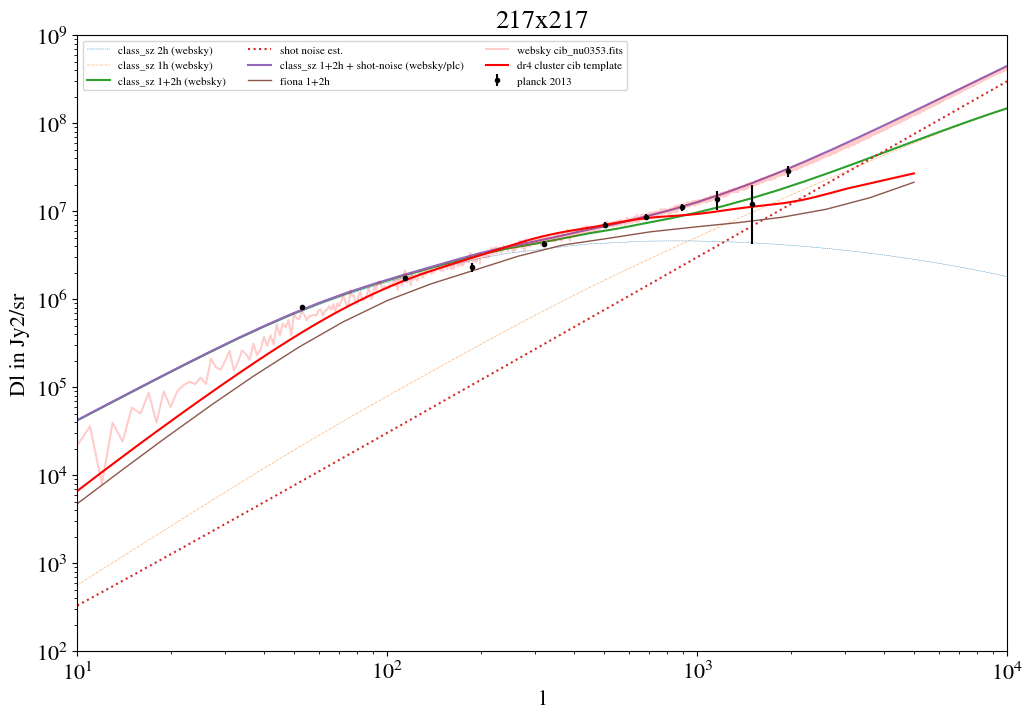

In [37]:
freq = '217x217'

fig, (ax) = plt.subplots(1,1,figsize=(12,8))
l = np.asarray(cl_cib_ccl[freq]['ell'])
# facdl = l*(l+1.)/2./np.pi
# plt.plot(l,np.asarray(cl_cib_ccl[freq]['2h']),#/facdl,
#          label = 'class_sz 2h',lw=0.3)
# plt.plot(l,np.asarray(cl_cib_ccl[freq]['1h']),#/facdl,
#          label = 'class_sz 1h',lw=0.3)

l = np.asarray(cl_cib_websky[freq]['ell'])
facdl = l*(l+1.)/2./np.pi
plt.plot(l,np.asarray(cl_cib_websky[freq]['2h']),#/facdl,
         label = 'class_sz 2h (websky)',lw=0.3,ls='--')
plt.plot(l,np.asarray(cl_cib_websky[freq]['1h']),#/facdl,
         label = 'class_sz 1h (websky)',lw=0.3,ls='-.')
plt.plot(l,np.asarray(cl_cib_websky[freq]['1h'])+np.asarray(cl_cib_websky[freq]['2h']),#/facdl,
         label = 'class_sz 1+2h (websky)')

plt.plot(l,19.*l*(l+1.)/2./np.pi,label='shot noise est.',ls=':')

plt.plot(l,19.*l*(l+1.)/2./np.pi+np.asarray(cl_cib_websky[freq]['1h'])+np.asarray(cl_cib_websky[freq]['2h']),#/facdl,
         
         label = 'class_sz 1+2h + shot-noise (websky/plc)')

ffacdl =ell_MM20*(ell_MM20+1.)/2./np.pi
# plt.plot(ell_MM20,cl_cib_cib_1h_MM20,#/ffacdl,
#          label='fiona 1h',lw=0.3)
# plt.plot(ell_MM20,cl_cib_cib_2h_MM20,#/ffacdl,
#          label='fiona 2h',lw=0.3)

plt.plot(ell_MM20,cl_cib_cib_1h_MM20+cl_cib_cib_2h_MM20,#/ffacdl,
         label='fiona 1+2h',lw=1.)

pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'],
             planck_2013[freq]['cl']*pfacdl,
             yerr=planck_2013[freq]['ecl']*pfacdl,
             marker= 'o',
             markersize=3.,
             ls='None',
             c='k',
             label = 'planck 2013')


ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_217_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12*ls_ws*(ls_ws+1.)/2./np.pi,
         alpha=0.2,
         c='r',
         label='websky cib_nu0353.fits')

ells = np.arange(2,5000)
cib_temp = get_template(ells,dr4_params_dict['cib_temp_file'],ell_pivot=3000)
plt.plot(ells,1.8e7*cib_temp,label='dr4 cluster cib template',c='r')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=8,ncol=3)
plt.ylabel('Dl in Jy2/sr')
plt.xlabel('l')
plt.title(freq)
plt.xlim(1e1,1e4)
plt.ylim(1e2,1e9)
plt.savefig('cibs_at_217ghz_sn.pdf')

(10.0, 10000.0)

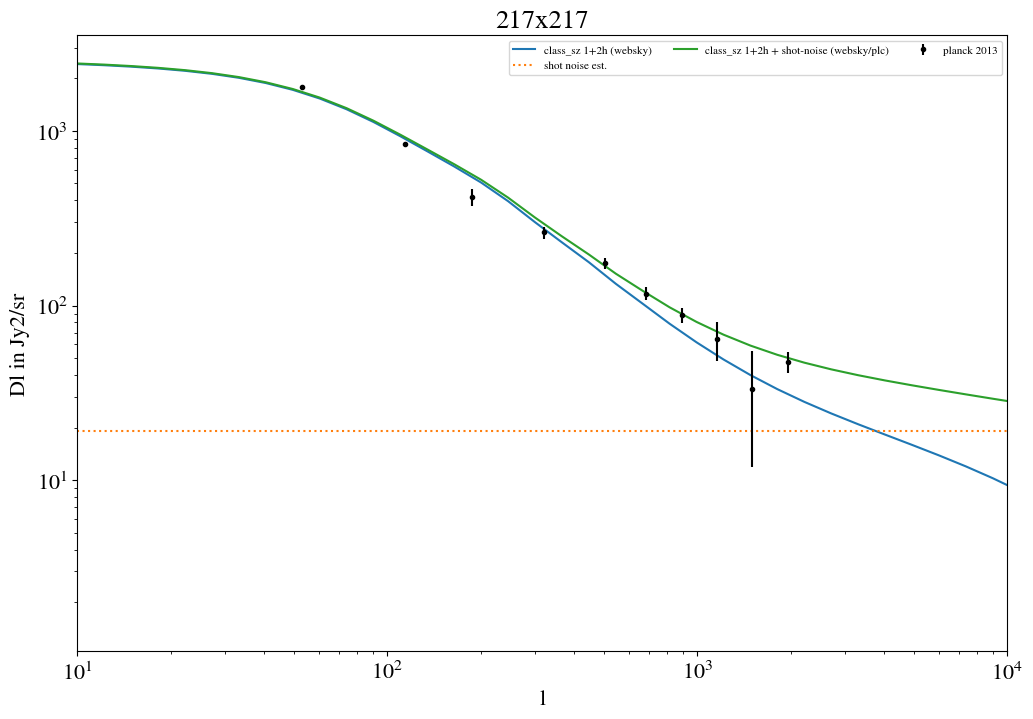

In [47]:
freq = '217x217'

fig, (ax) = plt.subplots(1,1,figsize=(12,8))
l = np.asarray(cl_cib_ccl[freq]['ell'])
# facdl = l*(l+1.)/2./np.pi
# plt.plot(l,np.asarray(cl_cib_ccl[freq]['2h']),#/facdl,
#          label = 'class_sz 2h',lw=0.3)
# plt.plot(l,np.asarray(cl_cib_ccl[freq]['1h']),#/facdl,
#          label = 'class_sz 1h',lw=0.3)

l = np.asarray(cl_cib_websky[freq]['ell'])
facdl = l*(l+1.)/2./np.pi
# plt.plot(l,np.asarray(cl_cib_websky[freq]['2h'])/facdl,
#          label = 'class_sz 2h (websky)',lw=0.3,ls='--')
# plt.plot(l,np.asarray(cl_cib_websky[freq]['1h'])/facdl,
#          label = 'class_sz 1h (websky)',lw=0.3,ls='-.')
plt.plot(l,np.asarray(cl_cib_websky[freq]['1h'])/facdl+np.asarray(cl_cib_websky[freq]['2h'])/facdl,
         label = 'class_sz 1+2h (websky)')

plt.plot(l,19.*l/l,label='shot noise est.',ls=':')

plt.plot(l,19.*l/l+np.asarray(cl_cib_websky[freq]['1h'])/facdl+np.asarray(cl_cib_websky[freq]['2h'])/facdl,
         
         label = 'class_sz 1+2h + shot-noise (websky/plc)')

# ffacdl =ell_MM20*(ell_MM20+1.)/2./np.pi
# # plt.plot(ell_MM20,cl_cib_cib_1h_MM20,#/ffacdl,
# #          label='fiona 1h',lw=0.3)
# # plt.plot(ell_MM20,cl_cib_cib_2h_MM20,#/ffacdl,
# #          label='fiona 2h',lw=0.3)

# plt.plot(ell_MM20,cl_cib_cib_1h_MM20+cl_cib_cib_2h_MM20,#/ffacdl,
#          label='fiona 1+2h',lw=1.)

pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'],
             planck_2013[freq]['cl'],
             yerr=planck_2013[freq]['ecl'],
             marker= 'o',
             markersize=3.,
             ls='None',
             c='k',
             label = 'planck 2013')


# ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_217_websky_l_cl_090322.txt',unpack=True)
# plt.plot(ls_ws,cls_ws*1e12*ls_ws*(ls_ws+1.)/2./np.pi,
#          alpha=0.2,
#          c='r',
#          label='websky cib_nu0353.fits')

ells = np.arange(2,5000)
cib_temp = get_template(ells,dr4_params_dict['cib_temp_file'],ell_pivot=3000)
# plt.plot(ells,1.8e7*cib_temp,label='dr4 cluster cib template',c='r')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=8,ncol=3)
plt.ylabel('Dl in Jy2/sr')
plt.xlabel('l')
plt.title(freq)
plt.xlim(1e1,1e4)
# plt.ylim(1e2,1e9)
# plt.savefig('cibs_at_217ghz_sn.pdf')

In [38]:
# cl_cib_ccl

## dunkley et al cib

In [23]:
ac = 4.9
ap = 6.9
bc = 2.2

dunk_params_dict = {
# Amplitude of clustered CIB
'a_c':    ac,
# Amplitude of Poisson CIB
'a_d':   ap,
'Tdust_CIB' : 9.7, # same as f90
'nu0_CIB_ghz' : 150., # same as f90
# Tdust_CIB: 24.0       #CIB effective dust temperature [K] (Table 9 of http://www.aanda.org/articles/aa/pdf/2014/11/aa22093-13.pdf)
# beta_CIB: 1.2         #CIB modified blackbody spectral index (Table 9 of http://www.aanda.org/articles/aa/pdf/2014/11/aa22093-13.pdf ; Table 10 of that paper contains CIB monopoles)
'beta_CIB': bc,
# nu0_CIB_ghz: 353.0    #CIB pivot frequency [GHz]
# The power law index in multipole space for clustered CIB
# cib ~  l(l+1) l^n
'cibc_n' : -1.2,

'cib_temp_file' : '/Users/boris/Work/CLASS-SZ/SO-SZ/bplike/data/actpolfull_dr4.01/data/Fg/cib_extra.dat',
'high_ell0' : 3000
}

In [24]:
choi_params_dict = {
# Amplitude of clustered CIB
'a_c':    3.15,
# # Amplitude of Poisson CIB
'a_d':   6.58,
'Tdust_CIB' : 9.7, # same as f90
'nu0_CIB_ghz' : 150., # same as f90
# Tdust_CIB: 24.0       #CIB effective dust temperature [K] (Table 9 of http://www.aanda.org/articles/aa/pdf/2014/11/aa22093-13.pdf)
# beta_CIB: 1.2         #CIB modified blackbody spectral index (Table 9 of http://www.aanda.org/articles/aa/pdf/2014/11/aa22093-13.pdf ; Table 10 of that paper contains CIB monopoles)
'beta_CIB': 2.87,
# nu0_CIB_ghz: 353.0    #CIB pivot frequency [GHz]
# The power law indsex in multipole space for clustered CIB
# cib ~  l(l+1) l^n
'cibc_n' : -1.2,

'cib_temp_file' : '/Users/boris/Work/CLASS-SZ/SO-SZ/bplike/data/actpolfull_dr4.01/data/Fg/cib_extra.dat',
'high_ell0' : 3000
}

In [ ]:
# dr4_params_dict = {
# # Amplitude of clustered CIB
# 'a_c':    0.3648102e1,
# # Amplitude of Poisson CIB
# 'a_d':    0.6872966e1,
# 'Tdust_CIB' : 9.7, # same as f90
# 'nu0_CIB_ghz' : 150., # same as f90
# # Tdust_CIB: 24.0       #CIB effective dust temperature [K] (Table 9 of http://www.aanda.org/articles/aa/pdf/2014/11/aa22093-13.pdf)
# # beta_CIB: 1.2         #CIB modified blackbody spectral index (Table 9 of http://www.aanda.org/articles/aa/pdf/2014/11/aa22093-13.pdf ; Table 10 of that paper contains CIB monopoles)
# 'beta_CIB': 0.2447908e1,
# # nu0_CIB_ghz: 353.0    #CIB pivot frequency [GHz]
# # The power law index in multipole space for clustered CIB
# # cib ~  l(l+1) l^n
# 'cibc_n' : -1.2,

# 'cib_temp_file' : '/Users/boris/Work/CLASS-SZ/SO-SZ/bplike/data/actpolfull_dr4.01/data/Fg/cib_extra.dat',
# 'high_ell0' : 3000
# }

In [25]:
TCMB = 2.725 #Kelvin # 2.725 value in choi et al
TCMB_uK = 2.725e6 #micro-Kelvin # 2.725 value in choi et al 


hplanck=6.626068e-34 #MKS
kboltz=1.3806503e-23 #MKS
clight=299792458.0 #MKS
m_elec = 510.999 #keV

# function needed for Planck bandpass integration/conversion following approach in Sec. 3.2 of https://arxiv.org/pdf/1303.5070.pdf
# blackbody derivative
# units are 1e-26 Jy/sr/uK_CMB
def dBnudT(nu_ghz):
    nu = 1.e9*np.asarray(nu_ghz)
    X = hplanck*nu/(kboltz*TCMB)
    return (2.*hplanck*nu**3.)/clight**2. * (np.exp(X))/(np.exp(X)-1.)**2. * X/TCMB_uK

# conversion from specific intensity to Delta T units (i.e., 1/dBdT|T_CMB)
#   i.e., from W/m^2/Hz/sr (1e-26 Jy/sr) --> uK_CMB
#   i.e., you would multiply a map in 1e-26 Jy/sr by this factor to get an output map in uK_CMB
def ItoDeltaT(nu_ghz):
    return 1./dBnudT(nu_ghz)

In [26]:

def get_mu(p,nu_ghz):
        nu = 1.e9*np.asarray(nu_ghz).astype(float)
        X_CIB = hplanck*nu/(kboltz*(p['Tdust_CIB']))
        nu0_CIB = p['nu0_CIB_ghz']*1.e9
        dust_beta_param_name = 'beta_CIB'
        X0_CIB = hplanck*nu0_CIB/(kboltz*(p['Tdust_CIB']))
        resp = (nu/nu0_CIB)**(3.0+(p[dust_beta_param_name])) * ((np.exp(X0_CIB) - 1.0) / (np.exp(X_CIB) - 1.0)) * (ItoDeltaT(np.asarray(nu_ghz).astype(float))/ItoDeltaT(p['nu0_CIB_ghz']))
        resp[np.where(nu_ghz == None)] = 0. #this case is appropriate for HI or other maps that contain no CMB-relevant signals (and also no CIB); they're assumed to be denoted by None in nu_ghz
        return resp

In [27]:
l = np.arange(2,5000)
l0 = 3000
cibc = dunk_params_dict['a_c']*(l/l0)**(2+dunk_params_dict['cibc_n'])*get_mu(dunk_params_dict,[217])**2.
cibp = dunk_params_dict['a_d']*(l/l0)**(2)*get_mu(dunk_params_dict,[217])**2.

In [28]:
get_mu(dunk_params_dict,[150.])

array([1.])

In [29]:
cibc

array([ 0.14550654,  0.2012591 ,  0.2533416 , ..., 76.0371785 ,
       76.04935151, 76.06152403])

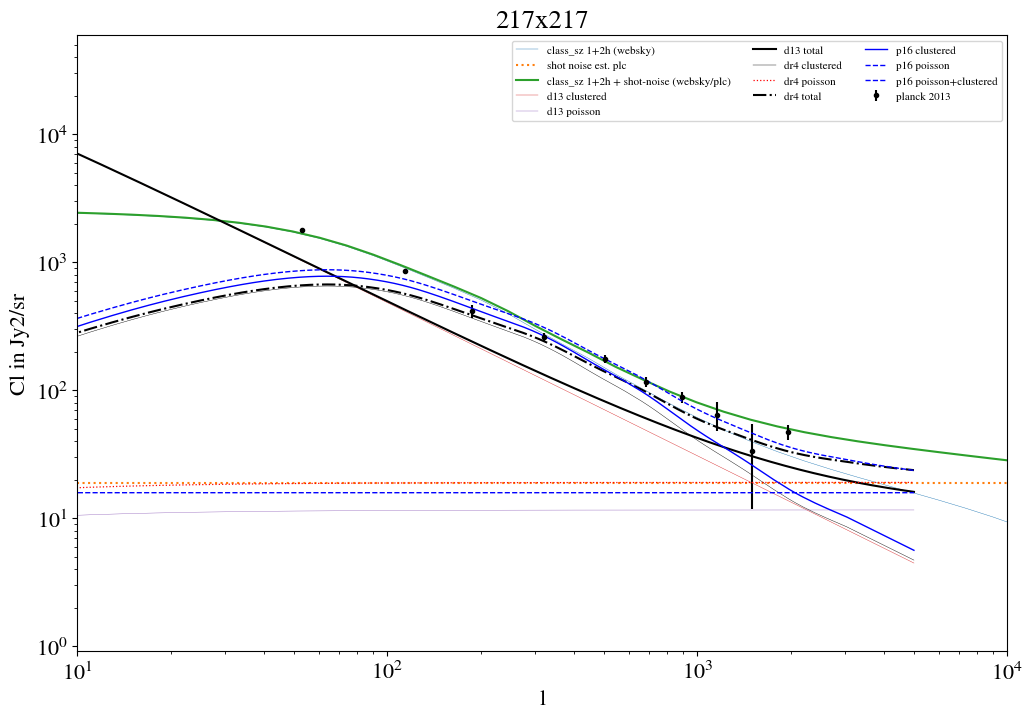

In [135]:
# freq = '217x217'

fig, (ax) = plt.subplots(1,1,figsize=(12,8))
l = np.asarray(cl_cib_ccl[freq]['ell'])
# facdl = l*(l+1.)/2./np.pi
# plt.plot(l,np.asarray(cl_cib_ccl[freq]['2h']),#/facdl,
#          label = 'class_sz 2h',lw=0.3)
# plt.plot(l,np.asarray(cl_cib_ccl[freq]['1h']),#/facdl,
#          label = 'class_sz 1h',lw=0.3)

l = np.asarray(cl_cib_websky[freq]['ell'])
facdl = l*(l+1.)/2./np.pi
# plt.plot(l,np.asarray(cl_cib_websky[freq]['2h'])/facdl,
#          label = 'class_sz 2h (websky)',lw=0.3,ls='--')
# plt.plot(l,np.asarray(cl_cib_websky[freq]['1h'])/facdl,
#          label = 'class_sz 1h (websky)',lw=0.3,ls='-.')
plt.plot(l,np.asarray(cl_cib_websky[freq]['1h'])/facdl+np.asarray(cl_cib_websky[freq]['2h'])/facdl,lw=0.3,
         label = 'class_sz 1+2h (websky)')

plt.plot(l,19.*l/l,label='shot noise est. plc',ls=':')

plt.plot(l,19.*l/l+np.asarray(cl_cib_websky[freq]['1h'])/facdl+np.asarray(cl_cib_websky[freq]['2h'])/facdl,
         
         label = 'class_sz 1+2h + shot-noise (websky/plc)')

# ffacdl =ell_MM20*(ell_MM20+1.)/2./np.pi
# # plt.plot(ell_MM20,cl_cib_cib_1h_MM20,#/ffacdl,
# #          label='fiona 1h',lw=0.3)
# # plt.plot(ell_MM20,cl_cib_cib_2h_MM20,#/ffacdl,
# #          label='fiona 2h',lw=0.3)

# plt.plot(ell_MM20,cl_cib_cib_1h_MM20+cl_cib_cib_2h_MM20,#/ffacdl,
#          label='fiona 1+2h',lw=1.)

pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'],
             planck_2013[freq]['cl'],
             yerr=planck_2013[freq]['ecl'],
             marker= 'o',
             markersize=3.,
             ls='None',
             c='k',
             label = 'planck 2013')


# ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_217_websky_l_cl_090322.txt',unpack=True)
# plt.plot(ls_ws,cls_ws*1e12*ls_ws*(ls_ws+1.)/2./np.pi,
#          alpha=0.2,
#          c='r',
#          label='websky cib_nu0353.fits')
l = np.arange(2,5000)
l0 = 3000
cibc = dunk_params_dict['a_c']*(l/l0)**(2+dunk_params_dict['cibc_n'])*get_mu(dunk_params_dict,[217])**2.
cibp = dunk_params_dict['a_d']*(l/l0)**(2)*get_mu(dunk_params_dict,[217])**2.


plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibc*(483.690)**2.,label='d13 clustered',lw=0.3)


plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(483.690)**2.,label='d13 poisson',lw=0.3)
plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(483.690)**2.+(l*(l+1)/2./np.pi)**-1.*cibc*(483.690)**2.,label='d13 total',c='k')


ells = np.arange(2,5000)
cib_temp = get_template(ells,dr4_params_dict['cib_temp_file'],ell_pivot=3000)
plt.plot(ells,choi_params_dict['a_c']*cib_temp/(ells*(ells+1.)/2./np.pi)*(483.690)**2.*get_mu(choi_params_dict,[217])**2.,label='dr4 clustered',c='k',lw=0.3)

l = np.arange(2,5000)
cibp = choi_params_dict['a_d']*(l/l0)**(2)*get_mu(choi_params_dict,[217])**2.
plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(483.690)**2.,label='dr4 poisson',lw=0.9,c='r',ls=':')

plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(483.690)**2.+choi_params_dict['a_c']*cib_temp/(ells*(ells+1.)/2./np.pi)*(483.690)**2.*get_mu(choi_params_dict,[217])**2.,
         label='dr4 total',c='k',ls='-.')



ells = np.arange(2,5000)
cib_temp = get_template(ells,dr4_params_dict['cib_temp_file'],ell_pivot=3000)
# plt.plot(ells,0.89*63.6*cib_temp/(ells*(ells+1.)/2./np.pi)*(483.690)**2.,label='p16 clustered',c='blue',lw=1.)
plt.plot(ells,63.6*cib_temp/(ells*(ells+1.)/2./np.pi)*(483.690)**2.,label='p16 clustered',c='blue',lw=1.)

# plt.plot(ells,0.89*63.6*cib_temp/(ells*(ells+1.)/2./np.pi)*(483.690)**2.,label='p16 clustered',c='blue',lw=1.)
plt.plot(ells,97.10/(3000*(3000+1.)/2./np.pi)*cib_temp/cib_temp*(483.690)**2.,label='p16 poisson',c='blue',lw=1.,ls='--')

plt.plot(ells,107.10/(3000*(3000+1.)/2./np.pi)*cib_temp/cib_temp*(483.690)**2.+70*cib_temp/(ells*(ells+1.)/2./np.pi)*(483.690)**2.,label='p16 poisson+clustered',c='blue',lw=1.,ls='--')


plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=8,ncol=3)
plt.ylabel('Cl in Jy2/sr')
plt.xlabel('l')
plt.title(freq)
plt.xlim(1e1,1e4)
# plt.ylim(1e2,1e9)
plt.savefig('cibs_at_217ghz_dr4_dunkley13.pdf')

In [87]:
l0 = 3000
l =3000
cibc = dunk_params_dict['a_c']*(l/l0)**(2+dunk_params_dict['cibc_n'])*get_mu(dunk_params_dict,[217])**2.
cibc

array([50.55399922])

In [88]:
get_mu(dunk_params_dict,[150])

array([1.])

In [104]:
l=3000
cibp = dunk_params_dict['a_d']*(l/l0)**(2)*get_mu(dunk_params_dict,[217])**2.
cibp

array([71.18828461])

In [152]:
cib_temp_plc = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/notebooks/cib_1h_2h_100_353_Jsr-1_PS_2014_09.dat')

In [154]:
cib_temp_plc

array([ 0.    ,  0.    ,  0.    , ...,  5.3471, 22.847 , 94.907 ])

In [142]:
np.shape(cib_temp_plc)

(160016,)

[]

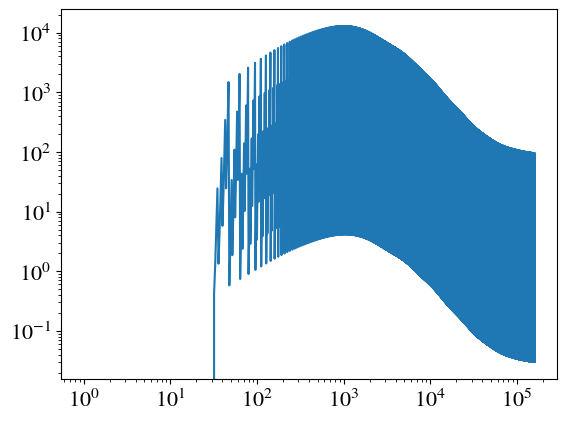

In [143]:
plt.plot(np.abs(cib_temp_plc))
plt.loglog()

In [144]:
cib_temp_plc

array([ 0.    ,  0.    ,  0.    , ...,  5.3471, 22.847 , 94.907 ])

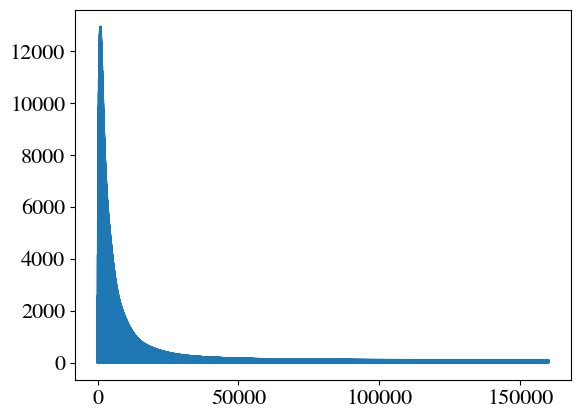

In [146]:
plt.plot(cib_temp_plc)

In [127]:
cib_temp/cib_temp

array([1., 1., 1., ..., 1., 1., 1.])

# Omori cib

In [3]:
cib_omori = np.loadtxt(path_to_files+'cls_mdpl2_v0.7_cib_planck_217ghz.dat')
cib_omori_nomask = np.loadtxt(path_to_files+'cls_mdpl2_v0.7_cib_planck_217ghz_nomask.dat')

Theres actually a small calibration factor applied to these in post processing, and I havent actually compared the Cl amplitude with anything else, but it does seem to produce the ymap amplitude better after I pass them through ILC. [JCH: this is unrelated to what we're doing -- he is discussing the contamination from CIB in tSZ power spectrum estimates]
Also these Cls are equivalent to after applying the Planck 5sigma mask.
(and the units are in uK^2)

(1e-05, 0.01)

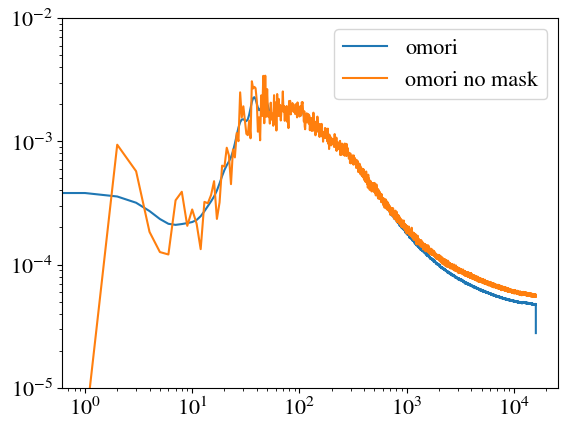

In [10]:
plt.plot(cib_omori[:,0],cib_omori[:,1],label='omori')
plt.plot(cib_omori_nomask[:,0],cib_omori_nomask[:,1],label='omori no mask')
plt.loglog()
plt.legend()
plt.ylim(1e-5,1e-2)

(1.0, 10000.0)

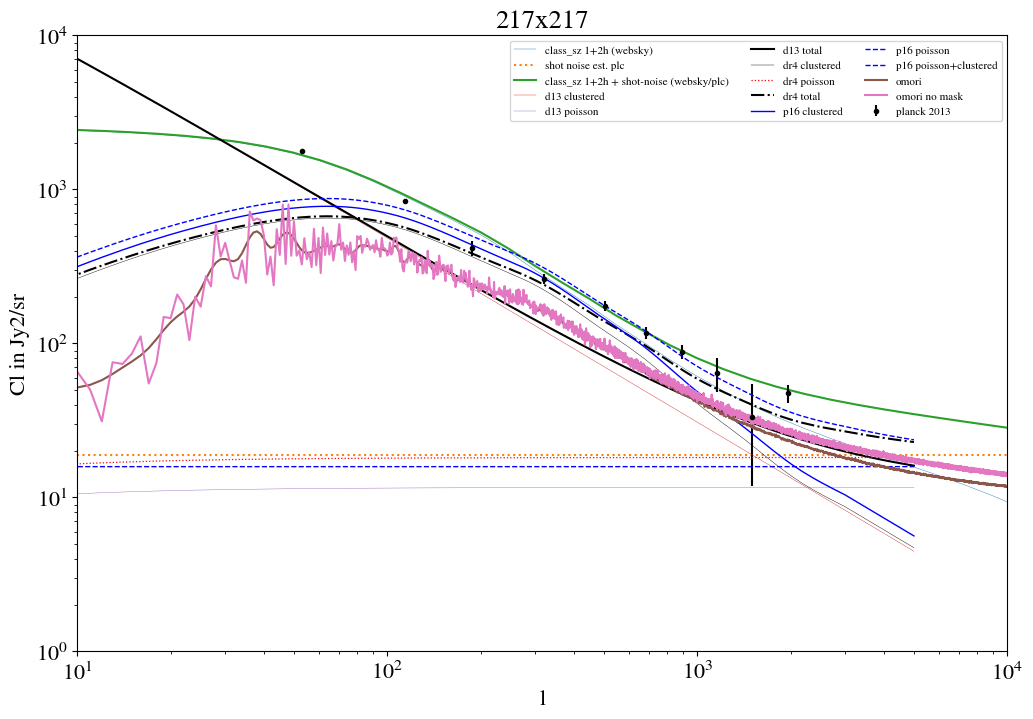

In [34]:
# freq = '217x217'

fig, (ax) = plt.subplots(1,1,figsize=(12,8))
l = np.asarray(cl_cib_ccl[freq]['ell'])
# facdl = l*(l+1.)/2./np.pi
# plt.plot(l,np.asarray(cl_cib_ccl[freq]['2h']),#/facdl,
#          label = 'class_sz 2h',lw=0.3)
# plt.plot(l,np.asarray(cl_cib_ccl[freq]['1h']),#/facdl,
#          label = 'class_sz 1h',lw=0.3)

l = np.asarray(cl_cib_websky[freq]['ell'])
facdl = l*(l+1.)/2./np.pi
# plt.plot(l,np.asarray(cl_cib_websky[freq]['2h'])/facdl,
#          label = 'class_sz 2h (websky)',lw=0.3,ls='--')
# plt.plot(l,np.asarray(cl_cib_websky[freq]['1h'])/facdl,
#          label = 'class_sz 1h (websky)',lw=0.3,ls='-.')
plt.plot(l,np.asarray(cl_cib_websky[freq]['1h'])/facdl+np.asarray(cl_cib_websky[freq]['2h'])/facdl,lw=0.3,
         label = 'class_sz 1+2h (websky)')

plt.plot(l,19.*l/l,label='shot noise est. plc',ls=':')

plt.plot(l,19.*l/l+np.asarray(cl_cib_websky[freq]['1h'])/facdl+np.asarray(cl_cib_websky[freq]['2h'])/facdl,
         
         label = 'class_sz 1+2h + shot-noise (websky/plc)')

# ffacdl =ell_MM20*(ell_MM20+1.)/2./np.pi
# # plt.plot(ell_MM20,cl_cib_cib_1h_MM20,#/ffacdl,
# #          label='fiona 1h',lw=0.3)
# # plt.plot(ell_MM20,cl_cib_cib_2h_MM20,#/ffacdl,
# #          label='fiona 2h',lw=0.3)

# plt.plot(ell_MM20,cl_cib_cib_1h_MM20+cl_cib_cib_2h_MM20,#/ffacdl,
#          label='fiona 1+2h',lw=1.)

pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'],
             planck_2013[freq]['cl'],
             yerr=planck_2013[freq]['ecl'],
             marker= 'o',
             markersize=3.,
             ls='None',
             c='k',
             label = 'planck 2013')


# ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_217_websky_l_cl_090322.txt',unpack=True)
# plt.plot(ls_ws,cls_ws*1e12*ls_ws*(ls_ws+1.)/2./np.pi,
#          alpha=0.2,
#          c='r',
#          label='websky cib_nu0353.fits')
l = np.arange(2,5000)
l0 = 3000
cibc = dunk_params_dict['a_c']*(l/l0)**(2+dunk_params_dict['cibc_n'])*get_mu(dunk_params_dict,[217])**2.
cibp = dunk_params_dict['a_d']*(l/l0)**(2)*get_mu(dunk_params_dict,[217])**2.


plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibc*(483.690)**2.,label='d13 clustered',lw=0.3)


plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(483.690)**2.,label='d13 poisson',lw=0.3)
plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(483.690)**2.+(l*(l+1)/2./np.pi)**-1.*cibc*(483.690)**2.,label='d13 total',c='k')


ells = np.arange(2,5000)
cib_temp = get_template(ells,dr4_params_dict['cib_temp_file'],ell_pivot=3000)
plt.plot(ells,choi_params_dict['a_c']*cib_temp/(ells*(ells+1.)/2./np.pi)*(483.690)**2.*get_mu(choi_params_dict,[217])**2.,label='dr4 clustered',c='k',lw=0.3)

l = np.arange(2,5000)
cibp = choi_params_dict['a_d']*(l/l0)**(2)*get_mu(choi_params_dict,[217])**2.
plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(483.690)**2.,label='dr4 poisson',lw=0.9,c='r',ls=':')

plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(483.690)**2.+choi_params_dict['a_c']*cib_temp/(ells*(ells+1.)/2./np.pi)*(483.690)**2.*get_mu(choi_params_dict,[217])**2.,
         label='dr4 total',c='k',ls='-.')



ells = np.arange(2,5000)
cib_temp = get_template(ells,dr4_params_dict['cib_temp_file'],ell_pivot=3000)
# plt.plot(ells,0.89*63.6*cib_temp/(ells*(ells+1.)/2./np.pi)*(483.690)**2.,label='p16 clustered',c='blue',lw=1.)
plt.plot(ells,63.6*cib_temp/(ells*(ells+1.)/2./np.pi)*(483.690)**2.,label='p16 clustered',c='blue',lw=1.)

# plt.plot(ells,0.89*63.6*cib_temp/(ells*(ells+1.)/2./np.pi)*(483.690)**2.,label='p16 clustered',c='blue',lw=1.)
plt.plot(ells,97.10/(3000*(3000+1.)/2./np.pi)*cib_temp/cib_temp*(483.690)**2.,label='p16 poisson',c='blue',lw=1.,ls='--')

plt.plot(ells,107.10/(3000*(3000+1.)/2./np.pi)*cib_temp/cib_temp*(483.690)**2.+70*cib_temp/(ells*(ells+1.)/2./np.pi)*(483.690)**2.,label='p16 poisson+clustered',c='blue',lw=1.,ls='--')


plt.plot(cib_omori[:,0],cib_omori[:,1]*(483.690)**2.,label='omori')
plt.plot(cib_omori_nomask[:,0],cib_omori_nomask[:,1]*(483.690)**2.,label='omori no mask')

plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=8,ncol=3)
plt.ylabel('Cl in Jy2/sr')
plt.xlabel('l')
plt.title(freq)
plt.xlim(1e1,1e4)
plt.ylim(1e0,1e4)
# plt.savefig('cibs_at_217ghz_dr4_dunkley13_withomori.pdf')

In [36]:
107.10/(3000*(3000+1.)/2./np.pi)*cib_temp/cib_temp*(483.690)**2.

array([17.48704012, 17.48704012, 17.48704012, ..., 17.48704012,
       17.48704012, 17.48704012])

# Comparison plot of cib models

In [245]:
TCMB = 2.725 #Kelvin # 2.725 value in choi et al
TCMB_uK = 2.725e6 #micro-Kelvin # 2.725 value in choi et al 


hplanck=6.626068e-34 #MKS
kboltz=1.3806503e-23 #MKS
clight=299792458.0 #MKS
m_elec = 510.999 #keV

# function needed for Planck bandpass integration/conversion following approach in Sec. 3.2 of https://arxiv.org/pdf/1303.5070.pdf
# blackbody derivative
# units are 1e-26 Jy/sr/uK_CMB
def dBnudT(nu_ghz):
    nu = 1.e9*np.asarray(nu_ghz)
    X = hplanck*nu/(kboltz*TCMB)
    return (2.*hplanck*nu**3.)/clight**2. * (np.exp(X))/(np.exp(X)-1.)**2. * X/TCMB_uK

# conversion from specific intensity to Delta T units (i.e., 1/dBdT|T_CMB)
#   i.e., from W/m^2/Hz/sr (1e-26 Jy/sr) --> uK_CMB
#   i.e., you would multiply a map in 1e-26 Jy/sr by this factor to get an output map in uK_CMB
def ItoDeltaT(nu_ghz):
    return 1./dBnudT(nu_ghz)



# pivot l for cibsed
l0 = 3000 


# CIB MBB SED
def get_mu(p,nu_ghz):
        nu = 1.e9*np.asarray(nu_ghz).astype(float)
        X_CIB = hplanck*nu/(kboltz*(p['Tdust_CIB']))
        nu0_CIB = p['nu0_CIB_ghz']*1.e9
        dust_beta_param_name = 'beta_CIB'
        X0_CIB = hplanck*nu0_CIB/(kboltz*(p['Tdust_CIB']))
        resp = (nu/nu0_CIB)**(3.0+(p[dust_beta_param_name])) * ((np.exp(X0_CIB) - 1.0) / (np.exp(X_CIB) - 1.0)) * (ItoDeltaT(np.asarray(nu_ghz).astype(float))/ItoDeltaT(p['nu0_CIB_ghz']))
        resp[np.where(nu_ghz == None)] = 0. #this case is appropriate for HI or other maps that contain no CMB-relevant signals (and also no CIB); they're assumed to be denoted by None in nu_ghz
        return resp
    
    
from scipy.interpolate import interp1d
def get_template(ells,template_file,ell_pivot=None):
    ls,pow = np.loadtxt(template_file,unpack=True)
    powfunc = interp1d(ls,pow)
    if ell_pivot is not None:
        pow_pivot = powfunc(ell_pivot)
    else:
        pow_pivot = 1.
    return powfunc(ells)/pow_pivot

## ACT params

In [304]:
# best-fit point, see test.f90
dr4_params_dict = {
# Amplitude of clustered CIB
'a_c':    0.3648102e1,
# Amplitude of Poisson CIB
'a_d':    0.6872966e1,
'Tdust_CIB' : 9.7, # same as f90
'nu0_CIB_ghz' : 150., # same as f90
# Tdust_CIB: 24.0       #CIB effective dust temperature [K] (Table 9 of http://www.aanda.org/articles/aa/pdf/2014/11/aa22093-13.pdf)
# beta_CIB: 1.2         #CIB modified blackbody spectral index (Table 9 of http://www.aanda.org/articles/aa/pdf/2014/11/aa22093-13.pdf ; Table 10 of that paper contains CIB monopoles)
'beta_CIB': 0.2447908e1,
# nu0_CIB_ghz: 353.0    #CIB pivot frequency [GHz]
# The power law index in multipole space for clustered CIB
# cib ~  l(l+1) l^n
'cibc_n' : -1.2,

'cib_temp_file' : '/Users/boris/Work/CLASS-SZ/SO-SZ/bplike/data/actpolfull_dr4.01/data/Fg/cib_extra.dat',
'high_ell0' : 3000
}

In [305]:
# table 7 page 21 of choi et al:
choi_params_dict = {
# Amplitude of clustered CIB
'a_c':    3.15,
'ea_c': 0.72,
# # Amplitude of Poisson CIB
'a_d':   6.58,
'ea_d': 0.37,
'Tdust_CIB' : 9.7, # same as f90
'nu0_CIB_ghz' : 150., # same as f90
# Tdust_CIB: 24.0       #CIB effective dust temperature [K] (Table 9 of http://www.aanda.org/articles/aa/pdf/2014/11/aa22093-13.pdf)
# beta_CIB: 1.2         #CIB modified blackbody spectral index (Table 9 of http://www.aanda.org/articles/aa/pdf/2014/11/aa22093-13.pdf ; Table 10 of that paper contains CIB monopoles)
'beta_CIB': 2.87,
# nu0_CIB_ghz: 353.0    #CIB pivot frequency [GHz]
# The power law indsex in multipole space for clustered CIB
# cib ~  l(l+1) l^n
'cibc_n' : -1.2,

'cib_temp_file' : '/Users/boris/Work/CLASS-SZ/SO-SZ/bplike/data/actpolfull_dr4.01/data/Fg/cib_extra.dat',
'high_ell0' : 3000
}

In [306]:
ac = 4.9
ap = 6.9
bc = 2.2

dunk_params_dict = {
# Amplitude of clustered CIB
'a_c':    ac,
'ea_c': 0.9,
# Amplitude of Poisson CIB
'a_d':   ap,
'ea_d': 0.4,
'Tdust_CIB' : 9.7, # same as f90
'nu0_CIB_ghz' : 150., # same as f90
# Tdust_CIB: 24.0       #CIB effective dust temperature [K] (Table 9 of http://www.aanda.org/articles/aa/pdf/2014/11/aa22093-13.pdf)
# beta_CIB: 1.2         #CIB modified blackbody spectral index (Table 9 of http://www.aanda.org/articles/aa/pdf/2014/11/aa22093-13.pdf ; Table 10 of that paper contains CIB monopoles)
'beta_CIB': bc,
'ebeta_CIB': 0.1,
# nu0_CIB_ghz: 353.0    #CIB pivot frequency [GHz]
# The power law index in multipole space for clustered CIB
# cib ~  l(l+1) l^n
'cibc_n' : -1.2,

'cib_temp_file' : '/Users/boris/Work/CLASS-SZ/SO-SZ/bplike/data/actpolfull_dr4.01/data/Fg/cib_extra.dat',
'high_ell0' : 3000
}

## calculate websky cibs

In [134]:
L0_websky = 4.461102571695613e-07
M_websky = Class()
M_websky.set({'output':'cib_cib_1h,cib_cib_2h'})
M_websky.set(common_settings)
M_websky.set(websky_cosmo)
M_websky.set(websky_cib_params)

M_websky.set({'Normalisation of L − M relation in [Jy MPc2/Msun]' :L0_websky,
'cib_frequency_list_num' : 5,
'cib_frequency_list_in_GHz' : '353,143,217,545,857',  
# table 1 of https://arxiv.org/pdf/1309.0382.pdf
#1: freq GHz 2: Flux cut mJy
# 100 - 400
# 143 - 350
# 217 - 225
# 353 - 315
# 545 - 350
# 857 - 710
# 3000  - 1000
# 'cib_Snu_cutoff_list [mJy]':'315,350,225,350,857',   
'has_cib_flux_cut': 0,
              
'freq_min' : 1e2, # important for tabulation of Lsat
'freq_max' : 1e3, # important for tabulation of Lsat
'n_nu_L_sat':100 
      })
M_websky.compute()
cl_cib_cib_noflux_cut = M_websky.cl_cib_cib()

In [136]:
cl_cib_websky = cl_cib_cib_noflux_cut.copy()

## benjamin websky cib

In [25]:
nside = 4096
with open(f"/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_files/cl_cib_Jysr_nside{nside}_fluxcutPLANCK_density.pick", "rb") as f:
    cl_cib_websky_fluxcut = pickle.load(f)
with open(f"/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_files/cl_cib_Jysr_nside{nside}_PLANCK_density.pick", "rb") as f:
    cl_cib_websky_nofluxcut = pickle.load(f)

## planck points

In [22]:
planck_2013 ={
'217x217':{
'cl' : np.asarray([
1.78e3, # < this is an upper bound
8.47e2, # < this is an upper bound
4.17e2, 
2.62e2, 
1.75e2, 
1.17e2, 
8.82e1, 
6.42e1, 
3.34e1, 
4.74e1
]),
'ecl' : np.asarray([
0.,
0., 
0.47e2, 
0.20e2, 
0.13e2, 
0.10e2, 
0.89e1, 
1.61e1, 
2.15e1, 
0.65e1
]),
'ell': np.asarray([
53,
114,
187,
320, 
502, 
684, 
890,
1158, 
1505,
1956
])
},
    
    # '217x217':{'cl':np.asarray([1.78e3, 8.47e2, 4.17e2, 2.62e2, 1.75e2, 1.17e2, 8.82e1, 6.42e1, 3.34e1, 4.74e1]),
    #            'ecl':np.asarray([0.,0., 0.47e2, 0.20e2, 0.13e2, 0.10e2, 0.89e1, 1.61e1, 2.15e1, 0.65e1]),
    #            'ell':np.asarray([53,114,187,320, 502, 684, 890,1158, 1505, 1956])},
    '143x143':{'cl':np.asarray([1.55e2, 6.41e1, 3.64e1, 3.23e1, 2.81e1, 2.27e1, 1.84e1, 1.58e1, 1.25e1]),
               'ecl':np.asarray([0.,0., 0.73e1, 0.35e1, 0.30e1, 0.29e1, 0.35e1, 0.91e1, 1.28e1]),
               'ell':np.asarray([53,114,187,320, 502, 684, 890,1158, 1505])},
    '353x353':{'cl':np.asarray([3.68e4, 1.66e4, 7.88e3, 4.35e3, 2.60e3, 1.74e3, 1.29e3, 9.35e2, 7.75e2, 6.08e2]),
               'ecl':np.asarray([0.,0., 0.53e3, 0.18e3, 0.10e3, 0.07e3, 0.05e3, 0.33e2, 0.22e2, 0.16e2]),
               'ell':np.asarray([53,114,187,320, 502, 684, 890,1158, 1505, 1956])},
    '545x545':{'cl':np.asarray([3.74e5, 1.45e5, 6.63e4, 3.34e4, 1.91e4, 1.25e4, 9.17e3, 6.83e3, 5.34e3, 4.24e3, 3.42e3]),
               'ecl':np.asarray([0.,0., 0.51e4, 0.12e4, 0.04e4, 0.03e4, 0.17e3, 0.10e3, 0.06e3, 0.04e3, 0.04e3]),
               'ell':np.asarray([53,114,187,320, 502, 684, 890,1158, 1505, 1956, 2649])},
    '857x857':{'cl':np.asarray([2.76e6, 7.99e5, 2.87e5, 1.34e5, 7.20e4, 4.38e4, 3.23e4, 2.40e4, 1.83e4, 1.46e4, 1.16e4]),
               'ecl':np.asarray([0.,0., 0.37e5, 0.08e5, 0.26e4, 0.18e4, 0.09e4, 0.05e4, 0.03e4, 0.02e4, 0.01e4]),
               'ell':np.asarray([53,114,187,320, 502, 684, 890,1158, 1505, 1956, 2649])}
}

## 143 cib plot

(1.0, 200.0)

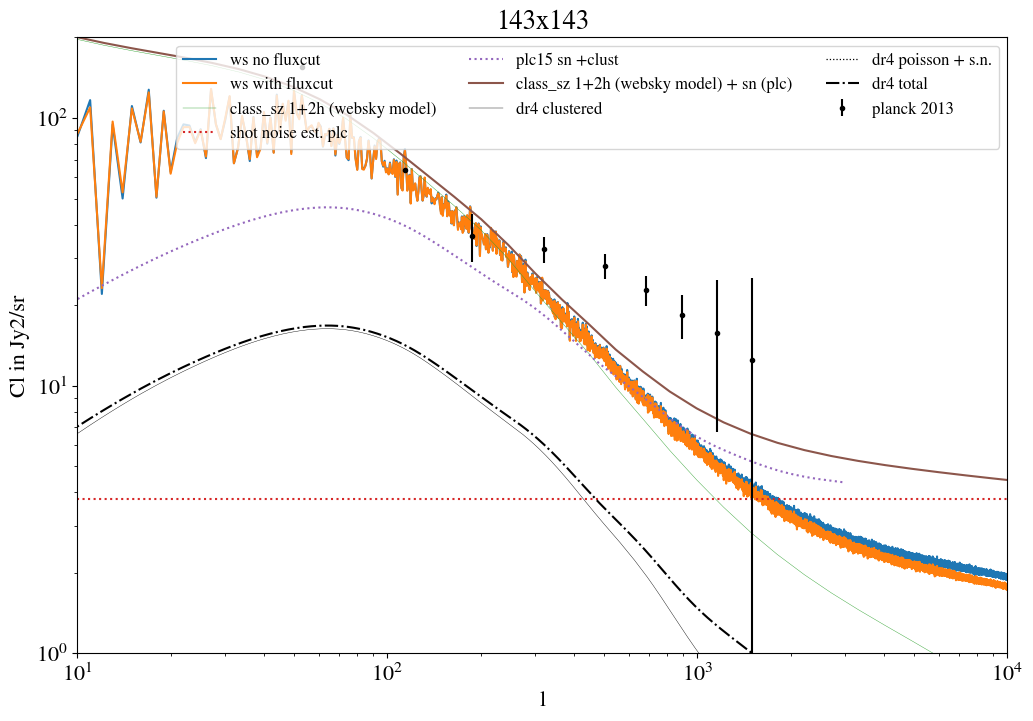

In [140]:
freq = '143x143'

fig, (ax) = plt.subplots(1,1,figsize=(12,8))


# this file is computed in websky_cib.ipynb
# by doing:
# cib_map  =hp.read_map('/Users/boris/Work/CLASS-SZ/SO-SZ/websky_cib/cib_nu0XX.fits')
# alpms = hp.map2alm(cib_map)
# cls_ws = hp.sphtfunc.alm2cl(alpms)
# ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_217_websky_l_cl_090322.txt',unpack=True)
# plt.plot(ls_ws,cls_ws*1e12,label='217')

# ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_143_websky_l_cl_090322.txt',unpack=True)
# plt.plot(ls_ws,cls_ws*1e12,label='143')


# this from benjamin and matches ,ap2alm
l = np.arange(10001)
plt.plot(l,1e12*cl_cib_websky_nofluxcut[0],label='ws no fluxcut')


l = np.arange(10001)
plt.plot(l,cl_cib_websky_fluxcut[0],label='ws with fluxcut')


l = np.asarray(cl_cib_websky[freq]['ell'])
facdl = l*(l+1.)/2./np.pi

plt.plot(l,np.asarray(cl_cib_websky[freq]['1h'])/facdl+np.asarray(cl_cib_websky[freq]['2h'])/facdl,lw=0.3,
         label = 'class_sz 1+2h (websky model)')

# this shot-noise value of 32.9 is estimated from the planck 2015 power spectrum lkl paper
# it is reported in https://wiki.cosmos.esa.int/planckpla2015/images/f/f7/Baseline_params_table_2015_limit68.pdf
# plik_HM_TT_loWTEB and represents all the shot noise contribution to the map, including cib and also radio
# the mean value is 44 pm 8
plt.plot(l,39.2*1/(3000*(3000+1.)/2./np.pi)*l/l*(371.74)**2.,label='shot noise est. plc',ls=':')

l = np.arange(2,3000)
facdl = l*(l+1.)/2./np.pi

cib_temp = get_template(l,dr4_params_dict['cib_temp_file'],ell_pivot=3000)
# the value of 5.9 is rported eq. 2 of https://arxiv.org/pdf/1502.01589.pdf
# it is the amplitude of the halo model template obtained in the plc 2013 analysis
plt.plot(l,39.2*1/(3000*(3000+1.)/2./np.pi)*l/l*(371.74)**2.+5.9*cib_temp/(l*(l+1.)/2./np.pi)*(371.74)**2.,label='plc15 sn +clust',ls=':')


l = np.asarray(cl_cib_websky[freq]['ell'])
facdl = l*(l+1.)/2./np.pi
plt.plot(l,39.2*1/(3000*(3000+1.)/2./np.pi)*l/l*(371.74)**2.+np.asarray(cl_cib_websky[freq]['1h'])/facdl+np.asarray(cl_cib_websky[freq]['2h'])/facdl,         
         label = 'class_sz 1+2h (websky model) + sn (plc)')


pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'],
             planck_2013[freq]['cl'],
             yerr=planck_2013[freq]['ecl'],
             marker= 'o',
             markersize=3.,
             ls='None',
             c='k',
             label = 'planck 2013')



ells = np.arange(2,5000)
cib_params_dict = choi_params_dict

cib_temp = get_template(ells,dr4_params_dict['cib_temp_file'],ell_pivot=3000)
plt.plot(ells,cib_params_dict['a_c']*cib_temp/(ells*(ells+1.)/2./np.pi)*(371.74)**2.*get_mu(cib_params_dict,[143])**2.,label='dr4 clustered',c='k',lw=0.3)

l = np.arange(2,5000)
cibp = cib_params_dict['a_d']*(l/l0)**(2)*get_mu(cib_params_dict,[143])**2.
plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(371.74)**2.,label='dr4 poisson + s.n.',lw=0.9,c='k',ls=':')

plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(371.74)**2.+cib_params_dict['a_c']*cib_temp/(ells*(ells+1.)/2./np.pi)*(371.74)**2.*get_mu(cib_params_dict,[143])**2.,
         label='dr4 total',c='k',ls='-.')


# cib_omori = np.loadtxt(path_to_files+'cls_mdpl2_v0.7_cib_planck_143ghz.dat')
# cib_omori_nomask = np.loadtxt(path_to_files+'cls_mdpl2_v0.7_cib_planck_143ghz_nomask.dat')
# plt.plot(cib_omori[:,0],cib_omori[:,1]*(371.74)**2.,label='omori')
# plt.plot(cib_omori_nomask[:,0],cib_omori_nomask[:,1]*(371.74)**2.,label='omori no mask')


plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=12,ncol=3)
plt.ylabel('Cl in Jy2/sr')
plt.xlabel('l')
plt.title(freq)
plt.xlim(1e1,1e4)
plt.ylim(1e0,2e2)
# plt.savefig('cibs_at_217ghz_dr4_dunkley13_withomori.pdf')

In [ ]:
# add error bars on the choi et lines

## 217 cib plot

(1.0, 10000.0)

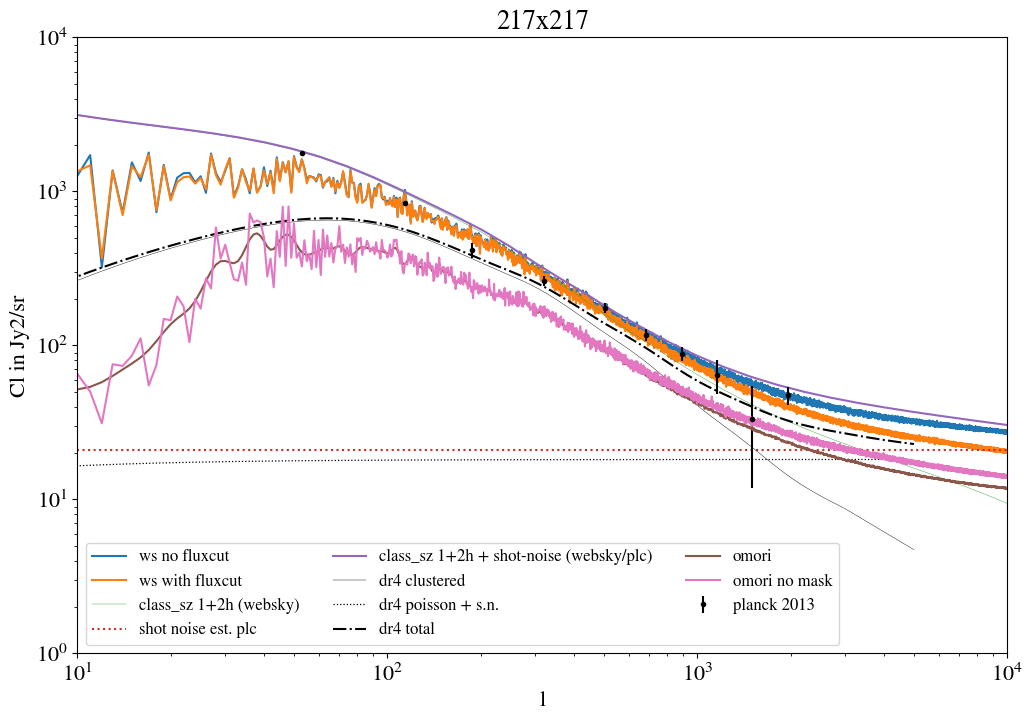

In [56]:
freq = '217x217'

fig, (ax) = plt.subplots(1,1,figsize=(12,8))


# this file is computed in websky_cib.ipynb
# by doing:
# cib_map  =hp.read_map('/Users/boris/Work/CLASS-SZ/SO-SZ/websky_cib/cib_nu0XX.fits')
# alpms = hp.map2alm(cib_map)
# cls_ws = hp.sphtfunc.alm2cl(alpms)
# ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_217_websky_l_cl_090322.txt',unpack=True)
# plt.plot(ls_ws,cls_ws*1e12,label='217')

# this from benjamin and matches ,ap2alm
l = np.arange(10001)
plt.plot(l,1e12*cl_cib_websky_nofluxcut[1],label='ws no fluxcut')


l = np.arange(10001)
plt.plot(l,cl_cib_websky_fluxcut[1],label='ws with fluxcut')


l = np.asarray(cl_cib_websky[freq]['ell'])
facdl = l*(l+1.)/2./np.pi

plt.plot(l,np.asarray(cl_cib_websky[freq]['1h'])/facdl+np.asarray(cl_cib_websky[freq]['2h'])/facdl,lw=0.3,
         label = 'class_sz 1+2h (websky)')

plt.plot(l,21.*l/l,label='shot noise est. plc',ls=':')

plt.plot(l,21.*l/l+np.asarray(cl_cib_websky[freq]['1h'])/facdl+np.asarray(cl_cib_websky[freq]['2h'])/facdl,         
         label = 'class_sz 1+2h + shot-noise (websky/plc)')


pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'],
             planck_2013[freq]['cl'],
             yerr=planck_2013[freq]['ecl'],
             marker= 'o',
             markersize=3.,
             ls='None',
             c='k',
             label = 'planck 2013')



ells = np.arange(2,5000)
cib_params_dict = choi_params_dict

cib_temp = get_template(ells,dr4_params_dict['cib_temp_file'],ell_pivot=3000)
plt.plot(ells,cib_params_dict['a_c']*cib_temp/(ells*(ells+1.)/2./np.pi)*(483.690)**2.*get_mu(cib_params_dict,[217])**2.,label='dr4 clustered',c='k',lw=0.3)

l = np.arange(2,5000)
cibp = cib_params_dict['a_d']*(l/l0)**(2)*get_mu(cib_params_dict,[217])**2.
plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(483.690)**2.,label='dr4 poisson + s.n.',lw=0.9,c='k',ls=':')

plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(483.690)**2.+cib_params_dict['a_c']*cib_temp/(ells*(ells+1.)/2./np.pi)*(483.690)**2.*get_mu(cib_params_dict,[217])**2.,
         label='dr4 total',c='k',ls='-.')


cib_omori = np.loadtxt(path_to_files+'cls_mdpl2_v0.7_cib_planck_217ghz.dat')
cib_omori_nomask = np.loadtxt(path_to_files+'cls_mdpl2_v0.7_cib_planck_217ghz_nomask.dat')
plt.plot(cib_omori[:,0],cib_omori[:,1]*(483.690)**2.,label='omori')
plt.plot(cib_omori_nomask[:,0],cib_omori_nomask[:,1]*(483.690)**2.,label='omori no mask')


plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=12,ncol=3)
plt.ylabel('Cl in Jy2/sr')
plt.xlabel('l')
plt.title(freq)
plt.xlim(1e1,1e4)
plt.ylim(1e0,1e4)
# plt.savefig('cibs_at_217ghz_dr4_dunkley13_withomori.pdf')

## 353 cib plot

(100.0, 100000.0)

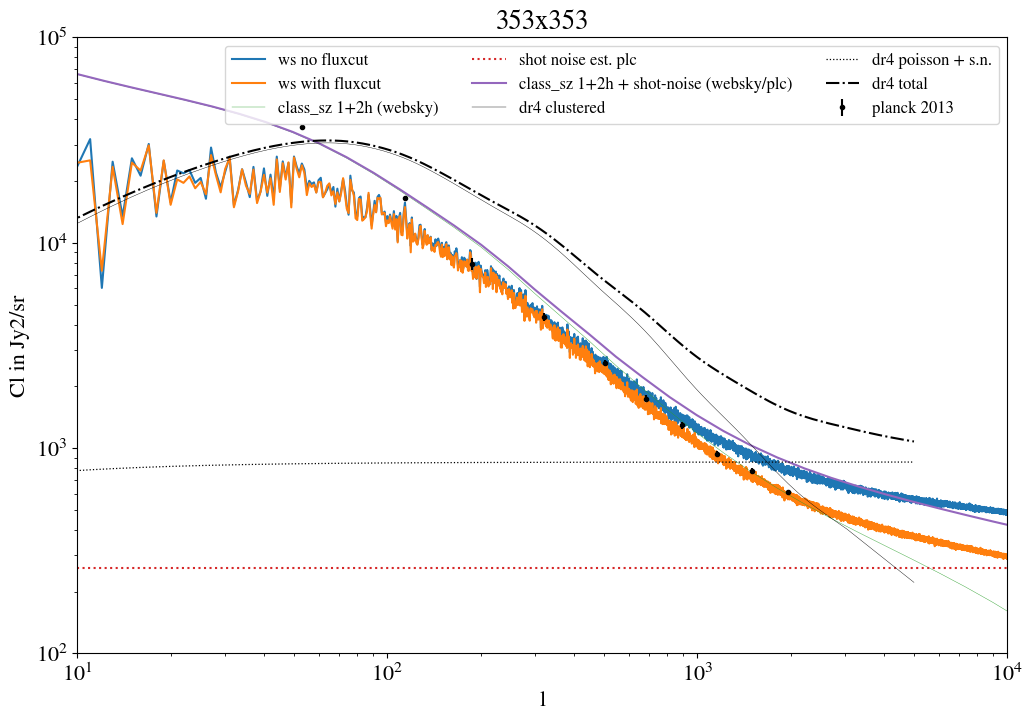

In [53]:
freq = '353x353'

fig, (ax) = plt.subplots(1,1,figsize=(12,8))


# this file is computed in websky_cib.ipynb
# by doing:
# cib_map  =hp.read_map('/Users/boris/Work/CLASS-SZ/SO-SZ/websky_cib/cib_nu0XX.fits')
# alpms = hp.map2alm(cib_map)
# cls_ws = hp.sphtfunc.alm2cl(alpms)
# ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_217_websky_l_cl_090322.txt',unpack=True)
# plt.plot(ls_ws,cls_ws*1e12,label='217')

# this from benjamin and matches ,ap2alm
l = np.arange(10001)
plt.plot(l,1e12*cl_cib_websky_nofluxcut[2],label='ws no fluxcut')


l = np.arange(10001)
plt.plot(l,cl_cib_websky_fluxcut[2],label='ws with fluxcut')


l = np.asarray(cl_cib_websky[freq]['ell'])
facdl = l*(l+1.)/2./np.pi

plt.plot(l,np.asarray(cl_cib_websky[freq]['1h'])/facdl+np.asarray(cl_cib_websky[freq]['2h'])/facdl,lw=0.3,
         label = 'class_sz 1+2h (websky)')

plt.plot(l,262.*l/l,label='shot noise est. plc',ls=':')

plt.plot(l,262.*l/l+np.asarray(cl_cib_websky[freq]['1h'])/facdl+np.asarray(cl_cib_websky[freq]['2h'])/facdl,         
         label = 'class_sz 1+2h + shot-noise (websky/plc)')


pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'],
             planck_2013[freq]['cl'],
             yerr=planck_2013[freq]['ecl'],
             marker= 'o',
             markersize=3.,
             ls='None',
             c='k',
             label = 'planck 2013')



ells = np.arange(2,5000)
cib_params_dict = choi_params_dict

cib_temp = get_template(ells,dr4_params_dict['cib_temp_file'],ell_pivot=3000)
plt.plot(ells,cib_params_dict['a_c']*cib_temp/(ells*(ells+1.)/2./np.pi)*(287.450)**2.*get_mu(cib_params_dict,[353])**2.,label='dr4 clustered',c='k',lw=0.3)

l = np.arange(2,5000)
cibp = cib_params_dict['a_d']*(l/l0)**(2)*get_mu(cib_params_dict,[353])**2.
plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(287.450)**2.,label='dr4 poisson + s.n.',lw=0.9,c='k',ls=':')

plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(287.450)**2.+cib_params_dict['a_c']*cib_temp/(ells*(ells+1.)/2./np.pi)*(287.450)**2.*get_mu(cib_params_dict,[353])**2.,
         label='dr4 total',c='k',ls='-.')


plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=12,ncol=3)
plt.ylabel('Cl in Jy2/sr')
plt.xlabel('l')
plt.title(freq)
plt.xlim(1e1,1e4)
plt.ylim(1e2,1e5)
# plt.savefig('cibs_at_217ghz_dr4_dunkley13_withomori.pdf')

In [23]:
ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_217_websky_l_cl_090322.txt',unpack=True)

In [24]:
ls_ws

array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 1.2285e+04, 1.2286e+04,
       1.2287e+04])

In [26]:
cls_ws[ls_ws==10000]

array([2.68123098e-11])

# uncertainty in sed params

In [192]:
cib_params_dict = dunk_params_dict

def cibp_of_nu(cib_params_dict,nu):
    cibp = cib_params_dict['a_d']*get_mu(cib_params_dict,nu)**2.
    return cibp


def cibc_of_nu(cib_params_dict,nu):
    cibp = cib_params_dict['a_c']*get_mu(cib_params_dict,nu)**2.
    return cibp


In [193]:
nu_arr = np.linspace(100,250,1000)

Text(0, 0.5, 'B3000 uK2')

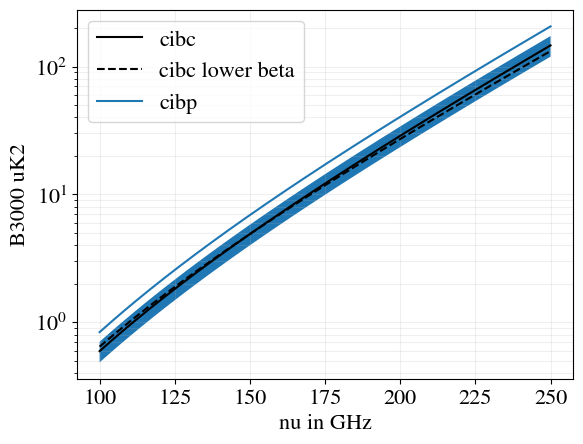

In [196]:


dunk_params_dict_low = dunk_params_dict.copy()
dunk_params_dict_low['a_c'] -=  dunk_params_dict_low['ea_c']

dunk_params_dict_high = dunk_params_dict.copy()
dunk_params_dict_high['a_c'] +=  dunk_params_dict_high['ea_c']


plt.fill_between(nu_arr,cibc_of_nu(dunk_params_dict_low,nu_arr),cibc_of_nu(dunk_params_dict_high,nu_arr))


plt.plot(nu_arr,cibc_of_nu(dunk_params_dict,nu_arr),label='cibc',c='k')

dunk_params_dict_low = dunk_params_dict.copy()
dunk_params_dict_low['beta_CIB'] -=  dunk_params_dict_low['ebeta_CIB']
# dunk_params_dict_low['a_c'] -=  dunk_params_dict_low['ea_c']
plt.plot(nu_arr,cibc_of_nu(dunk_params_dict_low,nu_arr),label='cibc lower beta',c='k',ls='--')

# dunk_params_dict_high = dunk_params_dict.copy()
# dunk_params_dict_high['beta_CIB'] +=  dunk_params_dict_high['ebeta_CIB']
# # dunk_params_dict_high['a_c'] +=  dunk_params_dict_high['ea_c']
# plt.fill_between(nu_arr,cibc_of_nu(dunk_params_dict_low,nu_arr),cibc_of_nu(dunk_params_dict_high,nu_arr))




plt.plot(nu_arr,
         cibp_of_nu(dunk_params_dict,nu_arr),
         label='cibp')


plt.yscale('log')
plt.legend()
plt.grid(alpha=0.2,which='both')
plt.xlabel('nu in GHz')
plt.ylabel('B3000 uK2')

## look at samples of ac and betacib from the chains themselves

In [221]:
path_to_erminiadr4_chain = '/Users/boris/fortrancodedr4chains/ACTPol_lcdm_ha_4.txt'

ch4 = np.loadtxt(path_to_erminiadr4_chain)

In [222]:
np.shape(ch4)

(2175, 70)

In [225]:
fgdr4_p = {
'steps' : 0,
'pos' : 1, 
'omega_b' : 2, 
'omega_cdm' : 3, 
'theta_s_1e2' : 4, 
'tau_reio' : 5, 
'logA' : 6, 
'ns' : 7,
'atsz' : 8, 
'aksz' : 9,
'xisz' : 10,
'ad' : 11, 
'ac' : 12, 
'beta_c' : 13, !! Wrong 
# 'a_p_TT_15' : 14,
# 'a_g_TT_15' : 15, 
# 'a_g_TT_100' : 16, 
# 'qq' : 23
}

SyntaxError: invalid syntax (1024062871.py, line 15)

In [224]:
plt.scatter(ch4[-1000:-1,fgdr4_p['ac']],ch4[-1000:-1,fgdr4_p['beta_c']])

KeyError: 'beta_c'

In [399]:
# path_to_bplike_chain = '/Users/boris/Work/CLASS-SZ/SO-SZ/bplike/chains/act_extended_act_only_mcmc_cosmopower_noleak_nosynch.4.txt'
path_to_bplike_chain = '/Users/boris/Work/CLASS-SZ/ATSZ_ACMB/analysis/atsz_analysis/act_extended_act_only.4.txt'


ch4 = np.loadtxt(path_to_bplike_chain)
ad = ch4[-1000:-1,11]
ac = ch4[-1000:-1,12]
betac = ch4[-1000:-1,13]

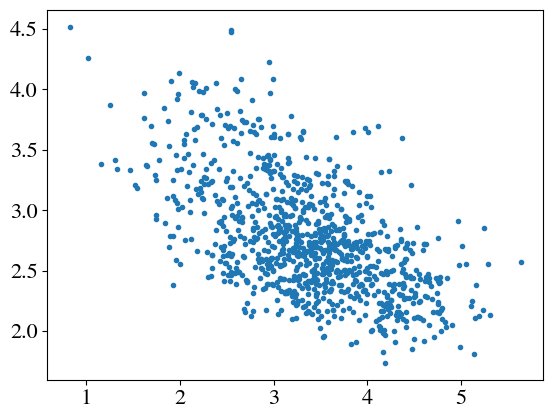

In [400]:
plt.scatter(ac,betac,marker='.')

In [401]:
cib_params_dict = dunk_params_dict

def cibp_of_nu(cib_params_dict,nu):
    cibp = cib_params_dict['a_d']*get_mu(cib_params_dict,nu)**2.
    return cibp


def cibc_of_nu(cib_params_dict,nu):
    cibp = cib_params_dict['a_c']*get_mu(cib_params_dict,nu)**2.
    return cibp


In [402]:
nu_arr = np.linspace(100,250,1000)

Text(0.5, 1.0, 'clustered')

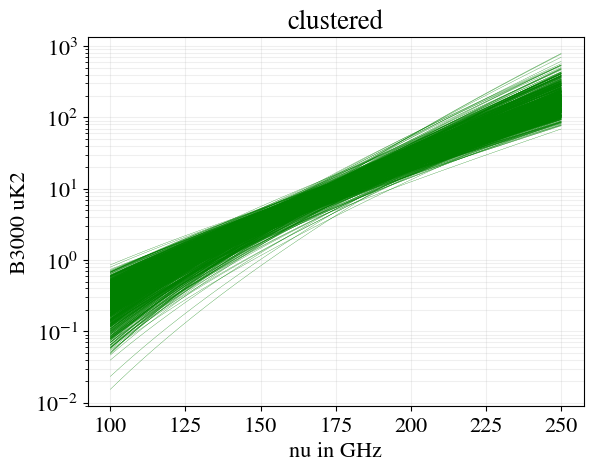

In [406]:



for acp,betacp,adp in zip(ac,betac,ad):
    params_dict_p = choi_params_dict.copy()
    params_dict_p['a_d'] = adp
    params_dict_p['a_c'] = acp
    params_dict_p['beta_CIB'] = betacp

    plt.plot(nu_arr,
         cibc_of_nu(params_dict_p,nu_arr),
         lw=0.2,color='green')
    # plt.plot(nu_arr,
    #      cibp_of_nu(params_dict_p,nu_arr),
    #      lw=0.2)
plt.yscale('log')
# plt.legend()
plt.grid(alpha=0.2,which='both')
plt.xlabel('nu in GHz')
plt.ylabel('B3000 uK2')
plt.title('clustered')

Text(0.5, 1.0, 'poisson')

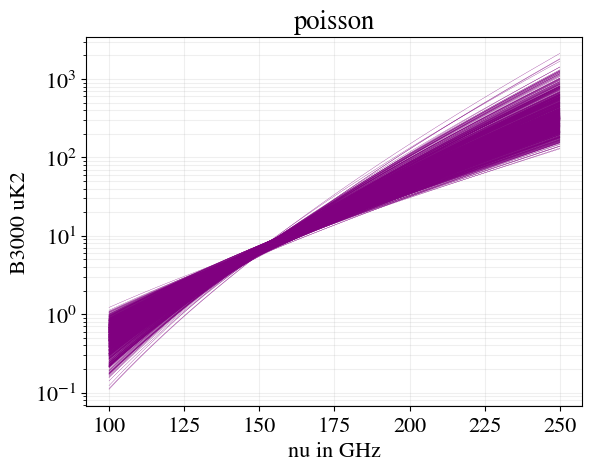

In [405]:



for acp,betacp,adp in zip(ac,betac,ad):
    params_dict_p = choi_params_dict.copy()
    params_dict_p['a_d'] = adp
    params_dict_p['a_c'] = acp
    params_dict_p['beta_CIB'] = betacp

    # plt.plot(nu_arr,
    #      cibc_of_nu(params_dict_p,nu_arr),
    #      lw=0.2)
    plt.plot(nu_arr,
         cibp_of_nu(params_dict_p,nu_arr),
         lw=0.2,color='purple')
plt.yscale('log')
# plt.legend()
plt.grid(alpha=0.2,which='both')
plt.xlabel('nu in GHz')
plt.ylabel('B3000 uK2')
plt.title('poisson')

(0.1, 200.0)

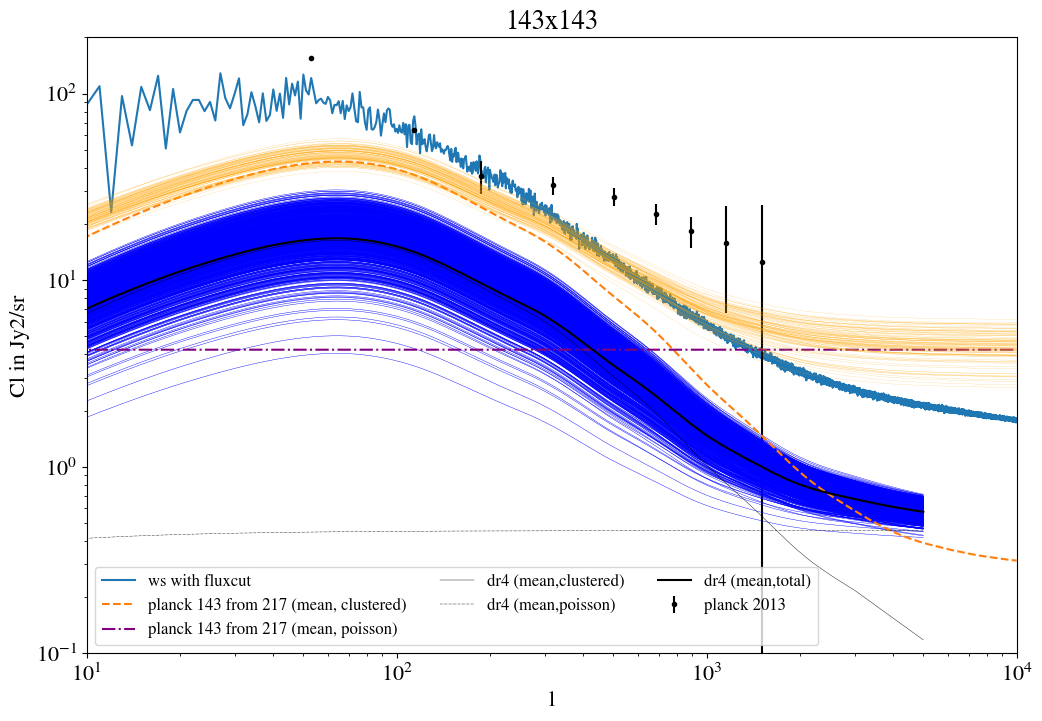

In [412]:

freq = '143x143'

fig, (ax) = plt.subplots(1,1,figsize=(12,8))


# this file is computed in websky_cib.ipynb
# by doing:
# cib_map  =hp.read_map('/Users/boris/Work/CLASS-SZ/SO-SZ/websky_cib/cib_nu0XX.fits')
# alpms = hp.map2alm(cib_map)
# cls_ws = hp.sphtfunc.alm2cl(alpms)
# ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_217_websky_l_cl_090322.txt',unpack=True)
# plt.plot(ls_ws,cls_ws*1e12,label='217')

# ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_143_websky_l_cl_090322.txt',unpack=True)
# plt.plot(ls_ws,cls_ws*1e12,label='143')


# this from benjamin and matches ,ap2alm
# l = np.arange(10001)
# plt.plot(l,1e12*cl_cib_websky_nofluxcut[0],label='ws no fluxcut')


l = np.arange(10001)
plt.plot(l,cl_cib_websky_fluxcut[0],label='ws with fluxcut')



# this shot-noise value of 32.9 is estimated from the planck 2015 power spectrum lkl paper
# it is reported in https://wiki.cosmos.esa.int/planckpla2015/images/f/f7/Baseline_params_table_2015_limit68.pdf
# plik_HM_TT_loWTEB and represents all the shot noise contribution to the map, including cib and also radio
# the mean value is 44 pm 8

# plt.plot(l,np.repeat(39.2*1/(3000*(3000+1.)/2./np.pi)*(371.74)**2.,len(l)),label='shot noise est. plc',ls=':')

l = np.arange(2,3000)
facdl = l*(l+1.)/2./np.pi

# cib_temp = get_template(l,dr4_params_dict['cib_temp_file'],ell_pivot=3000)
# the value of 5.9 is reported eq. 2 of https://arxiv.org/pdf/1502.01589.pdf
# it is the amplitude of the halo model template obtained in the plc 2013 analysis
# plt.plot(l,39.2*1/(3000*(3000+1.)/2./np.pi)*l/l*(371.74)**2.+5.9*cib_temp/(l*(l+1.)/2./np.pi)*(371.74)**2.,label='plc15 sn +clust',ls=':')




pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'],
             planck_2013[freq]['cl'],
             yerr=planck_2013[freq]['ecl'],
             marker= 'o',
             markersize=3.,
             ls='None',
             c='k',
             label = 'planck 2013')



# ells = np.arange(2,5000)



l = np.arange(2,5000)
ells = l
cib_temp = get_template(ells,dr4_params_dict['cib_temp_file'],ell_pivot=3000)
for acp,betacp,adp in zip(ac,betac,ad):
    cib_params_dict = choi_params_dict.copy()
    cib_params_dict['a_c'] = acp
    cib_params_dict['beta_CIB'] = betacp
    cib_params_dict['a_d'] = adp
    cibp = cib_params_dict['a_d']*(l/l0)**(2)*get_mu(cib_params_dict,[143])**2.
    plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(371.74)**2.+cib_params_dict['a_c']*cib_temp/(ells*(ells+1.)/2./np.pi)*(371.74)**2.*get_mu(cib_params_dict,[143])**2.,
             lw=0.3,color='blue')

    
# planck ps 2015:
fname_planck  = "/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_all.dat"
data = np.loadtxt(fname_planck, usecols = (0,7,12,16,19)) # Pour avoir le template à 143,217,353,545GHz
ell_planck = data[:,0]
cl_planck_Jy = data[:,1:]

cl_planck_143 = cl_planck_Jy[:,0]
cl_planck_217 = cl_planck_Jy[:,1]
norm_217 = cl_planck_217[3000]
# plt.plot(ell_planck,cl_planck_143,label='planck 143 template',ls='--')



A_c_217 = 63.9 # mean from ps analysis
eA_c_217 = 6.6 # 1-sigma from ps analysis

A_p_143 = 44. # mean from ps analysis
eA_p_143 = 8. # 1-sigma from ps analysis

cl_planck_143_from_217  = cl_planck_143/norm_217*A_c_217/(3000*3001/2./np.pi)*(483.690)**2

plt.plot(ell_planck,cl_planck_143_from_217,label='planck 143 from 217 (mean, clustered)',ls='--')

cl_planck_poisson_143 = np.repeat(A_p_143*1/(3000*(3000+1.)/2./np.pi)*(371.74)**2.,len(ell_planck))
plt.plot(ell_planck,cl_planck_poisson_143,label='planck 143 from 217 (mean, poisson)',color='purple',ls='-.')

# this shot-noise value of A_ps_143 = 32.9 is estimated from the planck 2015 power spectrum lkl paper
# it is reported in https://wiki.cosmos.esa.int/planckpla2015/images/f/f7/Baseline_params_table_2015_limit68.pdf
# plik_HM_TT_loWTEB and represents all the shot noise contribution to the map, including cib and also radio
# the mean value is A_ps_143 = 44 pm 8


# sample from gaussian
Ac_217_samps = np.random.normal(A_c_217, eA_c_217, 100)
Ap_143_samps = np.random.normal(A_p_143, eA_p_143, 100)

# sample from chains
path_to_planck_chain = '/Users/boris/COM_CosmoParams_base-plikHM-TT-lowTEB_R2.00/base/plikHM_TT_lowTEB/base_plikHM_TT_lowTEB_4.txt'
planck_chain = np.loadtxt(path_to_planck_chain)
A_cib_planck = planck_chain[:,9]
A_ps_planck_143 = planck_chain[:,13]
A_ps_planck_217 = planck_chain[:,15]

Ac_217_samps = A_cib_planck[-100:-1]
Ap_143_samps = A_ps_planck_143[-100:-1]

for acp,app in zip(Ac_217_samps,Ap_143_samps):
    cl_planck_143_from_217  = cl_planck_143/norm_217*acp/(3000*3001/2./np.pi)*(483.690)**2
    cl_planck_poisson_143 = np.repeat(app*1/(3000*(3000+1.)/2./np.pi)*(371.74)**2.,len(ell_planck))
    # plt.plot(l,np.repeat(39.2*1/(3000*(3000+1.)/2./np.pi)*(371.74)**2.,len(l)),label='shot noise est. plc',ls=':')
    plt.plot(ell_planck,cl_planck_143_from_217+cl_planck_poisson_143,lw=0.1,color='orange')
        
    

# dr4

cib_params_dict = choi_params_dict.copy()

plt.plot(ells,cib_params_dict['a_c']*cib_temp/(ells*(ells+1.)/2./np.pi)*(371.74)**2.*get_mu(cib_params_dict,[143])**2.,label='dr4 (mean,clustered)',c='k',lw=0.3)

cibp = cib_params_dict['a_d']*(l/l0)**(2)*get_mu(cib_params_dict,[143])**2.
plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(371.74)**2.,
         label='dr4 (mean,poisson)',c='k',ls='-.',lw=0.3)


plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(371.74)**2.+cib_params_dict['a_c']*cib_temp/(ells*(ells+1.)/2./np.pi)*(371.74)**2.*get_mu(cib_params_dict,[143])**2.,
         label='dr4 (mean,total)',c='k',ls='-')



plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=12,ncol=3)
plt.ylabel('Cl in Jy2/sr')
plt.xlabel('l')
plt.title(freq)
plt.xlim(1e1,1e4)
plt.ylim(1e-1,2e2)
# plt.savefig('cibs_at_217ghz_dr4_dunkley13_withomori.pdf')

(10.0, 2000.0)

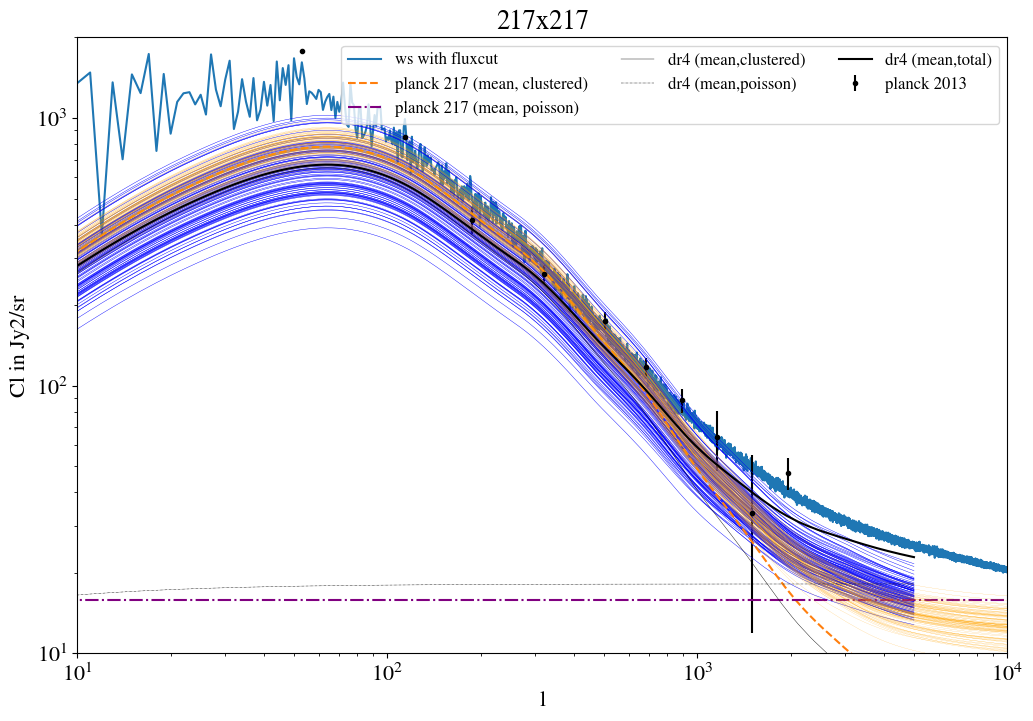

In [422]:

freqp = 217
conv_fac = 483.690
freq = str(freqp) + 'x' + str(freqp)
fig, (ax) = plt.subplots(1,1,figsize=(12,8))


# this file is computed in websky_cib.ipynb
# by doing:
# cib_map  =hp.read_map('/Users/boris/Work/CLASS-SZ/SO-SZ/websky_cib/cib_nu0XX.fits')
# alpms = hp.map2alm(cib_map)
# cls_ws = hp.sphtfunc.alm2cl(alpms)
# ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_217_websky_l_cl_090322.txt',unpack=True)
# plt.plot(ls_ws,cls_ws*1e12,label='217')

# ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_143_websky_l_cl_090322.txt',unpack=True)
# plt.plot(ls_ws,cls_ws*1e12,label='143')


# this from benjamin and matches ,ap2alm
# l = np.arange(10001)
# plt.plot(l,1e12*cl_cib_websky_nofluxcut[0],label='ws no fluxcut')


l = np.arange(10001)
plt.plot(l,cl_cib_websky_fluxcut[1],label='ws with fluxcut')



# this shot-noise value of 32.9 is estimated from the planck 2015 power spectrum lkl paper
# it is reported in https://wiki.cosmos.esa.int/planckpla2015/images/f/f7/Baseline_params_table_2015_limit68.pdf
# plik_HM_TT_loWTEB and represents all the shot noise contribution to the map, including cib and also radio
# the mean value is 44 pm 8

# plt.plot(l,np.repeat(39.2*1/(3000*(3000+1.)/2./np.pi)*(371.74)**2.,len(l)),label='shot noise est. plc',ls=':')

l = np.arange(2,3000)
facdl = l*(l+1.)/2./np.pi

# cib_temp = get_template(l,dr4_params_dict['cib_temp_file'],ell_pivot=3000)
# the value of 5.9 is reported eq. 2 of https://arxiv.org/pdf/1502.01589.pdf
# it is the amplitude of the halo model template obtained in the plc 2013 analysis
# plt.plot(l,39.2*1/(3000*(3000+1.)/2./np.pi)*l/l*(371.74)**2.+5.9*cib_temp/(l*(l+1.)/2./np.pi)*(371.74)**2.,label='plc15 sn +clust',ls=':')




pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'],
             planck_2013[freq]['cl'],
             yerr=planck_2013[freq]['ecl'],
             marker= 'o',
             markersize=3.,
             ls='None',
             c='k',
             label = 'planck 2013')



# ells = np.arange(2,5000)



l = np.arange(2,5000)
ells = l
cib_temp = get_template(ells,dr4_params_dict['cib_temp_file'],ell_pivot=3000)
for acp,betacp,adp in zip(ac,betac,ad):
    cib_params_dict = choi_params_dict.copy()
    cib_params_dict['a_c'] = acp
    cib_params_dict['beta_CIB'] = betacp
    cib_params_dict['a_d'] = adp
    cibp = cib_params_dict['a_d']*(l/l0)**(2)*get_mu(cib_params_dict,[freqp])**2.
    plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(conv_fac)**2.+cib_params_dict['a_c']*cib_temp/(ells*(ells+1.)/2./np.pi)*(conv_fac)**2.*get_mu(cib_params_dict,[freqp])**2.,
             lw=0.3,color='blue')

    
# planck ps 2015:
fname_planck  = "/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_all.dat"
data = np.loadtxt(fname_planck, usecols = (0,7,12,16,19)) # Pour avoir le template à 143,217,353,545GHz
ell_planck = data[:,0]
cl_planck_Jy = data[:,1:]

cl_planck_143 = cl_planck_Jy[:,0]
cl_planck_217 = cl_planck_Jy[:,1]
norm_217 = cl_planck_217[3000]
# plt.plot(ell_planck,cl_planck_143,label='planck 143 template',ls='--')



A_c_217 = 63.9 # mean from ps analysis
eA_c_217 = 6.6 # 1-sigma from ps analysis

A_p_217 = 97. # mean from ps analysis
eA_p_217 = 10. # 1-sigma from ps analysis

cl_planck_217_from_217  = cl_planck_217/norm_217*A_c_217/(3000*3001/2./np.pi)*(483.690)**2

plt.plot(ell_planck,cl_planck_217_from_217,label='planck 217 (mean, clustered)',ls='--')

cl_planck_poisson_217 = np.repeat(A_p_217*1/(3000*(3000+1.)/2./np.pi)*(conv_fac)**2.,len(ell_planck))
plt.plot(ell_planck,cl_planck_poisson_217,label='planck 217 (mean, poisson)',color='purple',ls='-.')

# this shot-noise value of A_ps_143 = 32.9 is estimated from the planck 2015 power spectrum lkl paper
# it is reported in https://wiki.cosmos.esa.int/planckpla2015/images/f/f7/Baseline_params_table_2015_limit68.pdf
# plik_HM_TT_loWTEB and represents all the shot noise contribution to the map, including cib and also radio
# the mean value is A_ps_143 = 44 pm 8


# sample from gaussian
Ac_217_samps = np.random.normal(A_c_217, eA_c_217, 100)
Ap_217_samps = np.random.normal(A_p_217, eA_p_217, 100)

# sample from chains
path_to_planck_chain = '/Users/boris/COM_CosmoParams_base-plikHM-TT-lowTEB_R2.00/base/plikHM_TT_lowTEB/base_plikHM_TT_lowTEB_4.txt'
planck_chain = np.loadtxt(path_to_planck_chain)
A_cib_planck = planck_chain[:,9]
A_ps_planck_143 = planck_chain[:,13]
A_ps_planck_217 = planck_chain[:,15]

Ac_217_samps = A_cib_planck[-100:-1]
Ap_217_samps = A_ps_planck_217[-100:-1]

for acp,app in zip(Ac_217_samps,Ap_143_samps):
    cl_planck_217_from_217  = cl_planck_217/norm_217*acp/(3000*3001/2./np.pi)*(483.690)**2
    cl_planck_poisson_217 = np.repeat(app*1/(3000*(3000+1.)/2./np.pi)*(conv_fac)**2.,len(ell_planck))
    # plt.plot(l,np.repeat(39.2*1/(3000*(3000+1.)/2./np.pi)*(371.74)**2.,len(l)),label='shot noise est. plc',ls=':')
    plt.plot(ell_planck,cl_planck_217_from_217+cl_planck_poisson_217,lw=0.1,color='orange')
        
    

# dr4

cib_params_dict = choi_params_dict.copy()

plt.plot(ells,cib_params_dict['a_c']*cib_temp/(ells*(ells+1.)/2./np.pi)*(conv_fac)**2.*get_mu(cib_params_dict,[freqp])**2.,label='dr4 (mean,clustered)',c='k',lw=0.3)

cibp = cib_params_dict['a_d']*(l/l0)**(2)*get_mu(cib_params_dict,[freqp])**2.
plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(conv_fac)**2.,
         label='dr4 (mean,poisson)',c='k',ls='-.',lw=0.3)


plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(conv_fac)**2.+cib_params_dict['a_c']*cib_temp/(ells*(ells+1.)/2./np.pi)*(conv_fac)**2.*get_mu(cib_params_dict,[freqp])**2.,
         label='dr4 (mean,total)',c='k',ls='-')



plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=12,ncol=3)
plt.ylabel('Cl in Jy2/sr')
plt.xlabel('l')
plt.title(freq)
plt.xlim(1e1,1e4)
plt.ylim(1e1,2e3)
# plt.savefig('cibs_at_217ghz_dr4_dunkley13_withomori.pdf')

## samples from dunkley et al (gaussian)

In [423]:
dunk_params_dict

{'a_c': 4.9,
 'ea_c': 0.9,
 'a_d': 6.9,
 'ea_d': 0.4,
 'Tdust_CIB': 9.7,
 'nu0_CIB_ghz': 150.0,
 'beta_CIB': 2.2,
 'ebeta_CIB': 0.1,
 'cibc_n': -1.2,
 'cib_temp_file': '/Users/boris/Work/CLASS-SZ/SO-SZ/bplike/data/actpolfull_dr4.01/data/Fg/cib_extra.dat',
 'high_ell0': 3000}

In [424]:
# cib_params_dict = dunk_params_dict

def cibp_of_nu(cib_params_dict,nu):
    cibp = cib_params_dict['a_d']*get_mu(cib_params_dict,nu)**2.
    return cibp


def cibc_of_nu(cib_params_dict,nu):
    cibp = cib_params_dict['a_c']*get_mu(cib_params_dict,nu)**2.
    return cibp


In [425]:
nu_arr = np.linspace(100,250,1000)

In [426]:
ac = np.random.normal(dunk_params_dict['a_c'], dunk_params_dict['ea_c'], 100)
ad = np.random.normal(dunk_params_dict['a_d'], dunk_params_dict['ea_d'], 100)
betac = np.random.normal(dunk_params_dict['beta_CIB'], dunk_params_dict['ebeta_CIB'], 100)

Text(0.5, 1.0, 'clustered')

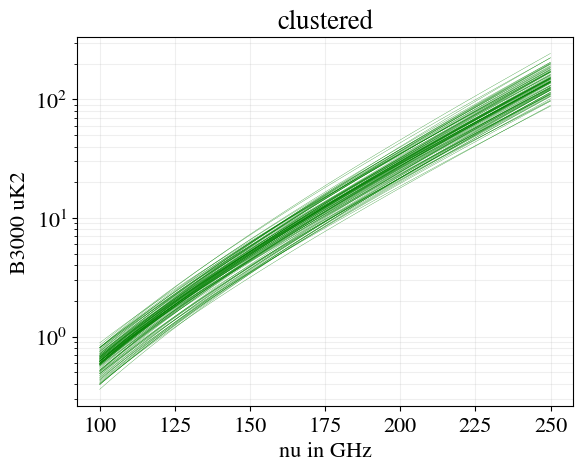

In [427]:



for acp,betacp,adp in zip(ac,betac,ad):
    params_dict_p = dunk_params_dict.copy()
    params_dict_p['a_d'] = adp
    params_dict_p['a_c'] = acp
    params_dict_p['beta_CIB'] = betacp

    plt.plot(nu_arr,
         cibc_of_nu(params_dict_p,nu_arr),
         lw=0.2,color='green')
    # plt.plot(nu_arr,
    #      cibp_of_nu(params_dict_p,nu_arr),
    #      lw=0.2)
plt.yscale('log')
# plt.legend()
plt.grid(alpha=0.2,which='both')
plt.xlabel('nu in GHz')
plt.ylabel('B3000 uK2')
plt.title('clustered')

Text(0.5, 1.0, 'poisson')

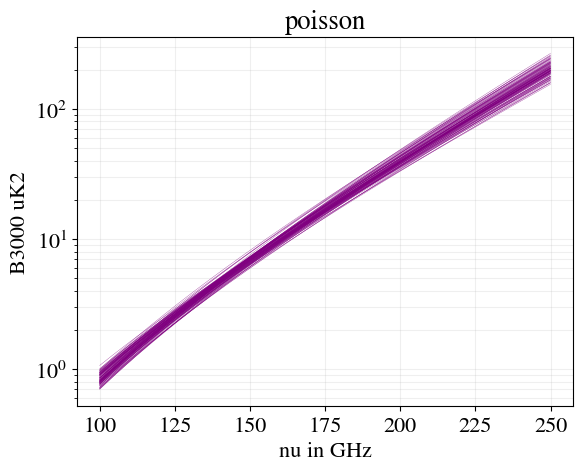

In [428]:



for acp,betacp,adp in zip(ac,betac,ad):
    params_dict_p = dunk_params_dict.copy()
    params_dict_p['a_d'] = adp
    params_dict_p['a_c'] = acp
    params_dict_p['beta_CIB'] = betacp

    # plt.plot(nu_arr,
    #      cibc_of_nu(params_dict_p,nu_arr),
    #      lw=0.2)
    plt.plot(nu_arr,
         cibp_of_nu(params_dict_p,nu_arr),
         lw=0.2,color='purple')
plt.yscale('log')
# plt.legend()
plt.grid(alpha=0.2,which='both')
plt.xlabel('nu in GHz')
plt.ylabel('B3000 uK2')
plt.title('poisson')

(0.1, 200.0)

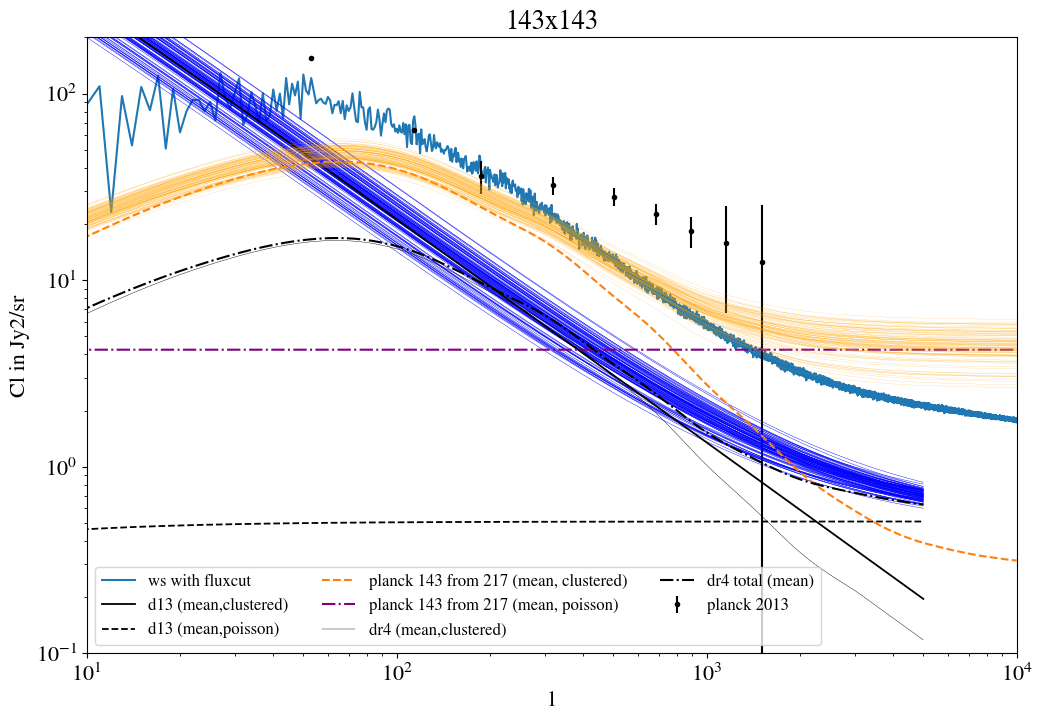

In [429]:
freq = '143x143'

fig, (ax) = plt.subplots(1,1,figsize=(12,8))


# this file is computed in websky_cib.ipynb
# by doing:
# cib_map  =hp.read_map('/Users/boris/Work/CLASS-SZ/SO-SZ/websky_cib/cib_nu0XX.fits')
# alpms = hp.map2alm(cib_map)
# cls_ws = hp.sphtfunc.alm2cl(alpms)
# ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_217_websky_l_cl_090322.txt',unpack=True)
# plt.plot(ls_ws,cls_ws*1e12,label='217')

# ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_143_websky_l_cl_090322.txt',unpack=True)
# plt.plot(ls_ws,cls_ws*1e12,label='143')


# this from benjamin and matches ,ap2alm
# l = np.arange(10001)
# plt.plot(l,1e12*cl_cib_websky_nofluxcut[0],label='ws no fluxcut')


l = np.arange(10001)
plt.plot(l,cl_cib_websky_fluxcut[0],label='ws with fluxcut')



# this shot-noise value of A_ps_143 = 32.9 is estimated from the planck 2015 power spectrum lkl paper
# it is reported in https://wiki.cosmos.esa.int/planckpla2015/images/f/f7/Baseline_params_table_2015_limit68.pdf
# plik_HM_TT_loWTEB and represents all the shot noise contribution to the map, including cib and also radio
# the mean value is A_ps_143 = 44 pm 8

# plt.plot(l,np.repeat(39.2*1/(3000*(3000+1.)/2./np.pi)*(371.74)**2.,len(l)),label='shot noise est. plc',ls=':')

l = np.arange(2,3000)
facdl = l*(l+1.)/2./np.pi

cib_temp = get_template(l,dr4_params_dict['cib_temp_file'],ell_pivot=3000)
# the value of 5.9 is reported eq. 2 of https://arxiv.org/pdf/1502.01589.pdf
# it is the amplitude of the halo model template obtained in the plc 2013 analysis
# plt.plot(l,39.2*1/(3000*(3000+1.)/2./np.pi)*l/l*(371.74)**2.+5.9*cib_temp/(l*(l+1.)/2./np.pi)*(371.74)**2.,label='plc15 sn +clust',ls=':')

# plt.plot(l,5.9*cib_temp/(l*(l+1.)/2./np.pi)*(371.74)**2.,label='plc15 clust',ls='-')




pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'],
             planck_2013[freq]['cl'],
             yerr=planck_2013[freq]['ecl'],
             marker= 'o',
             markersize=3.,
             ls='None',
             c='k',
             label = 'planck 2013')






l = np.arange(2,5000)
l0 = 3000


for acp,betacp,adp in zip(ac,betac,ad):
    cib_params_dict = dunk_params_dict.copy()
    cib_params_dict['a_c'] = acp
    cib_params_dict['beta_CIB'] = betacp
    cib_params_dict['a_d'] = adp

    cibc = cib_params_dict['a_c']*(l/l0)**(2+cib_params_dict['cibc_n'])*get_mu(cib_params_dict,[143])**2.
    cibp = cib_params_dict['a_d']*(l/l0)**(2)*get_mu(dunk_params_dict,[143])**2.

    plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(371.74)**2.+(l*(l+1)/2./np.pi)**-1.*cibc*(371.74)**2.,lw=0.3,color='blue')


    
cibc = dunk_params_dict['a_c']*(l/l0)**(2+dunk_params_dict['cibc_n'])*get_mu(dunk_params_dict,[143])**2.
cibp = dunk_params_dict['a_d']*(l/l0)**(2)*get_mu(dunk_params_dict,[143])**2.


plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibc*(371.74)**2.,label='d13 (mean,clustered)',lw=1.3,c='k',ls='-')


plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(371.74)**2.,label='d13 (mean,poisson)',lw=1.3,c='k',ls='--')    



# planck ps 2015:
fname_planck  = "/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_all.dat"
data = np.loadtxt(fname_planck, usecols = (0,7,12,16,19)) # Pour avoir le template à 143,217,353,545GHz
ell_planck = data[:,0]
cl_planck_Jy = data[:,1:]

cl_planck_143 = cl_planck_Jy[:,0]
cl_planck_217 = cl_planck_Jy[:,1]
norm_217 = cl_planck_217[3000]
# plt.plot(ell_planck,cl_planck_143,label='planck 143 template',ls='--')



A_c_217 = 63.9 # mean from ps analysis
eA_c_217 = 6.6 # 1-sigma from ps analysis

A_p_143 = 44. # mean from ps analysis
eA_p_143 = 8. # 1-sigma from ps analysis

cl_planck_143_from_217  = cl_planck_143/norm_217*A_c_217/(3000*3001/2./np.pi)*(483.690)**2

plt.plot(ell_planck,cl_planck_143_from_217,label='planck 143 from 217 (mean, clustered)',ls='--')

cl_planck_poisson_143 = np.repeat(A_p_143*1/(3000*(3000+1.)/2./np.pi)*(371.74)**2.,len(ell_planck))
plt.plot(ell_planck,cl_planck_poisson_143,label='planck 143 from 217 (mean, poisson)',color='purple',ls='-.')


# this shot-noise value of A_ps_143 = 32.9 is estimated from the planck 2015 power spectrum lkl paper
# it is reported in https://wiki.cosmos.esa.int/planckpla2015/images/f/f7/Baseline_params_table_2015_limit68.pdf
# plik_HM_TT_loWTEB and represents all the shot noise contribution to the map, including cib and also radio
# the mean value is A_ps_143 = 44 pm 8



Ac_217_samps = np.random.normal(A_c_217, eA_c_217, 100)
Ap_143_samps = np.random.normal(A_p_143, eA_p_143, 100)


# sample from chains
path_to_planck_chain = '/Users/boris/COM_CosmoParams_base-plikHM-TT-lowTEB_R2.00/base/plikHM_TT_lowTEB/base_plikHM_TT_lowTEB_4.txt'
planck_chain = np.loadtxt(path_to_planck_chain)
A_cib_planck = planck_chain[:,9]
A_ps_planck_143 = planck_chain[:,13]
A_ps_planck_217 = planck_chain[:,15]

Ac_217_samps = A_cib_planck[-100:-1]
Ap_143_samps = A_ps_planck_143[-100:-1]


for acp,app in zip(Ac_217_samps,Ap_143_samps):
    cl_planck_143_from_217  = cl_planck_143/norm_217*acp/(3000*3001/2./np.pi)*(483.690)**2
    cl_planck_poisson_143 = np.repeat(app*1/(3000*(3000+1.)/2./np.pi)*(371.74)**2.,len(ell_planck))
    # plt.plot(l,np.repeat(39.2*1/(3000*(3000+1.)/2./np.pi)*(371.74)**2.,len(l)),label='shot noise est. plc',ls=':')
    plt.plot(ell_planck,cl_planck_143_from_217+cl_planck_poisson_143,lw=0.1,color='orange')
    

# add DR4 template:
cib_params_dict = choi_params_dict.copy()
ells = np.arange(2,5000)
cib_temp = get_template(ells,dr4_params_dict['cib_temp_file'],ell_pivot=3000)
plt.plot(ells,cib_params_dict['a_c']*cib_temp/(ells*(ells+1.)/2./np.pi)*(371.74)**2.*get_mu(cib_params_dict,[143])**2.,label='dr4 (mean,clustered)',c='k',lw=0.3)



plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(371.74)**2.+cib_params_dict['a_c']*cib_temp/(ells*(ells+1.)/2./np.pi)*(371.74)**2.*get_mu(cib_params_dict,[143])**2.,
         label='dr4 total (mean)',c='k',ls='-.')

plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=12,ncol=3)
plt.ylabel('Cl in Jy2/sr')
plt.xlabel('l')
plt.title(freq)
plt.xlim(1e1,1e4)
plt.ylim(1e-1,2e2)
# plt.savefig('cibs_at_217ghz_dr4_dunkley13_withomori.pdf')

(10.0, 5000.0)

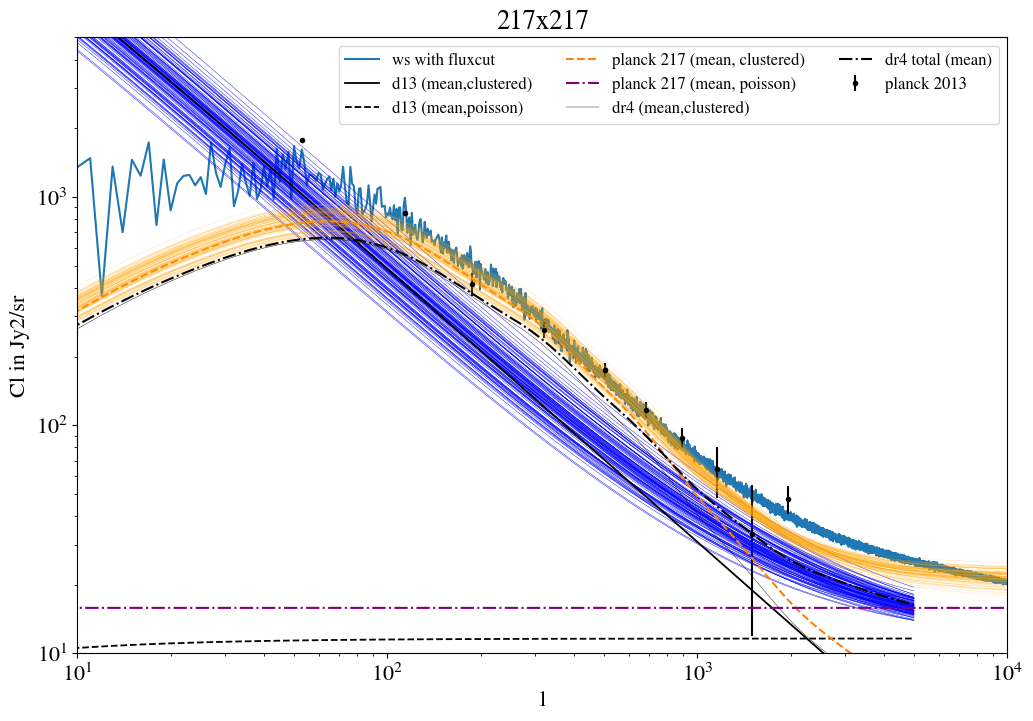

In [434]:

freqp = 217
conv_fac = 483.690

freq = str(freqp)+'x'+str(freqp)

fig, (ax) = plt.subplots(1,1,figsize=(12,8))


# this file is computed in websky_cib.ipynb
# by doing:
# cib_map  =hp.read_map('/Users/boris/Work/CLASS-SZ/SO-SZ/websky_cib/cib_nu0XX.fits')
# alpms = hp.map2alm(cib_map)
# cls_ws = hp.sphtfunc.alm2cl(alpms)
# ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_217_websky_l_cl_090322.txt',unpack=True)
# plt.plot(ls_ws,cls_ws*1e12,label='217')

# ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_143_websky_l_cl_090322.txt',unpack=True)
# plt.plot(ls_ws,cls_ws*1e12,label='143')


# this from benjamin and matches ,ap2alm
# l = np.arange(10001)
# plt.plot(l,1e12*cl_cib_websky_nofluxcut[0],label='ws no fluxcut')


l = np.arange(10001)
plt.plot(l,cl_cib_websky_fluxcut[1],label='ws with fluxcut')



# this shot-noise value of A_ps_143 = 32.9 is estimated from the planck 2015 power spectrum lkl paper
# it is reported in https://wiki.cosmos.esa.int/planckpla2015/images/f/f7/Baseline_params_table_2015_limit68.pdf
# plik_HM_TT_loWTEB and represents all the shot noise contribution to the map, including cib and also radio
# the mean value is A_ps_143 = 44 pm 8

# plt.plot(l,np.repeat(39.2*1/(3000*(3000+1.)/2./np.pi)*(371.74)**2.,len(l)),label='shot noise est. plc',ls=':')

l = np.arange(2,3000)
facdl = l*(l+1.)/2./np.pi

cib_temp = get_template(l,dr4_params_dict['cib_temp_file'],ell_pivot=3000)
# the value of 5.9 is reported eq. 2 of https://arxiv.org/pdf/1502.01589.pdf
# it is the amplitude of the halo model template obtained in the plc 2013 analysis
# plt.plot(l,39.2*1/(3000*(3000+1.)/2./np.pi)*l/l*(371.74)**2.+5.9*cib_temp/(l*(l+1.)/2./np.pi)*(371.74)**2.,label='plc15 sn +clust',ls=':')

# plt.plot(l,5.9*cib_temp/(l*(l+1.)/2./np.pi)*(371.74)**2.,label='plc15 clust',ls='-')




pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'],
             planck_2013[freq]['cl'],
             yerr=planck_2013[freq]['ecl'],
             marker= 'o',
             markersize=3.,
             ls='None',
             c='k',
             label = 'planck 2013')






l = np.arange(2,5000)
l0 = 3000


for acp,betacp,adp in zip(ac,betac,ad):
    cib_params_dict = dunk_params_dict.copy()
    cib_params_dict['a_c'] = acp
    cib_params_dict['beta_CIB'] = betacp
    cib_params_dict['a_d'] = adp

    cibc = cib_params_dict['a_c']*(l/l0)**(2+cib_params_dict['cibc_n'])*get_mu(cib_params_dict,[freqp])**2.
    cibp = cib_params_dict['a_d']*(l/l0)**(2)*get_mu(dunk_params_dict,[freqp])**2.

    plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(conv_fac)**2.+(l*(l+1)/2./np.pi)**-1.*cibc*(conv_fac)**2.,lw=0.3,color='blue')


    
cibc = dunk_params_dict['a_c']*(l/l0)**(2+dunk_params_dict['cibc_n'])*get_mu(dunk_params_dict,[freqp])**2.
cibp = dunk_params_dict['a_d']*(l/l0)**(2)*get_mu(dunk_params_dict,[freqp])**2.


plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibc*(conv_fac)**2.,label='d13 (mean,clustered)',lw=1.3,c='k',ls='-')


plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(conv_fac)**2.,label='d13 (mean,poisson)',lw=1.3,c='k',ls='--')    



# planck ps 2015:
fname_planck  = "/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_all.dat"
data = np.loadtxt(fname_planck, usecols = (0,7,12,16,19)) # Pour avoir le template à 143,217,353,545GHz
ell_planck = data[:,0]
cl_planck_Jy = data[:,1:]

cl_planck_143 = cl_planck_Jy[:,0]
cl_planck_217 = cl_planck_Jy[:,1]
norm_217 = cl_planck_217[3000]
# plt.plot(ell_planck,cl_planck_143,label='planck 143 template',ls='--')



A_c_217 = 63.9 # mean from ps analysis
eA_c_217 = 6.6 # 1-sigma from ps analysis


A_p_217 = 97. # mean from ps analysis
eA_p_217 = 10. # 1-sigma from ps analysis

cl_planck_217_from_217  = cl_planck_217/norm_217*A_c_217/(3000*3001/2./np.pi)*(483.690)**2

plt.plot(ell_planck,cl_planck_217_from_217,label='planck 217 (mean, clustered)',ls='--')

cl_planck_poisson_217 = np.repeat(A_p_217*1/(3000*(3000+1.)/2./np.pi)*(conv_fac)**2.,len(ell_planck))
plt.plot(ell_planck,cl_planck_poisson_217,label='planck 217 (mean, poisson)',color='purple',ls='-.')


# this shot-noise value of A_ps_143 = 32.9 is estimated from the planck 2015 power spectrum lkl paper
# it is reported in https://wiki.cosmos.esa.int/planckpla2015/images/f/f7/Baseline_params_table_2015_limit68.pdf
# plik_HM_TT_loWTEB and represents all the shot noise contribution to the map, including cib and also radio
# the mean value is A_ps_143 = 44 pm 8



Ac_217_samps = np.random.normal(A_c_217, eA_c_217, 100)
Ap_143_samps = np.random.normal(A_p_143, eA_p_143, 100)


# sample from chains
path_to_planck_chain = '/Users/boris/COM_CosmoParams_base-plikHM-TT-lowTEB_R2.00/base/plikHM_TT_lowTEB/base_plikHM_TT_lowTEB_4.txt'
planck_chain = np.loadtxt(path_to_planck_chain)
A_cib_planck = planck_chain[:,9]
A_ps_planck_143 = planck_chain[:,13]
A_ps_planck_217 = planck_chain[:,15]

Ac_217_samps = A_cib_planck[-100:-1]
Ap_217_samps = A_ps_planck_217[-100:-1]


for acp,app in zip(Ac_217_samps,Ap_217_samps):
    cl_planck_217_from_217  = cl_planck_217/norm_217*acp/(3000*3001/2./np.pi)*(483.690)**2
    cl_planck_poisson_217 = np.repeat(app*1/(3000*(3000+1.)/2./np.pi)*(conv_fac)**2.,len(ell_planck))
    # plt.plot(l,np.repeat(39.2*1/(3000*(3000+1.)/2./np.pi)*(371.74)**2.,len(l)),label='shot noise est. plc',ls=':')
    plt.plot(ell_planck,cl_planck_217_from_217+cl_planck_poisson_217,lw=0.1,color='orange')
    

# add DR4 template:
cib_params_dict = choi_params_dict.copy()
ells = np.arange(2,5000)
cib_temp = get_template(ells,dr4_params_dict['cib_temp_file'],ell_pivot=3000)
plt.plot(ells,cib_params_dict['a_c']*cib_temp/(ells*(ells+1.)/2./np.pi)*(conv_fac)**2.*get_mu(cib_params_dict,[freqp])**2.,label='dr4 (mean,clustered)',c='k',lw=0.3)



plt.plot(l,(l*(l+1)/2./np.pi)**-1.*cibp*(conv_fac)**2.+cib_params_dict['a_c']*cib_temp/(ells*(ells+1.)/2./np.pi)*(conv_fac)**2.*get_mu(cib_params_dict,[freqp])**2.,
         label='dr4 total (mean)',c='k',ls='-.')

plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=12,ncol=3)
plt.ylabel('Cl in Jy2/sr')
plt.xlabel('l')
plt.title(freq)
plt.xlim(1e1,1e4)
plt.ylim(1e1,5e3)
# plt.savefig('cibs_at_217ghz_dr4_dunkley13_withomori.pdf')

# cib flux cut

In [131]:
L0_websky = 4.461102571695613e-07
M_websky = Class()
M_websky.set({'output':'cib_cib_1h,cib_cib_2h'})
M_websky.set(common_settings)
M_websky.set(websky_cosmo)
M_websky.set(websky_cib_params)

M_websky.set({'Normalisation of L − M relation in [Jy MPc2/Msun]' :L0_websky,
'cib_frequency_list_num' : 1,
'cib_frequency_list_in_GHz' : '353',  
# table 1 of https://arxiv.org/pdf/1309.0382.pdf
#1: freq GHz 2: Flux cut mJy
# 100 - 400
# 143 - 350
# 217 - 225
# 353 - 315
# 545 - 350
# 857 - 710
# 3000  - 1000
# 'cib_Snu_cutoff_list [mJy]':'315',   
'has_cib_flux_cut': 0,
              
'freq_min' : 1e2, # important for tabulation of Lsat
'freq_max' : 1e3, # important for tabulation of Lsat
'n_nu_L_sat':200 
      })
M_websky.compute()
cl_cib_cib_noflux_cut = M_websky.cl_cib_cib()

M_websky.set({
'cib_Snu_cutoff_list [mJy]':'315',   
'has_cib_flux_cut': 1,
})
M_websky.compute()
cl_cib_cib_flux_cut = M_websky.cl_cib_cib()

Text(0.5, 1.0, '1h')

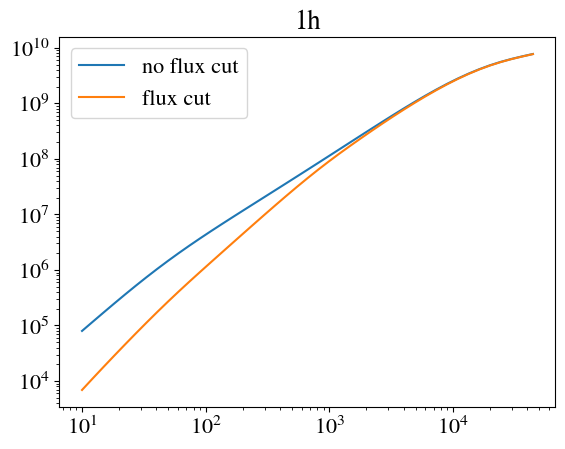

In [132]:
plt.plot(cl_cib_cib_noflux_cut['353x353']['ell'],cl_cib_cib_noflux_cut['353x353']['1h'],label='no flux cut')
plt.plot(cl_cib_cib_noflux_cut['353x353']['ell'],cl_cib_cib_flux_cut['353x353']['1h'],label='flux cut')
plt.legend()
plt.loglog()
plt.title('1h')

Text(0.5, 1.0, '2h')

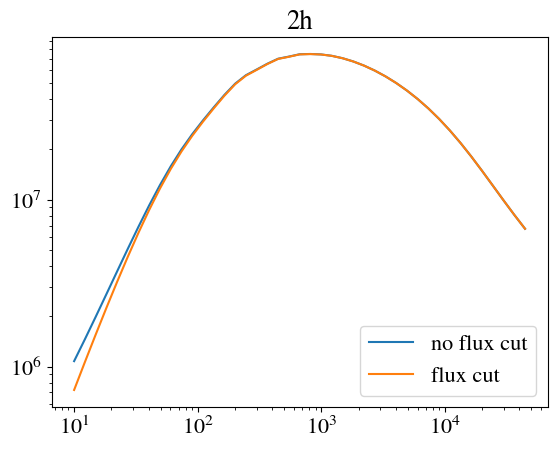

In [133]:
plt.plot(cl_cib_cib_noflux_cut['353x353']['ell'],cl_cib_cib_noflux_cut['353x353']['2h'],label='no flux cut')
plt.plot(cl_cib_cib_noflux_cut['353x353']['ell'],cl_cib_cib_flux_cut['353x353']['2h'],label='flux cut')
plt.legend()
plt.loglog()
plt.title('2h')

# load the planck cib templates

In [58]:
fname_planck  = "/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_all.dat"
data = np.loadtxt(fname_planck, usecols = (0,7,12,16,19)) # Pour avoir le template à 143,217,353,545GHz
ell_planck = data[:,0]
cl_planck_Jy = data[:,1:]

cl_planck_143 = cl_planck_Jy[:,0]
cl_planck_217 = cl_planck_Jy[:,1]
cl_planck_545 = cl_planck_Jy[:,3]

In [59]:
A_c_217 = 63.9 # mean from ps analysis
eA_c_217 = 6.6 # 1-sigma from ps analysis
norm_217 = cl_planck_217[3000]
print(norm_217*(483.690)**-2.*3000*3001/2./np.pi) # (483.690)**-2.: Jy->uK, *3000*3001/2./np.pi: cl -> dl; expected A_cib^217 = 63.6..., amplitude of template

A_c_217 = 63.9 # mean from ps analysis
eA_c_217 = 6.6 # 1-sigma from ps analysis
cl_planck_143_from_217  = cl_planck_143/norm_217*A_c_217/(3000*3001/2./np.pi)*(483.690)**2

62.06604390977783


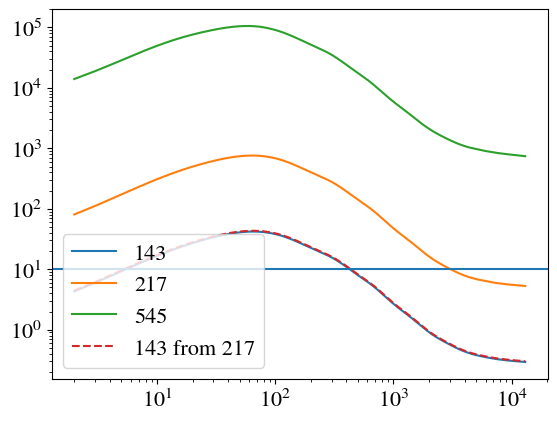

In [60]:
plt.plot(ell_planck,cl_planck_143,label='143')
plt.plot(ell_planck,cl_planck_217,label='217')
plt.plot(ell_planck,cl_planck_545,label='545')
plt.plot(ell_planck,cl_planck_143_from_217,label='143 from 217',ls='--')
plt.axhline(norm_217)
plt.loglog()
plt.legend()
         

In [330]:
cl_planck_Jy.size/ell_planck.size

4.0

In [331]:
np.shape(cl_planck_Jy)

(13000, 4)

In [ ]:
# the planck lkl works like this:
#         ell = spec[:,0].astype(int)
#         self._cl = np.zeros((max(ell)+1, 4))
#         self._cl[ell,0] = spec[:,1] * (4096.68168783 / 1e6) ** 2.0
#         self._cl[ell,1] = spec[:,7] * (2690.05218701 / 1e6) ** 2.0
#         self._cl[ell,2] = spec[:,8] * (2690.05218701 / 1e6) * (2067.43988919 / 1e6) # bb cross: 143x217
#         self._cl[ell,3] = spec[:,12] * (2067.43988919 / 1e6) ** 2.0
        
#         ls = np.arange(self._cl.shape[0])[...,np.newaxis]
#         norm = self._cl[3000, 3]
#         self._cl = (self._cl / norm) * ls * (ls + 1.0) / (3000.0 * 3001.0)
# see https://github.com/simonsobs/LAT_MFLike/blob/3ddefa827830d3d3815aa7c0fb97b97174424a49/plikmflike/fgspectra/power.py#L122

# sampling the poisson and Ac from the planck chains 

In [377]:
path_to_planck_chain = '/Users/boris/COM_CosmoParams_base-plikHM-TT-lowTEB_R2.00/base/plikHM_TT_lowTEB/base_plikHM_TT_lowTEB_4.txt'
planck_chain = np.loadtxt(path_to_planck_chain)

In [385]:
A_cib_planck = planck_chain[:,9]
A_ps_planck_143 = planck_chain[:,13]
A_ps_planck_217 = planck_chain[:,15]

# tsz bispectrum

## compute 

In [5]:
L0_websky = 4.461102571695613e-07

In [6]:
M = Class()
M.set({'output':'tSZ_1h,tSZ_2h,tSZ_tSZ_tSZ_1h,tSZ_tSZ_tSZ_2h,tSZ_tSZ_tSZ_3h'})

M.set({
'bispectrum_lambda_2' :  1.,
'bispectrum_lambda_3' :  1.
})

M.set(common_settings)
M.set(websky_cosmo)
M.set(websky_cib_params)
M.set(tsz_params)


M.compute()

In [7]:
cl_sz = M.cl_sz()
b_yyy = M.b_yyy()

## plot tsz auto power spectrum

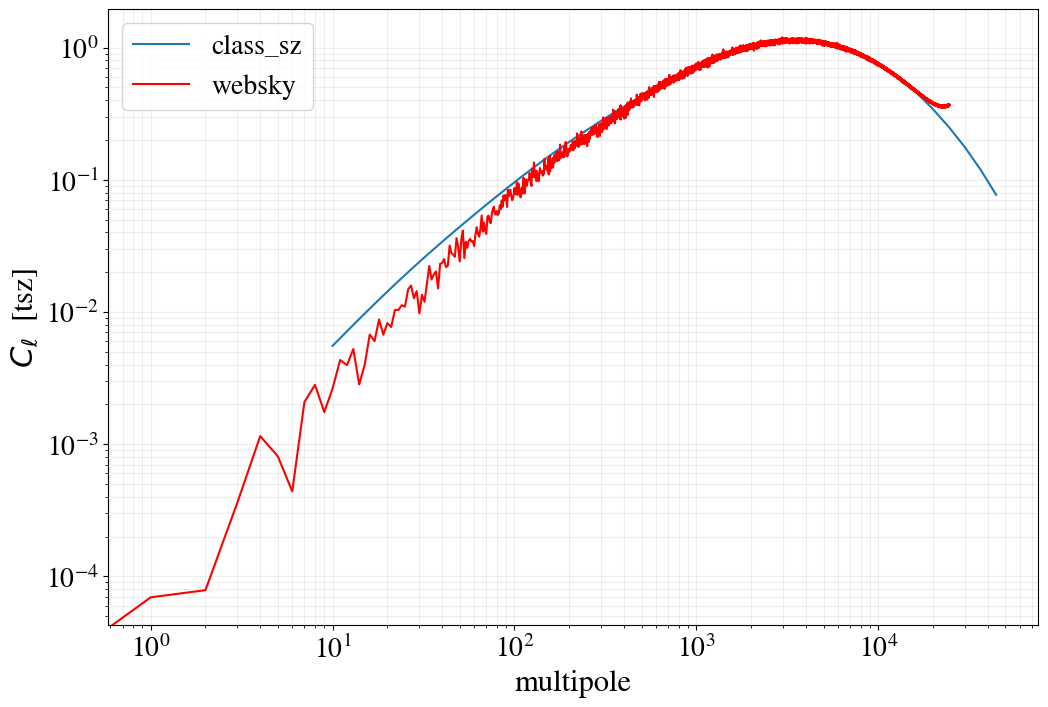

In [8]:
plt.figure(figsize=(12,8))

ls_ws,dls_ws = np.loadtxt(path_to_files+'websky_april_8192.txt',unpack=True)

plt.loglog(cl_sz['ell'],np.asarray(cl_sz['1h'])+np.asarray(cl_sz['2h']),label='class_sz')
plt.loglog(ls_ws,dls_ws*1e12,c='r',label='websky')
# plt.grid(which='both',alpha=0.2)
plt.loglog()
# plt.xlim(20,2e4)
# plt.ylim(1,5e5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [tsz]',fontsize=22)
# plt.title('353x353')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)

## plot tsz bispectrum

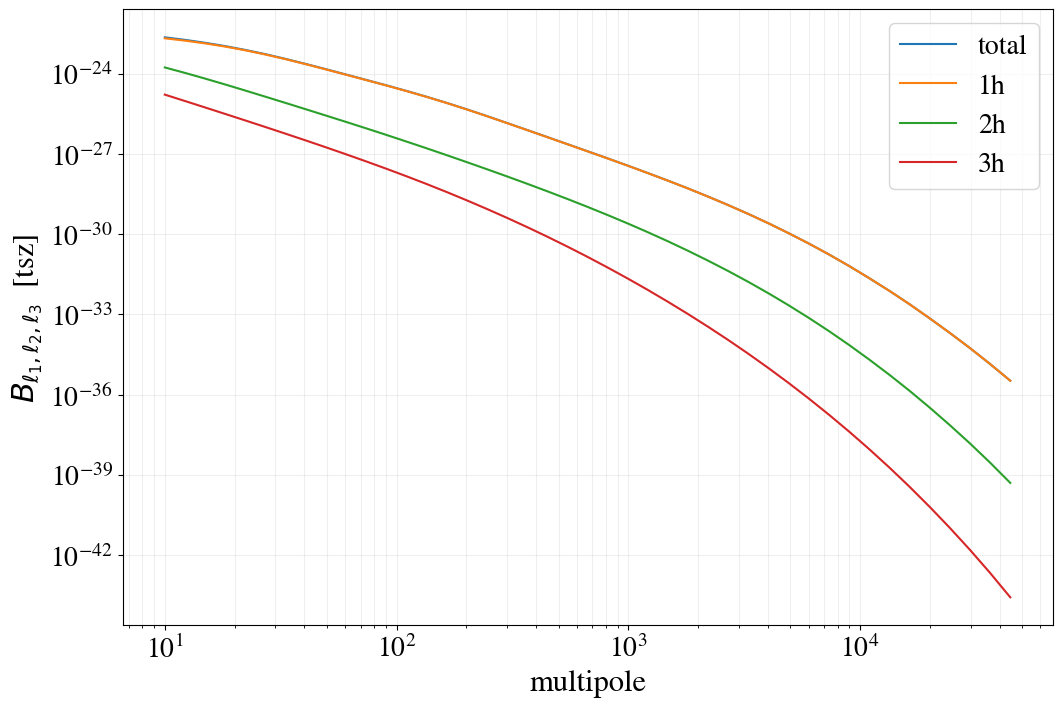

In [9]:
plt.figure(figsize=(12,8))

# ls_ws,dls_ws = np.loadtxt(path_to_files+'websky_april_8192.txt',unpack=True)

plt.loglog(b_yyy['ell'],np.asarray(b_yyy['1h'])+np.asarray(b_yyy['2h'])+np.asarray(b_yyy['3h']),label='total')
plt.loglog(b_yyy['ell'],np.asarray(b_yyy['1h']),label='1h')
plt.loglog(b_yyy['ell'],np.asarray(b_yyy['2h']),label='2h')
plt.loglog(b_yyy['ell'],np.asarray(b_yyy['3h']),label='3h')
# plt.loglog(ls_ws,dls_ws*1e12,c='r',label='websky')
# plt.grid(which='both',alpha=0.2)
plt.loglog()
# plt.xlim(20,2e4)
# plt.ylim(1,5e5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$B_{\ell_1,\ell_2,\ell_3}$  [tsz]',fontsize=22)
# plt.title('353x353')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)

## save bispectrum

In [11]:
np.savetxt('bispec_equi_websky_161222.txt',np.c_[np.asarray(b_yyy['ell']),np.asarray(b_yyy['1h'])+np.asarray(b_yyy['2h'])+np.asarray(b_yyy['3h'])])

# cib shotnoise calculations

In [3]:
L0_websky = 4.461102571695613e-07

In [4]:
M = Class()
M.set({'output':'cib_monopole,cib_cib_1h,cib_cib_2h,cib_shotnoise'})
M.set(common_settings)
M.set(websky_cosmo)
M.set(websky_cib_params)

M.set({'Normalisation of L − M relation in [Jy MPc2/Msun]' :L0_websky,
       'cib_frequency_list_num' : 3,
       'cib_frequency_list_in_GHz' : '353,143,217',  
      })
M.compute()

In [5]:
cl_cib_cib = M.cl_cib_cib()
cib_monopole = M.cib_monopole()
cl_cib_shotnoise = M.cib_shotnoise()

In [6]:
cl_cib_shotnoise

{'nu': [353.0, 143.0, 217.0],
 'shotnoise': [5651.512815681344, 15.2098282840068, 249.73646482078195]}

with flux cut:

In [21]:
M = Class()
M.set({'output':'cib_monopole,cib_cib_1h,cib_cib_2h,cib_shotnoise'})
M.set(common_settings)
M.set(websky_cosmo)
M.set(websky_cib_params)

M.set({'Normalisation of L − M relation in [Jy MPc2/Msun]' :L0_websky,
       'cib_frequency_list_num' : 3,
       'cib_frequency_list_in_GHz' : '353,143,217',  
# table 1 of https://arxiv.org/pdf/1309.0382.pdf
#1: freq GHz 2: Flux cut mJy
# 100 - 400
# 143 - 350
# 217 - 225
# 353 - 315
# 545 - 350
# 857 - 710
# 3000  - 1000
#cib_Snu_1 = 315.
#cib_Snu_2 = 315.
        # 'cib_Snu_cutoff_list [mJy]':'315,350,225',
       'cib_Snu_cutoff_list [mJy]':'400,400,400', # websky cutoff
        'has_cib_flux_cut': 1
      })
M.compute()

In [22]:
cl_cib_cib_flux_cut = M.cl_cib_cib()
cib_monopole_flux_cut = M.cib_monopole()
cl_cib_shotnoise_flux_cut = M.cib_shotnoise()

In [23]:
cl_cib_shotnoise_flux_cut

{'nu': [353.0, 143.0, 217.0],
 'shotnoise': [995.7003857613385, 7.741801092423215, 77.5666886606382]}

CIB Power spectra

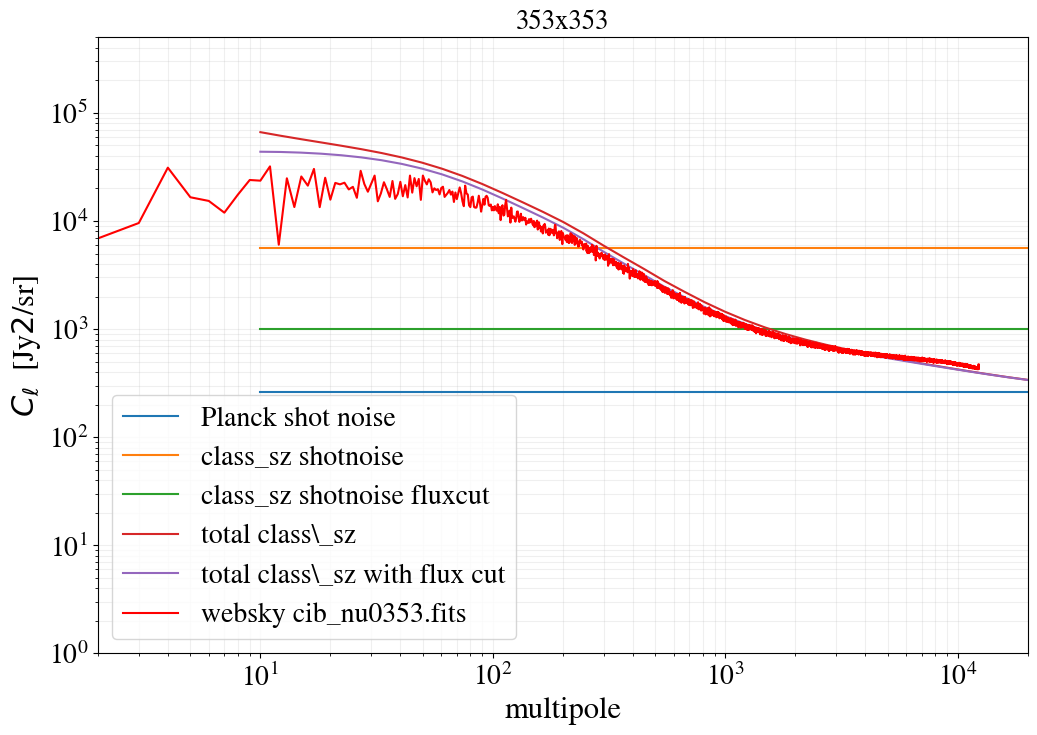

In [24]:
plt.figure(figsize=(12,8))


l_csz = np.asarray(cl_cib_cib['353x353']['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi

cls_csz_1h = np.asarray(cl_cib_cib['353x353']['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib['353x353']['2h'])/cls_to_dls

cls_csz_1h_flux_cut = np.asarray(cl_cib_cib_flux_cut['353x353']['1h'])/cls_to_dls
cls_csz_2h_flux_cut = np.asarray(cl_cib_cib_flux_cut['353x353']['2h'])/cls_to_dls


planck_shot_noise = 262*l_csz/l_csz
plt.plot(l_csz,planck_shot_noise,label='Planck shot noise')

plt.plot(l_csz,np.repeat(cl_cib_shotnoise['shotnoise'][0],len(l_csz)),label='class_sz shotnoise')

plt.plot(l_csz,np.repeat(cl_cib_shotnoise_flux_cut['shotnoise'][0],len(l_csz)),label='class_sz shotnoise fluxcut')


plt.plot(l_csz,(cls_csz_1h+cls_csz_2h)+planck_shot_noise,label='total class\_sz')
plt.plot(l_csz,(cls_csz_1h_flux_cut+cls_csz_2h_flux_cut)+planck_shot_noise,label='total class\_sz with flux cut')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_353_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,c='r',label='websky cib_nu0353.fits')




plt.loglog()
plt.xlim(2,2e4)
plt.ylim(1,5e5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [Jy$2$/sr]',fontsize=22)
plt.title('353x353')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)


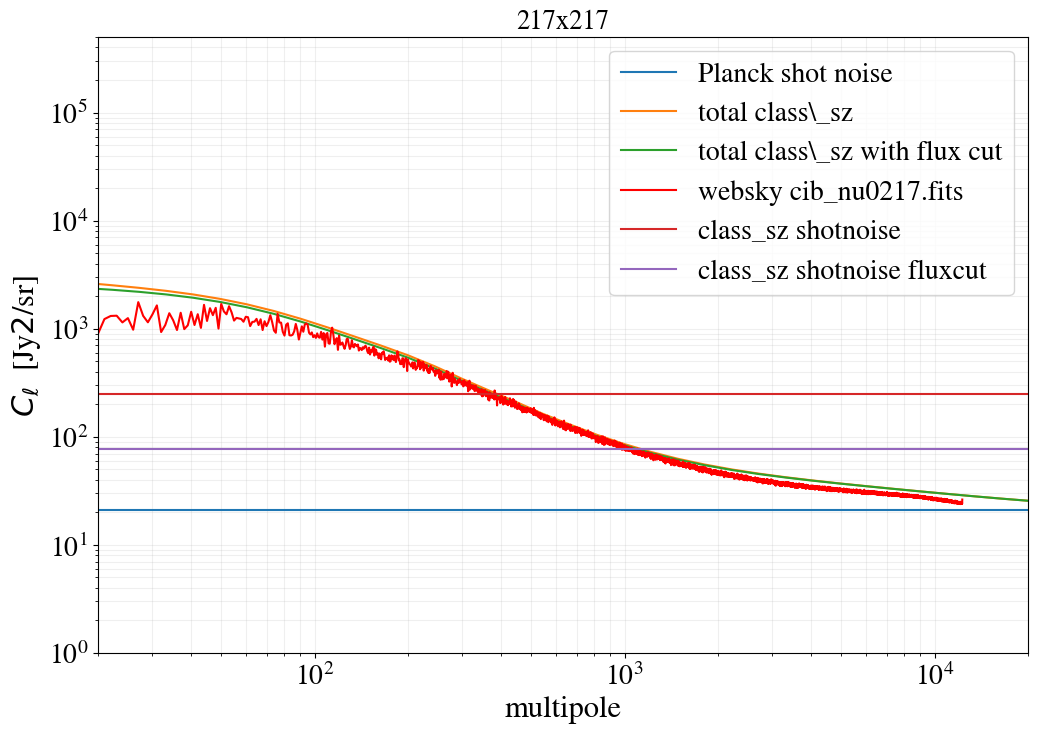

In [26]:
plt.figure(figsize=(12,8))

l_csz = np.asarray(cl_cib_cib['217x217']['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_cib_cib['217x217']['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib['217x217']['2h'])/cls_to_dls

cls_csz_1h_flux_cut = np.asarray(cl_cib_cib_flux_cut['217x217']['1h'])/cls_to_dls
cls_csz_2h_flux_cut = np.asarray(cl_cib_cib_flux_cut['217x217']['2h'])/cls_to_dls

# plt.plot(l_csz,cls_csz_1h,c='k',label='class_sz 1h',ls='-.')
# plt.plot(l_csz,cls_csz_2h,c='k',label='class_sz 2h')

planck_shot_noise = 21.*l_csz/l_csz
plt.plot(l_csz,planck_shot_noise,label='Planck shot noise')


plt.plot(l_csz,(cls_csz_1h+cls_csz_2h)+planck_shot_noise,label='total class\_sz')
plt.plot(l_csz,(cls_csz_1h_flux_cut+cls_csz_2h_flux_cut)+planck_shot_noise,label='total class\_sz with flux cut')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_217_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,c='r',label='websky cib_nu0217.fits')


# l_fm,cls_fm_1h = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_files/cib_1h_353x353.txt',unpack=True)
# l_fm,cls_fm_2h = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_files/cib_2h_353x353.txt',unpack=True)

# cls_fm_1h *= 1./(l_fm*(l_fm+1.)/2./np.pi) 
# cls_fm_2h *= 1./(l_fm*(l_fm+1.)/2./np.pi) 
# plt.plot(l_fm,cls_fm_1h,lw=0.5,c='grey',ls='-.',label='Fiona+Mat 1h')
# plt.plot(l_fm,cls_fm_2h,lw=0.5,c='grey',label='Fiona+Mat 2h')
plt.plot(l_csz,np.repeat(cl_cib_shotnoise['shotnoise'][2],len(l_csz)),label='class_sz shotnoise')

plt.plot(l_csz,np.repeat(cl_cib_shotnoise_flux_cut['shotnoise'][2],len(l_csz)),label='class_sz shotnoise fluxcut')




plt.loglog()
plt.xlim(20,2e4)
plt.ylim(1,5e5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [Jy$2$/sr]',fontsize=22)
plt.title('217x217')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)


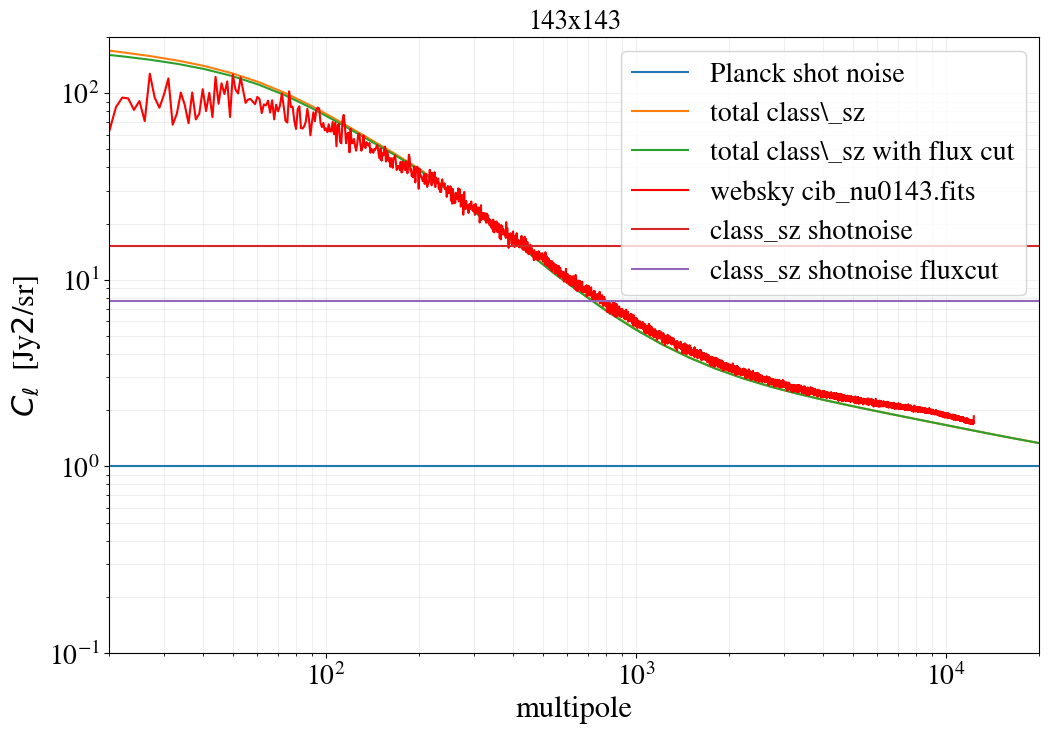

In [29]:
plt.figure(figsize=(12,8))

l_csz = np.asarray(cl_cib_cib['143x143']['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_cib_cib['143x143']['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib['143x143']['2h'])/cls_to_dls

cls_csz_1h_flux_cut = np.asarray(cl_cib_cib_flux_cut['143x143']['1h'])/cls_to_dls
cls_csz_2h_flux_cut = np.asarray(cl_cib_cib_flux_cut['143x143']['2h'])/cls_to_dls

# plt.plot(l_csz,cls_csz_1h,c='k',label='class_sz 1h',ls='-.')
# plt.plot(l_csz,cls_csz_2h,c='k',label='class_sz 2h')

planck_shot_noise = 1.*l_csz/l_csz
plt.plot(l_csz,planck_shot_noise,label='Planck shot noise')


plt.plot(l_csz,(cls_csz_1h+cls_csz_2h)+planck_shot_noise,label='total class\_sz')
plt.plot(l_csz,(cls_csz_1h_flux_cut+cls_csz_2h_flux_cut)+planck_shot_noise,label='total class\_sz with flux cut')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_143_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,c='r',label='websky cib_nu0143.fits')


plt.plot(l_csz,np.repeat(cl_cib_shotnoise['shotnoise'][1],len(l_csz)),label='class_sz shotnoise')

plt.plot(l_csz,np.repeat(cl_cib_shotnoise_flux_cut['shotnoise'][1],len(l_csz)),label='class_sz shotnoise fluxcut')



# l_fm,cls_fm_1h = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_files/cib_1h_353x353.txt',unpack=True)
# l_fm,cls_fm_2h = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_files/cib_2h_353x353.txt',unpack=True)

# cls_fm_1h *= 1./(l_fm*(l_fm+1.)/2./np.pi) 
# cls_fm_2h *= 1./(l_fm*(l_fm+1.)/2./np.pi) 
# plt.plot(l_fm,cls_fm_1h,lw=0.5,c='grey',ls='-.',label='Fiona+Mat 1h')
# plt.plot(l_fm,cls_fm_2h,lw=0.5,c='grey',label='Fiona+Mat 2h')



plt.loglog()
plt.xlim(20,2e4)
plt.ylim(1e-1,2e2)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [Jy$2$/sr]',fontsize=22)
plt.title('143x143')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)


# L0 from 545

In [30]:
L0_websky = 4e-07

In [31]:
M = Class()
M.set({'output':'cib_monopole,cib_cib_1h,cib_cib_2h,cib_shotnoise'})
M.set(common_settings)
M.set(websky_cosmo)
M.set(websky_cib_params)

M.set({'Normalisation of L − M relation in [Jy MPc2/Msun]' :L0_websky,
       'cib_frequency_list_num' : 1,
       'cib_frequency_list_in_GHz' : '545',  
      })
M.compute()

In [32]:
cl_cib_cib = M.cl_cib_cib()
cib_monopole = M.cib_monopole()
cl_cib_shotnoise = M.cib_shotnoise()

In [33]:
cl_cib_shotnoise

{'nu': [545.0], 'shotnoise': [59161.37379665837]}

with flux cut:

In [40]:
M = Class()
M.set({'output':'cib_monopole,cib_cib_1h,cib_cib_2h,cib_shotnoise'})
M.set(common_settings)
M.set(websky_cosmo)
M.set(websky_cib_params)

M.set({'Normalisation of L − M relation in [Jy MPc2/Msun]' :L0_websky,
       'cib_frequency_list_num' : 1,
       'cib_frequency_list_in_GHz' : '545',  
# table 1 of https://arxiv.org/pdf/1309.0382.pdf
#1: freq GHz 2: Flux cut mJy
# 100 - 400
# 143 - 350
# 217 - 225
# 353 - 315
# 545 - 350
# 857 - 710
# 3000  - 1000
#cib_Snu_1 = 315.
#cib_Snu_2 = 315.
        # 'cib_Snu_cutoff_list [mJy]':'315,350,225',
       'cib_Snu_cutoff_list [mJy]':'400', # websky cutoff
        'has_cib_flux_cut': 1
      })
M.compute()

In [41]:
cl_cib_cib_flux_cut = M.cl_cib_cib()
cib_monopole_flux_cut = M.cib_monopole()
cl_cib_shotnoise_flux_cut = M.cib_shotnoise()

In [42]:
cl_cib_shotnoise_flux_cut

{'nu': [545.0], 'shotnoise': [5976.638065183847]}

In [43]:
fname_planck  = "/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_all.dat"
data = np.loadtxt(fname_planck, usecols = (0,7,12,16,19)) # Pour avoir le template à 143,217,353,545GHz
ell_planck = data[:,0]
cl_planck_Jy = data[:,1:]

cl_planck_143 = cl_planck_Jy[:,0]
cl_planck_217 = cl_planck_Jy[:,1]
cl_planck_545 = cl_planck_Jy[:,3]

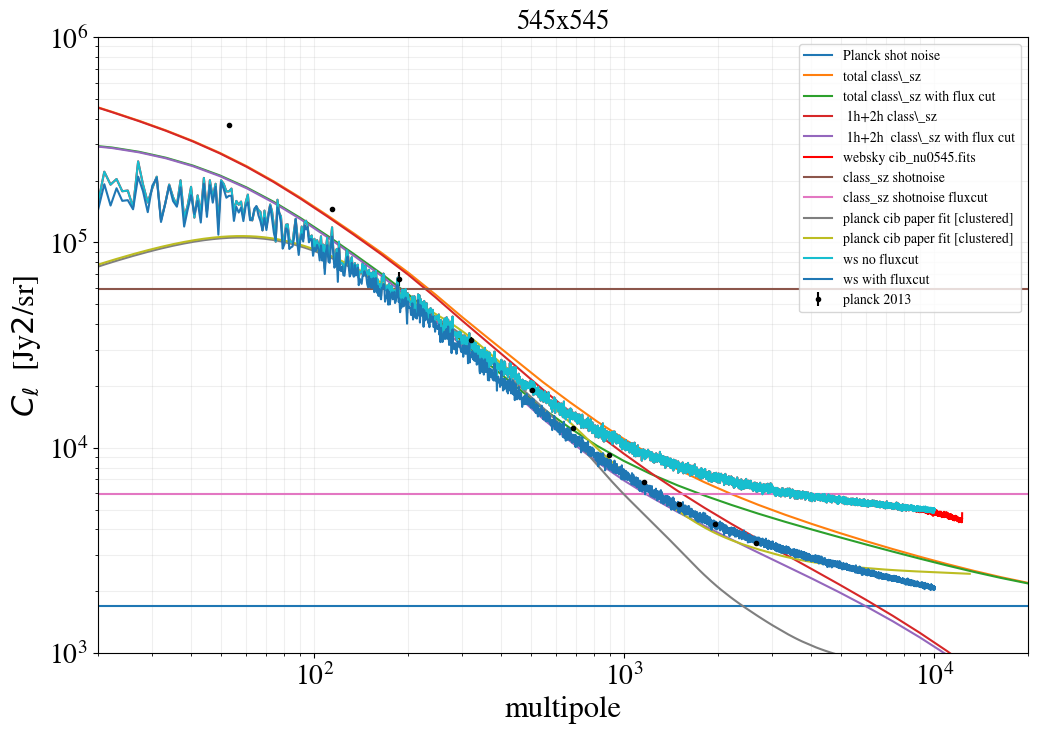

In [44]:
plt.figure(figsize=(12,8))

l_csz = np.asarray(cl_cib_cib['545x545']['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_cib_cib['545x545']['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib['545x545']['2h'])/cls_to_dls

cls_csz_1h_flux_cut = np.asarray(cl_cib_cib_flux_cut['545x545']['1h'])/cls_to_dls
cls_csz_2h_flux_cut = np.asarray(cl_cib_cib_flux_cut['545x545']['2h'])/cls_to_dls

# plt.plot(l_csz,cls_csz_1h,c='k',label='class_sz 1h',ls='-.')
# plt.plot(l_csz,cls_csz_2h,c='k',label='class_sz 2h')

planck_shot_noise = 1690.*l_csz/l_csz # 1690 pm 45 - 
plt.plot(l_csz,planck_shot_noise,label='Planck shot noise')


plt.plot(l_csz,(cls_csz_1h+cls_csz_2h)+planck_shot_noise,label='total class\_sz')
plt.plot(l_csz,(cls_csz_1h_flux_cut+cls_csz_2h_flux_cut)+planck_shot_noise,label='total class\_sz with flux cut')

plt.plot(l_csz,(cls_csz_1h+cls_csz_2h),label=' 1h+2h class\_sz')
plt.plot(l_csz,(cls_csz_1h_flux_cut+cls_csz_2h_flux_cut),label=' 1h+2h  class\_sz with flux cut')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_545_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,c='r',label='websky cib_nu0545.fits')


plt.plot(l_csz,np.repeat(cl_cib_shotnoise['shotnoise'][0],len(l_csz)),label='class_sz shotnoise')

plt.plot(l_csz,np.repeat(cl_cib_shotnoise_flux_cut['shotnoise'][0],len(l_csz)),label='class_sz shotnoise fluxcut')



# l_fm,cls_fm_1h = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_files/cib_1h_353x353.txt',unpack=True)
# l_fm,cls_fm_2h = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_files/cib_2h_353x353.txt',unpack=True)

# cls_fm_1h *= 1./(l_fm*(l_fm+1.)/2./np.pi) 
# cls_fm_2h *= 1./(l_fm*(l_fm+1.)/2./np.pi) 
# plt.plot(l_fm,cls_fm_1h,lw=0.5,c='grey',ls='-.',label='Fiona+Mat 1h')
# plt.plot(l_fm,cls_fm_2h,lw=0.5,c='grey',label='Fiona+Mat 2h')


plt.plot(ell_planck,cl_planck_545,label='planck cib paper fit [clustered]')
plt.plot(ell_planck,cl_planck_545+1690.*np.repeat(1,len(ell_planck)),label='planck cib paper fit [clustered]')

freq = '545x545'
pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'],
             planck_2013[freq]['cl'],
             yerr=planck_2013[freq]['ecl'],
             marker= 'o',
             markersize=3.,
             ls='None',
             c='k',
             label = 'planck 2013')



l = np.arange(10001)
plt.plot(l,1e12*cl_cib_websky_nofluxcut[3],label='ws no fluxcut')


l = np.arange(10001)
plt.plot(l,cl_cib_websky_fluxcut[3],label='ws with fluxcut')


plt.loglog()
plt.xlim(20,2e4)
plt.ylim(1e3,1e6)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [Jy$2$/sr]',fontsize=22)
plt.title('545x545')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=10)


# Websky halo mass function

In [77]:
import healpy as hp

omegab = websky_Omega_B
omegac = websky_Omega_M-websky_Omega_B
omegam = omegab + omegac
h      = websky_h
ns     = websky_n_s
sigma8 = websky_sigma_8

c = 3e5

H0 = 100*h
nz = 100000
z1 = 0.0
z2 = 6.0
za = np.linspace(z1,z2,nz)
dz = za[1]-za[0]

H      = lambda z: H0*np.sqrt(omegam*(1+z)**3+1-omegam)
dchidz = lambda z: c/H(z)

chia = np.cumsum(dchidz(za))*dz

zofchi = interp1d(chia,za)

# from   cosmology import *
def makeACTName(RADeg, decDeg, prefix = 'ACT-CL'):
    """Makes ACT cluster name from RADeg, decDeg
    
    """
    
    actName=prefix+" J"+makeRA(RADeg)+makeDec(decDeg)
    
    return actName

def makeRA(myRADeg):
    """Makes RA part of ACT names.
    
    """
    hours=(myRADeg/360)*24
    if hours<10:
        sHours="0"+str(hours)[0]
    else:
        sHours=str(hours)[:2]
    
    mins=float(str(hours)[str(hours).index("."):])*60
    if mins<10:
        sMins="0"+str(mins)[:3]
    else:
        sMins=str(mins)[:4]
        
    return (sHours+sMins)#[:-2] # Trims off .x as not used in ACT names
        
#------------------------------------------------------------------------------------------------------------
def makeDec(myDecDeg):
    """Makes dec part of ACT names
    
    """
    
    # Positive
    if myDecDeg>0:
        if myDecDeg<10:
            sDeg="0"+str(myDecDeg)[0]
        else:
            sDeg=str(myDecDeg)[:2]
    
        mins=float(str(myDecDeg)[str(myDecDeg).index("."):])*60
        if mins<10:
            sMins="0"+str(mins)[:1]
        else:
            sMins=str(mins)[:2]
        
        return "+"+sDeg+sMins
    else:
        if myDecDeg>-10:
            sDeg="-0"+str(myDecDeg)[1]
        else:
            sDeg=str(myDecDeg)[:3]
    
        mins=float(str(myDecDeg)[str(myDecDeg).index("."):])*60
        if mins<10:
            sMins="0"+str(mins)[:1]
        else:
            sMins=str(mins)[:2]
        
        return str(sDeg+sMins)

omegam = M.Omega_m()
h = M.h()
rho = 2.775e11*omegam*h**2 # Msun/Mpc^3
path_to_catalogue_websky = '/Users/boris/Work/CLASS-SZ/SO-SZ/so_cluster_counts/'
f=open(path_to_catalogue_websky+'halos.pksc')
N=np.fromfile(f,count=3,dtype=np.int32)[0]

# only take first five entries for testing (there are ~8e8 halos total...)
# comment the following line to read in all halos
# ordered by decreasing mass
N = 800000
# N = 862923142

catalog=np.fromfile(f,count=N*10,dtype=np.float32)
catalog=np.reshape(catalog,(N,10))

x  = catalog[:,0];  y = catalog[:,1];  z = catalog[:,2] # Mpc (comoving)
vx = catalog[:,3]; vy = catalog[:,4]; vz = catalog[:,5] # km/sec
R  = catalog[:,6] # Mpc

# convert to mass, comoving distance, radial velocity, redshfit, RA and DEc
M200m    = 4*np.pi/3.*rho*R**3        # this is M200m (mean density 200 times mean) in Msun
chi      = np.sqrt(x**2+y**2+z**2)    # Mpc
vrad     = (x*vx + y*vy + z*vz) / chi # km/sec
redshift = zofchi(chi)      

theta, phi  = hp.vec2ang(np.column_stack((x,y,z))) # in radians

decDeg=-1*(np.degrees(theta)-90) # Because HEALPix
RADeg=np.degrees(phi)


### e.g. project to a map, matching the websky orientations
#nside = 1024
#map   = np.zeros((hp.nside2npix(nside)))

#pix = hp.vec2pix(nside, x, y, z)
#pix = hp.ang2pix(nside, theta, phi) does the same

#weight = 1. #1 for number density, array of size(x) for arbitrary
#np.add.at(map, pix, weight)

ModuleNotFoundError: No module named 'healpy'

# Compare all websky with class_sz and planck

In [6]:
L0_websky = 4e-07

In [14]:
M = Class()
M.set({'output':'cib_monopole,cib_cib_1h,cib_cib_2h,cib_shotnoise'})
M.set(common_settings)
M.set(websky_cosmo)
M.set(websky_cib_params)

M.set({
'M_min_subhalo_in_Msun' : 1e10,
})

M.set({'Normalisation of L − M relation in [Jy MPc2/Msun]' :L0_websky,
       'cib_frequency_list_num' : 5,
       'cib_frequency_list_in_GHz' : '143,217,353,545,857',  
      })
M.compute()

In [15]:
cl_cib_cib = M.cl_cib_cib()
cib_monopole = M.cib_monopole()
cl_cib_shotnoise = M.cib_shotnoise()

In [16]:
cl_cib_shotnoise

{'nu': [143.0, 217.0, 353.0, 545.0, 857.0],
 'shotnoise': [10.204597622628368,
  168.04843614522784,
  3820.3067571269935,
  49975.18183352494,
  500759.65416988893]}

with flux cut:

In [51]:
M = Class()
M.set({'output':'cib_monopole,cib_cib_1h,cib_cib_2h,cib_shotnoise'})
M.set(common_settings)
M.set(websky_cosmo)
M.set(websky_cib_params)

M.set({'Normalisation of L − M relation in [Jy MPc2/Msun]' :L0_websky,
       'cib_frequency_list_num' : 5,
       'cib_frequency_list_in_GHz' : '143,217,353,545,857',  
# table 1 of https://arxiv.org/pdf/1309.0382.pdf
#1: freq GHz 2: Flux cut mJy
# 100 - 400
# 143 - 350
# 217 - 225
# 353 - 315
# 545 - 350
# 857 - 710
# 3000  - 1000
#cib_Snu_1 = 315.
#cib_Snu_2 = 315.
        # 'cib_Snu_cutoff_list [mJy]':'315,350,225',
       'cib_Snu_cutoff_list [mJy]':'400,400,400,400,400', # websky cutoff
        'has_cib_flux_cut': 1
      })
M.compute()

In [52]:
cl_cib_cib_flux_cut = M.cl_cib_cib()
cib_monopole_flux_cut = M.cib_monopole()
cl_cib_shotnoise_flux_cut = M.cib_shotnoise()

In [53]:
cl_cib_shotnoise_flux_cut

{'nu': [143.0, 217.0, 353.0, 545.0, 857.0],
 'shotnoise': [6.460675913847957,
  64.31778598436833,
  828.6392786066765,
  5976.638065183847,
  25963.428262092835]}

In [10]:
fname_planck  = "/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_all.dat"
data = np.loadtxt(fname_planck, usecols = (0,7,12,16,19)) # Pour avoir le template à 143,217,353,545GHz
ell_planck = data[:,0]
cl_planck_Jy = data[:,1:]

cl_planck_143 = cl_planck_Jy[:,0]
cl_planck_217 = cl_planck_Jy[:,1]
cl_planck_353 = cl_planck_Jy[:,2]
cl_planck_545 = cl_planck_Jy[:,3]
# cl_planck_857 = cl_planck_Jy[:,4]

In [11]:
nside = 4096
with open(f"/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_files/cl_cib_Jysr_nside{nside}_fluxcutPLANCK_density.pick", "rb") as f:
    cl_cib_websky_fluxcut = pickle.load(f)
with open(f"/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_files/cl_cib_Jysr_nside{nside}_PLANCK_density.pick", "rb") as f:
    cl_cib_websky_nofluxcut = pickle.load(f)

In [12]:
planck_2013 ={
'217x217':{
'cl' : np.asarray([
1.78e3, # < this is an upper bound
8.47e2, # < this is an upper bound
4.17e2, 
2.62e2, 
1.75e2, 
1.17e2, 
8.82e1, 
6.42e1, 
3.34e1, 
4.74e1
]),
'ecl' : np.asarray([
0.,
0., 
0.47e2, 
0.20e2, 
0.13e2, 
0.10e2, 
0.89e1, 
1.61e1, 
2.15e1, 
0.65e1
]),
'ell': np.asarray([
53,
114,
187,
320, 
502, 
684, 
890,
1158, 
1505,
1956
])
},
    
    # '217x217':{'cl':np.asarray([1.78e3, 8.47e2, 4.17e2, 2.62e2, 1.75e2, 1.17e2, 8.82e1, 6.42e1, 3.34e1, 4.74e1]),
    #            'ecl':np.asarray([0.,0., 0.47e2, 0.20e2, 0.13e2, 0.10e2, 0.89e1, 1.61e1, 2.15e1, 0.65e1]),
    #            'ell':np.asarray([53,114,187,320, 502, 684, 890,1158, 1505, 1956])},
    '143x143':{'cl':np.asarray([1.55e2, 6.41e1, 3.64e1, 3.23e1, 2.81e1, 2.27e1, 1.84e1, 1.58e1, 1.25e1]),
               'ecl':np.asarray([0.,0., 0.73e1, 0.35e1, 0.30e1, 0.29e1, 0.35e1, 0.91e1, 1.28e1]),
               'ell':np.asarray([53,114,187,320, 502, 684, 890,1158, 1505])},
    '353x353':{'cl':np.asarray([3.68e4, 1.66e4, 7.88e3, 4.35e3, 2.60e3, 1.74e3, 1.29e3, 9.35e2, 7.75e2, 6.08e2]),
               'ecl':np.asarray([0.,0., 0.53e3, 0.18e3, 0.10e3, 0.07e3, 0.05e3, 0.33e2, 0.22e2, 0.16e2]),
               'ell':np.asarray([53,114,187,320, 502, 684, 890,1158, 1505, 1956])},
    '545x545':{'cl':np.asarray([3.74e5, 1.45e5, 6.63e4, 3.34e4, 1.91e4, 1.25e4, 9.17e3, 6.83e3, 5.34e3, 4.24e3, 3.42e3]),
               'ecl':np.asarray([0.,0., 0.51e4, 0.12e4, 0.04e4, 0.03e4, 0.17e3, 0.10e3, 0.06e3, 0.04e3, 0.04e3]),
               'ell':np.asarray([53,114,187,320, 502, 684, 890,1158, 1505, 1956, 2649])},
    '857x857':{'cl':np.asarray([2.76e6, 7.99e5, 2.87e5, 1.34e5, 7.20e4, 4.38e4, 3.23e4, 2.40e4, 1.83e4, 1.46e4, 1.16e4]),
               'ecl':np.asarray([0.,0., 0.37e5, 0.08e5, 0.26e4, 0.18e4, 0.09e4, 0.05e4, 0.03e4, 0.02e4, 0.01e4]),
               'ell':np.asarray([53,114,187,320, 502, 684, 890,1158, 1505, 1956, 2649])}
}

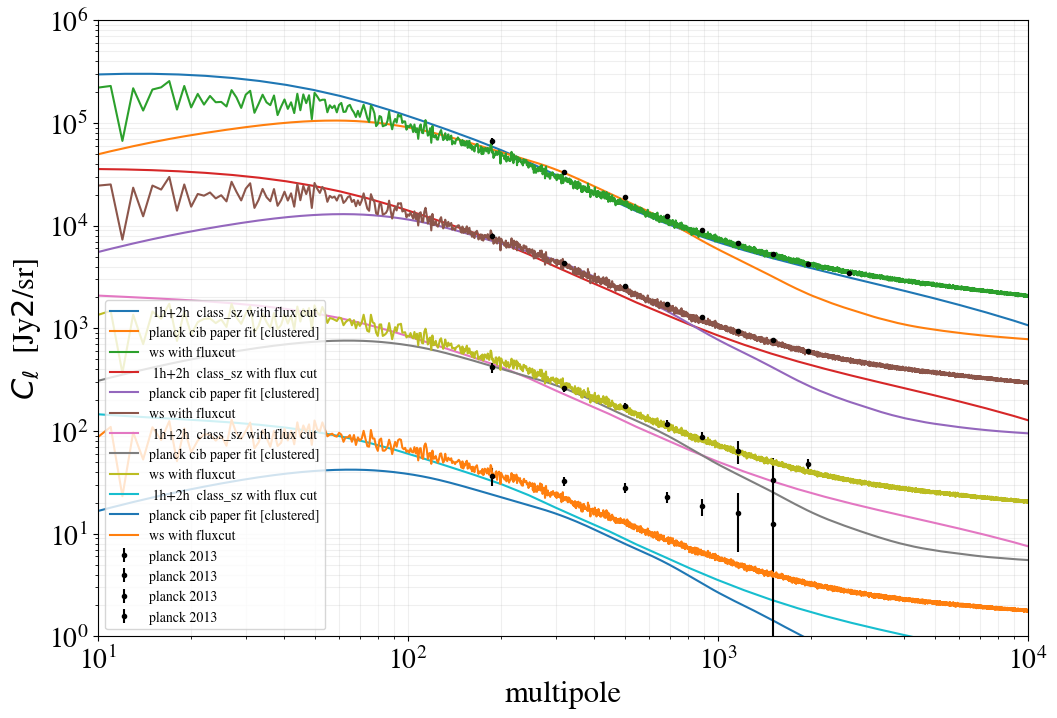

In [68]:
plt.figure(figsize=(12,8))

nuf = '545'
freq = nuf+'x'+nuf

l_csz = np.asarray(cl_cib_cib[freq]['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_cib_cib[freq]['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib[freq]['2h'])/cls_to_dls

cls_csz_1h_flux_cut = np.asarray(cl_cib_cib_flux_cut[freq]['1h'])/cls_to_dls
cls_csz_2h_flux_cut = np.asarray(cl_cib_cib_flux_cut[freq]['2h'])/cls_to_dls

plt.plot(l_csz,(cls_csz_1h_flux_cut+cls_csz_2h_flux_cut),label=' 1h+2h  class_sz with flux cut')


plt.plot(ell_planck,cl_planck_545,label='planck cib paper fit [clustered]')


pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'][2:],
             planck_2013[freq]['cl'][2:],
             yerr=planck_2013[freq]['ecl'][2:],
             marker= 'o',
             markersize=3.,
             ls='None',
             c='k',
             label = 'planck 2013')


l = np.arange(10001)
plt.plot(l,cl_cib_websky_fluxcut[3],label='ws with fluxcut')



# plt.figure(figsize=(12,8))

nuf = '353'
freq = nuf+'x'+nuf

l_csz = np.asarray(cl_cib_cib[freq]['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_cib_cib[freq]['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib[freq]['2h'])/cls_to_dls

cls_csz_1h_flux_cut = np.asarray(cl_cib_cib_flux_cut[freq]['1h'])/cls_to_dls
cls_csz_2h_flux_cut = np.asarray(cl_cib_cib_flux_cut[freq]['2h'])/cls_to_dls

plt.plot(l_csz,(cls_csz_1h_flux_cut+cls_csz_2h_flux_cut),label=' 1h+2h  class_sz with flux cut')


plt.plot(ell_planck,cl_planck_353,label='planck cib paper fit [clustered]')


pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'][2:],
             planck_2013[freq]['cl'][2:],
             yerr=planck_2013[freq]['ecl'][2:],
             marker= 'o',
             markersize=3.,
             ls='None',
             c='k',
             label = 'planck 2013')


l = np.arange(10001)
plt.plot(l,cl_cib_websky_fluxcut[2],label='ws with fluxcut')




nuf = '217'
freq = nuf+'x'+nuf

l_csz = np.asarray(cl_cib_cib[freq]['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_cib_cib[freq]['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib[freq]['2h'])/cls_to_dls

cls_csz_1h_flux_cut = np.asarray(cl_cib_cib_flux_cut[freq]['1h'])/cls_to_dls
cls_csz_2h_flux_cut = np.asarray(cl_cib_cib_flux_cut[freq]['2h'])/cls_to_dls

plt.plot(l_csz,(cls_csz_1h_flux_cut+cls_csz_2h_flux_cut),label=' 1h+2h  class_sz with flux cut')


plt.plot(ell_planck,cl_planck_217,label='planck cib paper fit [clustered]')


pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'][2:],
             planck_2013[freq]['cl'][2:],
             yerr=planck_2013[freq]['ecl'][2:],
             marker= 'o',
             markersize=3.,
             ls='None',
             c='k',
             label = 'planck 2013')


l = np.arange(10001)
plt.plot(l,cl_cib_websky_fluxcut[1],label='ws with fluxcut')




nuf = '143'
freq = nuf+'x'+nuf

l_csz = np.asarray(cl_cib_cib[freq]['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_cib_cib[freq]['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib[freq]['2h'])/cls_to_dls

cls_csz_1h_flux_cut = np.asarray(cl_cib_cib_flux_cut[freq]['1h'])/cls_to_dls
cls_csz_2h_flux_cut = np.asarray(cl_cib_cib_flux_cut[freq]['2h'])/cls_to_dls

plt.plot(l_csz,(cls_csz_1h_flux_cut+cls_csz_2h_flux_cut),label=' 1h+2h  class_sz with flux cut')


plt.plot(ell_planck,cl_planck_143,label='planck cib paper fit [clustered]')


pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'][2:],
             planck_2013[freq]['cl'][2:],
             yerr=planck_2013[freq]['ecl'][2:],
             marker= 'o',
             markersize=3.,
             ls='None',
             c='k',
             label = 'planck 2013')


l = np.arange(10001)
plt.plot(l,cl_cib_websky_fluxcut[0],label='ws with fluxcut')


plt.loglog()
plt.xlim(10,1e4)
plt.ylim(1e0,1e6)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [Jy$2$/sr]',fontsize=22)
# plt.title('545x545')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=10)


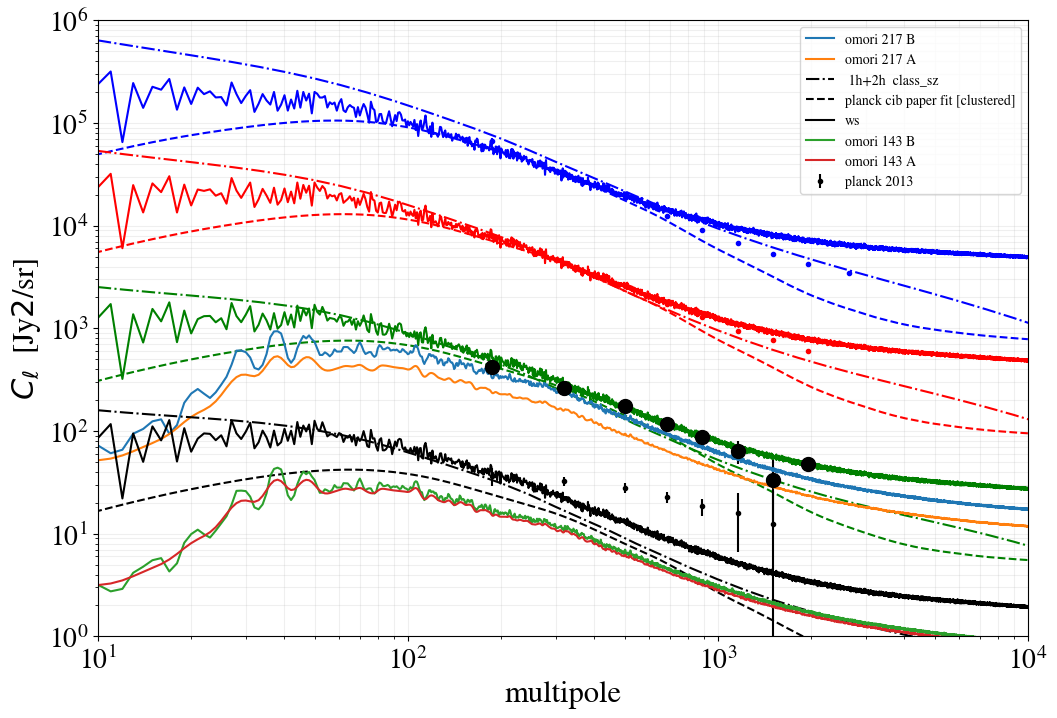

In [17]:
plt.figure(figsize=(12,8))

nuf = '545'
freq = nuf+'x'+nuf

l_csz = np.asarray(cl_cib_cib[freq]['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_cib_cib[freq]['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib[freq]['2h'])/cls_to_dls



plt.plot(l_csz,(cls_csz_1h+cls_csz_2h),ls='-.',
         #label=' 1h+2h  class_sz ',
         c='b')


plt.plot(ell_planck,cl_planck_545,ls='--',
         #label='planck cib paper fit [clustered]',
         c='b')


pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'][2:],
             planck_2013[freq]['cl'][2:],
             yerr=planck_2013[freq]['ecl'][2:],
             marker= 'o',
             markersize=3.,
             ls='None',
             c='b',
            # label = 'planck 2013'
            )


l = np.arange(10001)
plt.plot(l,1e12*cl_cib_websky_nofluxcut[3],
         #label='ws ',
         c='b')


# plt.plot(l,np.repeat(cl_cib_shotnoise['shotnoise'][3],len(l)),c='b',ls=':')

# plt.figure(figsize=(12,8))

nuf = '353'
freq = nuf+'x'+nuf

l_csz = np.asarray(cl_cib_cib[freq]['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_cib_cib[freq]['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib[freq]['2h'])/cls_to_dls



plt.plot(l_csz,(cls_csz_1h+cls_csz_2h),ls='-.',
         #label=' 1h+2h  class_sz',
         c='r')


plt.plot(ell_planck,cl_planck_353,ls='--',
         #label='planck cib paper fit [clustered]',
         c='r')


pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'][2:],
             planck_2013[freq]['cl'][2:],
             yerr=planck_2013[freq]['ecl'][2:],
             marker= 'o',
             markersize=3.,
             ls='None',
             c='r',
             #label = 'planck 2013'
            )


l = np.arange(10001)
plt.plot(l,1e12*cl_cib_websky_nofluxcut[2],
         #label='ws',
         c='r')

# plt.plot(l,np.repeat(cl_cib_shotnoise['shotnoise'][2],len(l)),c='r',ls=':')


nuf = '217'
freq = nuf+'x'+nuf

l_csz = np.asarray(cl_cib_cib[freq]['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_cib_cib[freq]['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib[freq]['2h'])/cls_to_dls


plt.plot(l_csz,(cls_csz_1h+cls_csz_2h),ls='-.',
         #label=' 1h+2h  class_sz',
         c='g')


plt.plot(ell_planck,cl_planck_217,ls='--',
         #label='planck cib paper fit [clustered]',
         c='g')


pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'][2:],
             planck_2013[freq]['cl'][2:],
             yerr=planck_2013[freq]['ecl'][2:],
             marker= 'o',
             markersize=10.,
             ls='None',
             c='k',
             #label = 'planck 2013'
            )


l = np.arange(10001)
plt.plot(l,1e12*cl_cib_websky_nofluxcut[1],
         #label='ws',
         c='g',ls='-')

# plt.plot(l,cl_cib_websky_fluxcut[1],
#          #label='ws',
#          c='g',ls='-.')

# plt.plot(l,np.repeat(cl_cib_shotnoise['shotnoise'][1],len(l)),c='g',ls=':')


cib_omori = np.loadtxt(path_to_files+'cls_mdpl2_len_mag_cibmap_planck_217_217.dat')
plt.plot(cib_omori[:,0],cib_omori[:,1],label='omori 217 B')

cib_omori = np.loadtxt(path_to_files+'cls_mdpl2_v0.7_cib_planck_217ghz.dat')
plt.plot(cib_omori[:,0],cib_omori[:,1]*(483.690)**2.,label='omori 217 A')
# cib_omori_nomask = np.loadtxt(path_to_files+'cls_mdpl2_v0.7_cib_planck_217ghz_nomask.dat')

# plt.plot(cib_omori_nomask[:,0],cib_omori_nomask[:,1]*(483.690)**2.,label='omori no mask')


nuf = '143'
freq = nuf+'x'+nuf

l_csz = np.asarray(cl_cib_cib[freq]['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_cib_cib[freq]['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib[freq]['2h'])/cls_to_dls



plt.plot(l_csz,(cls_csz_1h+cls_csz_2h),ls='-.',
         label=' 1h+2h  class_sz',
         c='k')


plt.plot(ell_planck,cl_planck_143,ls='--',
         label='planck cib paper fit [clustered]',
         c='k')


pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'][2:],
             planck_2013[freq]['cl'][2:],
             yerr=planck_2013[freq]['ecl'][2:],
             marker= 'o',
             markersize=3.,
             ls='None',
             label = 'planck 2013',
             c='k')


l = np.arange(10001)
plt.plot(l,1e12*cl_cib_websky_nofluxcut[0],label='ws',c='k',ls='-')



# plt.plot(l,np.repeat(cl_cib_shotnoise['shotnoise'][0],len(l)),c='k',ls=':')


# cib_omori = np.loadtxt(path_to_files+'cls_mdpl2_v0.7_cib_planck_143ghz.dat')
cib_omori = np.loadtxt(path_to_files+'cls_mdpl2_len_mag_cibmap_planck_143_143.dat')
# cib_omori_nomask = np.loadtxt(path_to_files+'cls_mdpl2_v0.7_cib_planck_143ghz_nomask.dat')
plt.plot(cib_omori[:,0],cib_omori[:,1],label='omori 143 B')
# plt.plot(cib_omori_nomask[:,0],cib_omori_nomask[:,1]*(371.74)**2.,label='omori no mask')
cib_omori = np.loadtxt(path_to_files+'cls_mdpl2_v0.7_cib_planck_143ghz.dat')
# cib_omori_nomask = np.loadtxt(path_to_files+'cls_mdpl2_v0.7_cib_planck_143ghz_nomask.dat')
plt.plot(cib_omori[:,0],cib_omori[:,1]*(371.74)**2.,label='omori 143 A')

plt.loglog()
plt.xlim(10,1e4)
plt.ylim(1e0,1e6)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [Jy$2$/sr]',fontsize=22)
# plt.title('545x545')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=10)


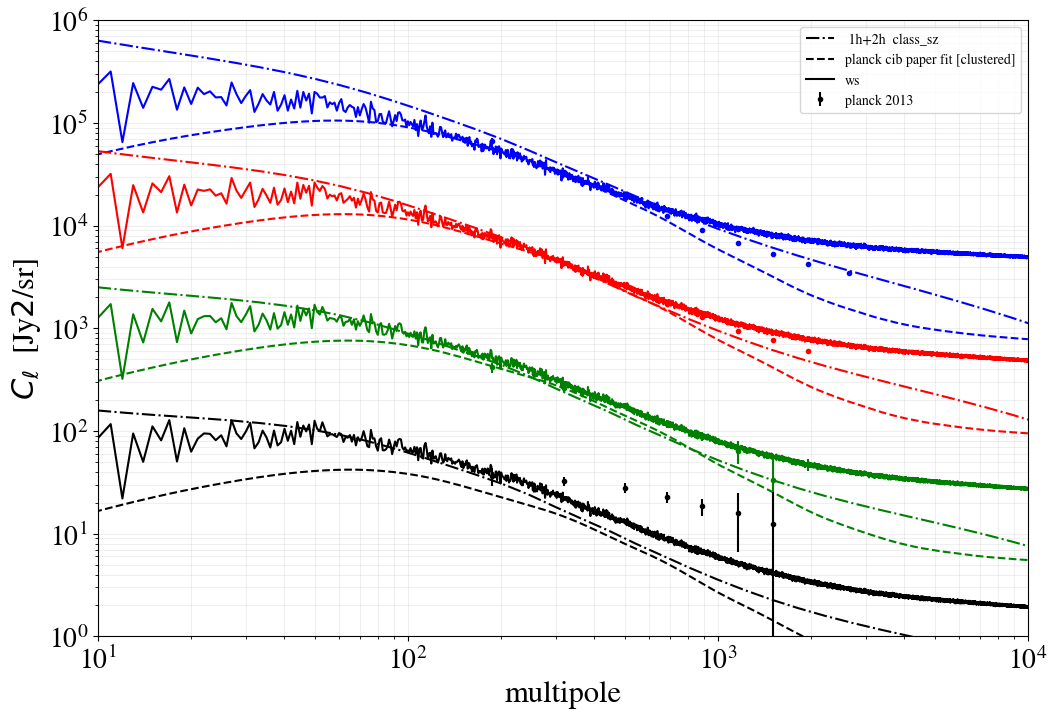

In [19]:
plt.figure(figsize=(12,8))

nuf = '545'
freq = nuf+'x'+nuf

l_csz = np.asarray(cl_cib_cib[freq]['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_cib_cib[freq]['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib[freq]['2h'])/cls_to_dls



plt.plot(l_csz,(cls_csz_1h+cls_csz_2h),ls='-.',
         #label=' 1h+2h  class_sz ',
         c='b')


plt.plot(ell_planck,cl_planck_545,ls='--',
         #label='planck cib paper fit [clustered]',
         c='b')


pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'][2:],
             planck_2013[freq]['cl'][2:],
             yerr=planck_2013[freq]['ecl'][2:],
             marker= 'o',
             markersize=3.,
             ls='None',
             c='b',
            # label = 'planck 2013'
            )


l = np.arange(10001)
plt.plot(l,1e12*cl_cib_websky_nofluxcut[3],
         #label='ws ',
         c='b')


# plt.plot(l,np.repeat(cl_cib_shotnoise['shotnoise'][3],len(l)),c='b',ls=':')

# plt.figure(figsize=(12,8))

nuf = '353'
freq = nuf+'x'+nuf

l_csz = np.asarray(cl_cib_cib[freq]['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_cib_cib[freq]['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib[freq]['2h'])/cls_to_dls



plt.plot(l_csz,(cls_csz_1h+cls_csz_2h),ls='-.',
         #label=' 1h+2h  class_sz',
         c='r')


plt.plot(ell_planck,cl_planck_353,ls='--',
         #label='planck cib paper fit [clustered]',
         c='r')


pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'][2:],
             planck_2013[freq]['cl'][2:],
             yerr=planck_2013[freq]['ecl'][2:],
             marker= 'o',
             markersize=3.,
             ls='None',
             c='r',
             #label = 'planck 2013'
            )


l = np.arange(10001)
plt.plot(l,1e12*cl_cib_websky_nofluxcut[2],
         #label='ws',
         c='r')

# plt.plot(l,np.repeat(cl_cib_shotnoise['shotnoise'][2],len(l)),c='r',ls=':')


nuf = '217'
freq = nuf+'x'+nuf

l_csz = np.asarray(cl_cib_cib[freq]['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_cib_cib[freq]['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib[freq]['2h'])/cls_to_dls


plt.plot(l_csz,(cls_csz_1h+cls_csz_2h),ls='-.',
         #label=' 1h+2h  class_sz',
         c='g')


plt.plot(ell_planck,cl_planck_217,ls='--',
         #label='planck cib paper fit [clustered]',
         c='g')


pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'][2:],
             planck_2013[freq]['cl'][2:],
             yerr=planck_2013[freq]['ecl'][2:],
             marker= 'o',
             markersize=3.,
             ls='None',
             c='g',
             #label = 'planck 2013'
            )


l = np.arange(10001)
plt.plot(l,1e12*cl_cib_websky_nofluxcut[1],
         #label='ws',
         c='g',ls='-')

# plt.plot(l,np.repeat(cl_cib_shotnoise['shotnoise'][1],len(l)),c='g',ls=':')


nuf = '143'
freq = nuf+'x'+nuf

l_csz = np.asarray(cl_cib_cib[freq]['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_cib_cib[freq]['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib[freq]['2h'])/cls_to_dls



plt.plot(l_csz,(cls_csz_1h+cls_csz_2h),ls='-.',
         label=' 1h+2h  class_sz',
         c='k')


plt.plot(ell_planck,cl_planck_143,ls='--',
         label='planck cib paper fit [clustered]',
         c='k')


pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'][2:],
             planck_2013[freq]['cl'][2:],
             yerr=planck_2013[freq]['ecl'][2:],
             marker= 'o',
             markersize=3.,
             ls='None',
             label = 'planck 2013',
             c='k')


l = np.arange(10001)
plt.plot(l,1e12*cl_cib_websky_nofluxcut[0],label='ws',c='k',ls='-')



# plt.plot(l,np.repeat(cl_cib_shotnoise['shotnoise'][0],len(l)),c='k',ls=':')


plt.loglog()
plt.xlim(10,1e4)
plt.ylim(1e0,1e6)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [Jy$2$/sr]',fontsize=22)
# plt.title('545x545')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=10)


[]

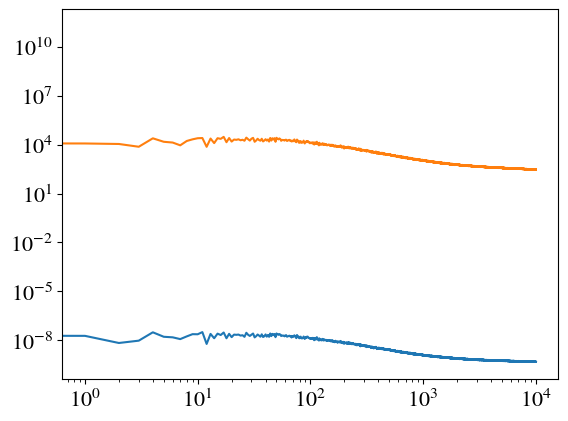

In [75]:
l = np.arange(10001)
plt.plot(l,cl_cib_websky_nofluxcut[2],label='ws ')
plt.plot(l,cl_cib_websky_fluxcut[2],label='ws ')
plt.loglog()

In [80]:
cl_cib_shotnoise['shotnoise']

[12.228126586231305,
 200.778652943501,
 4543.6020275401015,
 59161.37379665837,
 590290.5054561861]

In [81]:
cl_cib_shotnoise['nu']

[143.0, 217.0, 353.0, 545.0, 857.0]

# Maniyar cib

In [102]:
from astropy.io import fits
z_c = 1.5
# ######### reading and interpolating the SEDs
snuaddr = '/Users/boris/Work/CLASS-SZ/SO-SZ/halomodel_cib_tsz_cibxtsz/data_files/filtered_snu_planck.fits'
hdulist = fits.open(snuaddr)
"""
The effective SEDs for the CIB for Planck (100, 143, 217, 353, 545,
857) and
IRAS (3000) GHz frequencies.
Here we are shwoing the CIB power spectra corressponding to the
Planck
frequency channels. If you want to calculate the Hershel/Spire
power spectra, use corresponding files in the data folder.
"""
redshifts = hdulist[1].data
snu_eff = hdulist[0].data  # in Jy/Lsun

# print(hdulist[1].header)

hdulist.close()
# snuinterp = interp1d(redshifts, snu_eff, kind='linear',
#                      bounds_error=False, fill_value=0.)


In [103]:
snuinterpnu = interp1d(np.array([100, 143, 217, 353, 545,857,3000]), 
snu_eff, kind='linear',axis=0,
bounds_error=False, fill_value="extrapolate")

In [104]:
snu90 = snuinterpnu(90)
np.shape(snu90)

(210,)

In [105]:
snu_eff = np.insert(snu_eff,0,snu90,axis=0)

In [106]:
np.shape(snu_eff)

(8, 210)

In [107]:
snuinterp = interp1d(redshifts, snu_eff, kind='linear',
                     bounds_error=False, fill_value="extrapolate")

In [108]:
z = 0.32
snu = snuinterp(0)

In [109]:
snu

array([1.85437837e-13, 2.26736016e-13, 4.04318188e-13, 1.30435395e-12,
       5.85276158e-12, 2.21912014e-11, 7.89701227e-11, 3.84971472e-10])

In [110]:
np.shape(redshifts)

(210,)

In [111]:
redshifts = np.insert(redshifts,0,0.)
redshifts
np.shape(redshifts)

(211,)

In [112]:
snu_eff = np.insert(snu_eff,0,snu,axis=1)

In [113]:
np.shape(snu_eff)

(8, 211)

In [114]:
np.savetxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/filtered_snu_planck_90_100_143_217_353_545_857.txt',
          np.c_[snu_eff[0,:],snu_eff[1,:],snu_eff[2,:],snu_eff[3,:],snu_eff[4,:],snu_eff[5,:],snu_eff[6,:]])
np.savetxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/filtered_snu_planck_z.txt',
          np.c_[redshifts])
np.savetxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/filtered_snu_planck_nu.txt',
          np.c_[np.array([90,100, 143, 217, 353, 545,
857])])

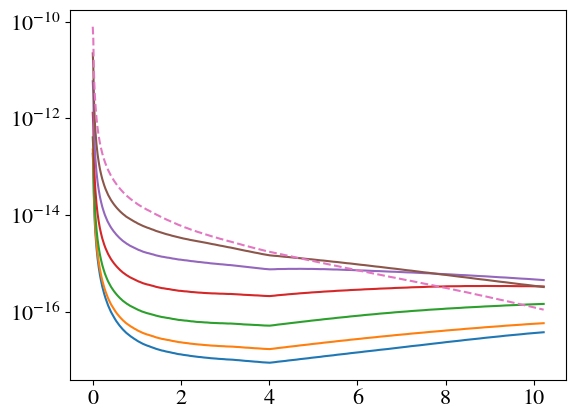

In [115]:
plt.plot(redshifts,snu_eff[0,:])
plt.plot(redshifts,snu_eff[1,:])
plt.plot(redshifts,snu_eff[2,:])
plt.plot(redshifts,snu_eff[3,:])
plt.plot(redshifts,snu_eff[4,:])
plt.plot(redshifts,snu_eff[5,:])
plt.plot(redshifts,snu_eff[6,:],ls='--')
plt.yscale('log')

## compute maniyar cib

In [17]:
M = Class()
M.set({'output':'cib_cib_1h,cib_cib_2h'})
# M.set({'output':'cib_cib_1h'})
# M.set(common_settings)
M.set(websky_cosmo)
# M.set(websky_cib_params)
M.set({
    
'mass function' : 'T08M200c',
'use_maniyar_cib_model':1,
'maniyar_cib_etamax' : 0.42,
'maniyar_cib_zc' : 1.5,
'maniyar_cib_tau' : 1.17,
'maniyar_cib_fsub' : 0.,
'Most efficient halo mass in Msun' : 10.**12.94,
'Size of of halo masses sourcing CIB emission' : 1.75**2.,
#for the monopole computation:
'freq_min': 9e1,
'freq_max': 8e2,
'dlogfreq' : 0.05,
    
    
    

# 'Redshift evolution of dust temperature' :  0.2,
# 'Dust temperature today in Kelvins' : 20.7,
# 'Emissivity index of sed' : 1.6,
# 'Power law index of SED at high frequency' : 1.7, # not given in WebSky paper, actually not relevant since we dont use high freqs in websky.
# 'Redshift evolution of L − M normalisation' : 1.28, # try 2.4 see slack. 
# 'Most efficient halo mass in Msun' : 10.**12.3,
# 'Normalisation of L − M relation in [Jy MPc2/Msun]' : 1e-7,  # not given in WebSky paper
# 'Size of of halo masses sourcing CIB emission' : 0.3,
# 'z_plateau_cib' : 2.,

# M_min_HOD is the threshold above which nc = 1:
# 'M_min_HOD' : 10.**10.1, # not used here
'use_nc_1_for_all_halos_cib_HOD': 1,

'sub_halo_mass_function' : 'TW10',#'JvdB14',
'M_min_subhalo_in_Msun' : 1e5, # 1e5 see https://github.com/abhimaniyar/halomodel_cib_tsz_cibxtsz/blob/master/Cell_cib.py
'use_redshift_dependent_M_min': 0,
#'full_path_to_redshift_dependent_M_min':'/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/websky_halo_mass_completion_z_Mmin_in_Msun_over_h.txt',
'M_min' : 1e10*websky_cosmo['h'], # not used
'M_max' : 1e16*websky_cosmo['h'],
'z_min' : 5e-3,
'z_max' : 10.,
'ell_min': 10.,
'ell_max':5e4,
'dlogell':0.2,


# table 1 of https://arxiv.org/pdf/1309.0382.pdf
#1: freq GHz 2: Flux cut mJy
# 100 - 400
# 143 - 350
# 217 - 225
# 353 - 315
# 545 - 350
# 857 - 710
# 3000  - 1000
#cib_Snu_1 = 315.
#cib_Snu_2 = 315.
#'cib_Snu_cutoff_list [mJy]':'315',
'has_cib_flux_cut': 0
})

M.set({
       'cib_frequency_list_num' : 5,
       'cib_frequency_list_in_GHz' : '143,217,353,545,95',  
      })
M.compute()

In [18]:
cl_cib_cib = M.cl_cib_cib()
# cib_monopole = M.cib_monopole()
# cl_cib_shotnoise = M.cib_shotnoise()

In [5]:
10.**12.94

8709635899560.797

In [6]:
1.75**2

3.0625

In [7]:
1.1*1.1

1.2100000000000002

In [19]:
fname_planck  = "/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_all.dat"
data = np.loadtxt(fname_planck, usecols = (0,7,12,16,19)) # Pour avoir le template à 143,217,353,545GHz
ell_planck = data[:,0]
cl_planck_Jy = data[:,1:]

cl_planck_143 = cl_planck_Jy[:,0]
cl_planck_217 = cl_planck_Jy[:,1]
cl_planck_353 = cl_planck_Jy[:,2]
cl_planck_545 = cl_planck_Jy[:,3]
# cl_planck_857 = cl_planck_Jy[:,4]

In [20]:
nside = 4096
with open(f"/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_files/cl_cib_Jysr_nside{nside}_fluxcutPLANCK_density.pick", "rb") as f:
    cl_cib_websky_fluxcut = pickle.load(f)
with open(f"/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_files/cl_cib_Jysr_nside{nside}_PLANCK_density.pick", "rb") as f:
    cl_cib_websky_nofluxcut = pickle.load(f)

In [21]:
planck_2013 ={
'217x217':{
'cl' : np.asarray([
1.78e3, # < this is an upper bound
8.47e2, # < this is an upper bound
4.17e2, 
2.62e2, 
1.75e2, 
1.17e2, 
8.82e1, 
6.42e1, 
3.34e1, 
4.74e1
]),
'ecl' : np.asarray([
0.,
0., 
0.47e2, 
0.20e2, 
0.13e2, 
0.10e2, 
0.89e1, 
1.61e1, 
2.15e1, 
0.65e1
]),
'ell': np.asarray([
53,
114,
187,
320, 
502, 
684, 
890,
1158, 
1505,
1956
])
},
    
    # '217x217':{'cl':np.asarray([1.78e3, 8.47e2, 4.17e2, 2.62e2, 1.75e2, 1.17e2, 8.82e1, 6.42e1, 3.34e1, 4.74e1]),
    #            'ecl':np.asarray([0.,0., 0.47e2, 0.20e2, 0.13e2, 0.10e2, 0.89e1, 1.61e1, 2.15e1, 0.65e1]),
    #            'ell':np.asarray([53,114,187,320, 502, 684, 890,1158, 1505, 1956])},
    '143x143':{'cl':np.asarray([1.55e2, 6.41e1, 3.64e1, 3.23e1, 2.81e1, 2.27e1, 1.84e1, 1.58e1, 1.25e1]),
               'ecl':np.asarray([0.,0., 0.73e1, 0.35e1, 0.30e1, 0.29e1, 0.35e1, 0.91e1, 1.28e1]),
               'ell':np.asarray([53,114,187,320, 502, 684, 890,1158, 1505])},
    '353x353':{'cl':np.asarray([3.68e4, 1.66e4, 7.88e3, 4.35e3, 2.60e3, 1.74e3, 1.29e3, 9.35e2, 7.75e2, 6.08e2]),
               'ecl':np.asarray([0.,0., 0.53e3, 0.18e3, 0.10e3, 0.07e3, 0.05e3, 0.33e2, 0.22e2, 0.16e2]),
               'ell':np.asarray([53,114,187,320, 502, 684, 890,1158, 1505, 1956])},
    '545x545':{'cl':np.asarray([3.74e5, 1.45e5, 6.63e4, 3.34e4, 1.91e4, 1.25e4, 9.17e3, 6.83e3, 5.34e3, 4.24e3, 3.42e3]),
               'ecl':np.asarray([0.,0., 0.51e4, 0.12e4, 0.04e4, 0.03e4, 0.17e3, 0.10e3, 0.06e3, 0.04e3, 0.04e3]),
               'ell':np.asarray([53,114,187,320, 502, 684, 890,1158, 1505, 1956, 2649])},
    '857x857':{'cl':np.asarray([2.76e6, 7.99e5, 2.87e5, 1.34e5, 7.20e4, 4.38e4, 3.23e4, 2.40e4, 1.83e4, 1.46e4, 1.16e4]),
               'ecl':np.asarray([0.,0., 0.37e5, 0.08e5, 0.26e4, 0.18e4, 0.09e4, 0.05e4, 0.03e4, 0.02e4, 0.01e4]),
               'ell':np.asarray([53,114,187,320, 502, 684, 890,1158, 1505, 1956, 2649])}
}

In [22]:

# nuf = '545'
# freq = nuf+'x'+nuf
# cl_cib_cib[freq]['1h']

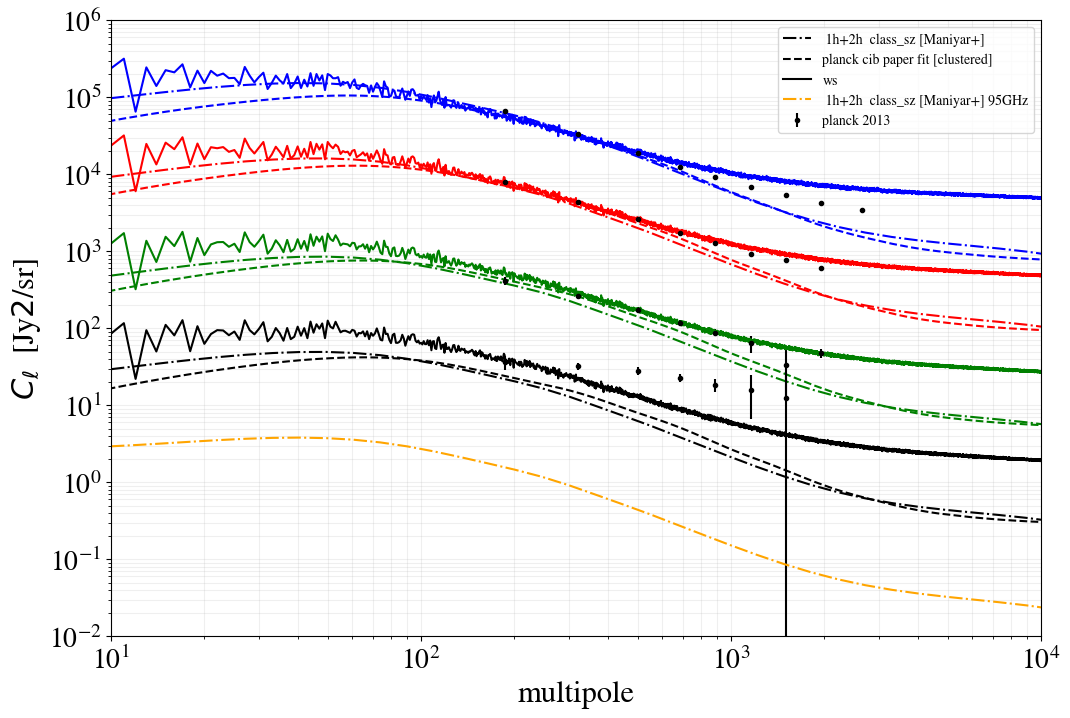

In [27]:
plt.figure(figsize=(12,8))

nuf = '545'
freq = nuf+'x'+nuf

l_csz = np.asarray(cl_cib_cib[freq]['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = (1.068)**1.*np.asarray(cl_cib_cib[freq]['1h'])/cls_to_dls # color correction factors, see https://arxiv.org/pdf/2006.16329.pdf eq. 26 and https://github.com/abhimaniyar/halomodel_cib_tsz_cibxtsz/blob/master/driver_cell.ipynb
cls_csz_2h = (1.068)**1.*np.asarray(cl_cib_cib[freq]['2h'])/cls_to_dls



plt.plot(l_csz,(cls_csz_1h+cls_csz_2h),ls='-.',
         #label=' 1h+2h  class_sz ',
         c='b')


plt.plot(ell_planck,cl_planck_545,ls='--',
         #label='planck cib paper fit [clustered]',
         c='b')


pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'][2:],
             planck_2013[freq]['cl'][2:],
             yerr=planck_2013[freq]['ecl'][2:],
             marker= 'o',
             markersize=3.,
             ls='None',
             c='k',
            # label = 'planck 2013'
            )


l = np.arange(10001)
plt.plot(l,1e12*cl_cib_websky_nofluxcut[3],
         #label='ws ',
         c='b')


# plt.plot(l,np.repeat(cl_cib_shotnoise['shotnoise'][3],len(l)),c='b',ls=':')

# plt.figure(figsize=(12,8))

nuf = '353'
freq = nuf+'x'+nuf

l_csz = np.asarray(cl_cib_cib[freq]['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = (1.097)**1.*np.asarray(cl_cib_cib[freq]['1h'])/cls_to_dls
cls_csz_2h = (1.097)**1.*np.asarray(cl_cib_cib[freq]['2h'])/cls_to_dls



plt.plot(l_csz,(cls_csz_1h+cls_csz_2h),ls='-.',
         #label=' 1h+2h  class_sz',
         c='r')


plt.plot(ell_planck,cl_planck_353,ls='--',
         #label='planck cib paper fit [clustered]',
         c='r')


pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'][2:],
             planck_2013[freq]['cl'][2:],
             yerr=planck_2013[freq]['ecl'][2:],
             marker= 'o',
             markersize=3.,
             ls='None',
             c='k',
             #label = 'planck 2013'
            )


l = np.arange(10001)
plt.plot(l,1e12*cl_cib_websky_nofluxcut[2],
         #label='ws',
         c='r')

# plt.plot(l,np.repeat(cl_cib_shotnoise['shotnoise'][2],len(l)),c='r',ls=':')


nuf = '217'
freq = nuf+'x'+nuf

l_csz = np.asarray(cl_cib_cib[freq]['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = (1.119)**1.*np.asarray(cl_cib_cib[freq]['1h'])/cls_to_dls
cls_csz_2h = (1.119)**1.*np.asarray(cl_cib_cib[freq]['2h'])/cls_to_dls


plt.plot(l_csz,(cls_csz_1h+cls_csz_2h),ls='-.',
         #label=' 1h+2h  class_sz',
         c='g')


plt.plot(ell_planck,cl_planck_217,ls='--',
         #label='planck cib paper fit [clustered]',
         c='g')


pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'][2:],
             planck_2013[freq]['cl'][2:],
             yerr=planck_2013[freq]['ecl'][2:],
             marker= 'o',
             markersize=3.,
             ls='None',
             c='k',
             #label = 'planck 2013'
            )


l = np.arange(10001)
plt.plot(l,1e12*cl_cib_websky_nofluxcut[1],
         #label='ws',
         c='g',ls='-')

# plt.plot(l,np.repeat(cl_cib_shotnoise['shotnoise'][1],len(l)),c='g',ls=':')


nuf = '143'
freq = nuf+'x'+nuf

l_csz = np.asarray(cl_cib_cib[freq]['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = (1.017)**1.*np.asarray(cl_cib_cib[freq]['1h'])/cls_to_dls
cls_csz_2h = (1.017)**1.*np.asarray(cl_cib_cib[freq]['2h'])/cls_to_dls



plt.plot(l_csz,(cls_csz_1h+cls_csz_2h),ls='-.',
         label=' 1h+2h  class_sz [Maniyar+]',
         c='k')


plt.plot(ell_planck,cl_planck_143,ls='--',
         label='planck cib paper fit [clustered]',
         c='k')


pfacdl = planck_2013[freq]['ell']*(planck_2013[freq]['ell']+1.)/2./np.pi
plt.errorbar(planck_2013[freq]['ell'][2:],
             planck_2013[freq]['cl'][2:],
             yerr=planck_2013[freq]['ecl'][2:],
             marker= 'o',
             markersize=3.,
             ls='None',
             label = 'planck 2013',
             c='k')


l = np.arange(10001)
plt.plot(l,1e12*cl_cib_websky_nofluxcut[0],label='ws',c='k',ls='-')



# plt.plot(l,np.repeat(cl_cib_shotnoise['shotnoise'][0],len(l)),c='k',ls=':')


nuf = '95'
freq = nuf+'x'+nuf

l_csz = np.asarray(cl_cib_cib[freq]['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = (1.0)**1.*np.asarray(cl_cib_cib[freq]['1h'])/cls_to_dls
cls_csz_2h = (1.0)**1.*np.asarray(cl_cib_cib[freq]['2h'])/cls_to_dls



plt.plot(l_csz,(cls_csz_1h+cls_csz_2h),ls='-.',
         label=' 1h+2h  class_sz [Maniyar+] 95GHz',
         c='orange')


plt.loglog()
plt.xlim(10,1e4)
plt.ylim(1e-2,1e6)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [Jy$2$/sr]',fontsize=22)
# plt.title('545x545')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=10)


In [ ]:
M = Class()

M.set({
'output':'cib_cib_1h',
'mass function' : 'T08M200c',
'use_maniyar_cib_model':1,
'maniyar_cib_etamax' : 0.42,
'maniyar_cib_zc' : 1.5,
'maniyar_cib_tau' : 1.17,
'Most efficient halo mass in Msun' : 10.**12.94,
'Size of of halo masses sourcing CIB emission' : 1.75**2.,
'freq_min': 9e1,
'freq_max': 8e2,
'dlogfreq' : 0.05,

'use_nc_1_for_all_halos_cib_HOD': 1,

'sub_halo_mass_function' : 'TW10',#'JvdB14',
'M_min_subhalo_in_Msun' : 1e11,
'use_redshift_dependent_M_min': 1,

'M_max' : 1e16,
'z_min' : 5e-3,
'z_max' : 4.6,
'ell_min': 10.,
'ell_max':5e4,
'dlogell':0.2,

'has_cib_flux_cut': 0,

'cib_frequency_list_num' : 4,
'cib_frequency_list_in_GHz' : '143,217,353,545'
})
M.compute()